# TRABAJO FIN DE MASTER - MODELOS DE PREDICCIÓN - MAG10
# **Author**: Cristóbal León-Salas
# **Date**: 2025-10-25

# LIBRERIAS

Se cargan las siguietnes librerias:

-  pandas --> Para tablas de datos.
-  numpy --> para cálculos numéricos y para trabajar con matrices y vectores.
-  os --> Para trabajar con directorios, archivos, carpetas,...
-  json --> Para trabajar con datos en formato JSON
-  shap --> Para explicar las predicciones de modelos de machine learning mediante valores de contribución basados en teoría de juegos.
-  matplotlib --> Para hacer visualizaciones gráficas básicas.
-  seaborn --> Para gráficos estadísticos más profesionales y de fácil interpretación.
-  warnings --> Para evitar mensajes de advertencias
-  product -->  Para sacar todas las combinaciones posibles entre los elementos de dos o más lista
-  display --> Para sacar tablas con formato.
-  KNeighborsRegressor --> Para obtener pronóstico con K-vecinos
-  ExponentialSmoothing --> Para hacer predicciones con suavizados exponenciales (Holt-Winters)
-  folium --> Para representación georreferenciada
-  unicodedata --> Permite manejar caracteres Unicode, como letras con acentos, eñes, tildes, etc.
-  re --> Es la librería estándar de Python para trabajar con expresiones regulares. Se usa para encontrar o reemplazar patrones de texto.
-  StandardScaler --> Para el normalizado y escalado de las variables
-  PCA --> Para llevar a cabo la técnica de componentes principales
-  mean_absolute_error, mean_squared_error --> Para hallar las métricas de los modelos
-  LGBMRegressor --> Para aplicar modelo LGBM
-  XGBRegressor--> Para aplicar modelos XGBOOST
-  CatBoostRegressor --> Para ejecutar modelos CatBoost
-  Prophet --> Para aplciar modelos Prophet
-  itertools --> Para hacer iteraciones eficientes
-  adfuller --> Ejecuta el test de Dickey–Fuller aumentado (ADF), que sirve para verificar si una serie temporal es estacionaria o no.
-  plot_acf, plot_pacf --> Para sacar los gráficos ACF y PACF
-  import SARIMAX --> Para aplicar modelos SARIMA
-  LSTM --> Captura dependencias temporales largas en series temporales
-  Dense --> Transforma la salida de capas anteriores en predicciones o activaciones
-  Conv1D --> Detecta patrones locales o estacionales en series temporales
-  GlobalAveragePooling1D --> Resume la información de toda la secuencia para clasificación o regresión
-  InputLayer --> Útil para modelos más personalizados o cuando no se usa input_shape en la primera capa
-  EarlyStopping --> Permito que los modelos deep learning se paren cuando ndeja de mejorar la validación. Ayuda a mitigar el sobreajuste


In [1]:
import pandas as pd
import numpy as np
import os
import json
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product
from IPython.display import display
import folium
from ydata_profiling import ProfileReport
from skimpy import skim
import unicodedata
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from prophet import Prophet
import lightgbm as lgb
from openpyxl import load_workbook
from pathlib import Path
from statsmodels.tsa.arima.model import ARIMA
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, GlobalAveragePooling1D, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
import random

# Ignorar el SettingWithCopyWarning
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
sns.set()

# FUNCIONES

## FUNCIÓN resumen_mediciones

Esta función re genera un resumen estadístico de los días en los que se superó un umbral de concentración de contaminantes (en este caso, 80 µg/m³) en una zona determinada.

In [2]:

def resumen_mediciones(df, zona, umbral=80):
    """
    Calcula el número de días y su distribución temporal
    en los que la concentración supera un determinado umbral,
    incluyendo el porcentaje respecto al total de registros.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame con las columnas 'DIA/MES/ANO', 'MEDICION_ugm3' y 'dow'.
    zona : str
        Nombre de la zona (por ejemplo: 'NORTE', 'CENTRO', 'SUR').
    umbral : float, opcional
        Valor límite de concentración (µg/m³) a evaluar.
        Por defecto = 80.

    Retorna
    -------
    dict :
        Diccionario con:
        - total_dias: número total de días que superan el umbral.
        - porcentaje_superan: % de registros que superan el umbral.
        - conteo_mes_anio: DataFrame con conteo por año y mes (mes en español).
        - conteo_dia_semana: DataFrame con conteo por día de la semana (en español).
    """

    # Filtrar días que superan el umbral
    df_filtrado = df[df["MEDICION_ugm3"] > umbral].copy()
    total_dias = df_filtrado.shape[0]
    total_registros = df.shape[0]

    # Calcular porcentaje
    porcentaje_superan = round((total_dias / total_registros) * 100, 2) if total_registros > 0 else 0

    # Añadir variables temporales
    df_filtrado["AÑO"] = df_filtrado["DIA/MES/ANO"].dt.year
    df_filtrado["MES_NUM"] = df_filtrado["DIA/MES/ANO"].dt.month
    df_filtrado["MES"] = df_filtrado["MES_NUM"].map({
        1: "enero", 2: "febrero", 3: "marzo", 4: "abril",
        5: "mayo", 6: "junio", 7: "julio", 8: "agosto",
        9: "septiembre", 10: "octubre", 11: "noviembre", 12: "diciembre"
    })

    # Si la columna 'dow' no es categórica, convertirla para mantener orden lógico
    if not pd.api.types.is_categorical_dtype(df_filtrado["dow"]):
        categorias_ordenadas = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
        df_filtrado["dow"] = pd.Categorical(df_filtrado["dow"], categories=categorias_ordenadas, ordered=True)

    df_filtrado["DIA_SEMANA"] = df_filtrado["dow"]

    # Conteo por mes y año
    conteo_mes_anio = (
        df_filtrado.groupby(["AÑO", "MES"])
        .size()
        .reset_index(name=f"DIAS_SUPERAN_{umbral}")
        .sort_values(by=f"DIAS_SUPERAN_{umbral}", ascending=False)
    )

    # Conteo por día de la semana (manteniendo el orden de los días)
    conteo_dia_semana = (
        df_filtrado["DIA_SEMANA"]
        .value_counts()
        .reindex(df_filtrado["DIA_SEMANA"].cat.categories)
        .reset_index(name=f"DIAS_SUPERAN_{umbral}")
        .rename(columns={"index": "DIA_SEMANA"})
        .sort_values(by=f"DIAS_SUPERAN_{umbral}", ascending=False)   
    )

    # Devolver resultados
    return {
        "zona": zona,
        "total_dias": total_dias,
        "porcentaje_superan": porcentaje_superan,
        "conteo_mes_anio": conteo_mes_anio,
        "conteo_dia_semana": conteo_dia_semana
    }



## Función agrupar_mensual

Transforma un DataFrame con fechas en formato "DIA/MES/ANO" en una serie temporal mensual, calculando la media de todas las columnas numéricas por mes y año

In [3]:
def agrupar_mensual(df):
    df = df.copy()
    df["DIA/MES/ANO"] = pd.to_datetime(df["DIA/MES/ANO"], errors="coerce")
    df["year"] = df["DIA/MES/ANO"].dt.year

    if "month" not in df.columns:
        df["month"] = df["DIA/MES/ANO"].dt.month
    else:
        if df["month"].dtype == "object" or str(df["month"].dtype).startswith("category"):
            df["month"] = df["month"].map(MAPA_MES).fillna(df["DIA/MES/ANO"].dt.month)

    df_mensual = (
        df.groupby(["year", "month"], as_index=False)
          .mean(numeric_only=True)
          .sort_values(["year", "month"])
    )

    cols = ["year", "month"] + [c for c in df_mensual.columns if c not in ["year", "month"]]
    return df_mensual[cols]

## Función preparar_serie_mensual

Transforma un DataFrame mensual en una serie temporal limpia y lista para modelar.

In [4]:
def preparar_serie_mensual(df_mensual):
    df = df_mensual.copy()
    df["year"] = df["year"].astype(int)
    df["month"] = df["month"].round().astype(int)
    df["fecha"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
    df = df.sort_values("fecha")
    df = df[~df["MEDICION_ugm3"].isna()]
    serie = df.set_index("fecha")["MEDICION_ugm3"].astype(float)
    return serie

## FUNCIÓN plot_serie

Visualizacion de la serie

In [5]:
def plot_serie(serie, titulo, nombre_salida=None, mostrar=True):
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, color="steelblue", linewidth=1.8)
    plt.title(titulo)
    plt.xlabel("Fecha")
    plt.ylabel("Concentración PM10 (µg/m³)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if nombre_salida:
        plt.savefig(nombre_salida, dpi=150)
        print(f"📁 Guardado gráfico en: {nombre_salida}")

    if mostrar:
        plt.show()
    else:
        plt.close()

## FUNCIÓN test_adf

Aplica el test ADF y devuelve el p-value

In [6]:
def test_adf(serie, nombre="serie"):
    """
    Aplica el test ADF y devuelve el p-value.
    Hipótesis nula: la serie NO es estacionaria (tiene raíz unitaria).
    p-value < 0.05 ⇒ rechazamos H0 ⇒ estacionaria.
    Test ADF: El estadístico ADF es un número negativo. Cuanto más negativo, más evidencia contra la no estacionariedad. Pero en la práctica, el p-valor es lo que se usa para decidir.
    """
    serie = serie.dropna()
    resultado = adfuller(serie, autolag="AIC")
    pvalor = resultado[1]
    print(f"ADF {nombre}: estadístico={resultado[0]:.3f}, p-valor={pvalor:.4f}")
    # :.3f → muestra el número como float con 3 decimales
    # :.4f → muestra el número como float con 4 decimales
    return pvalor

## FUNCIÓN diferencia_serie

Aplica una diferenciación (d veces) y elimina NaN iniciales

In [7]:
def diferencia_serie(serie, d=1):
    """Aplica una diferenciación (d veces) y elimina NaN iniciales."""
    s = serie.copy()
    for _ in range(d):
        s = s.diff().dropna()
    return s

## FUNCIÓN plot_serie_diferenciada

Guarda gráfico de serie (original o diferenciada).

In [8]:
def plot_serie_diferenciada(serie, titulo, nombre_salida):
    """Guarda gráfico de serie (original o diferenciada)."""
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, color="steelblue", linewidth=1.5)
    plt.title(titulo)
    plt.xlabel("Fecha")
    plt.ylabel("Valor diferenciado" if "Δ" in titulo else "Concentración PM10 (µg/m³)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(nombre_salida, dpi=150)
    plt.close()
    print(f"📁 Guardado gráfico: {nombre_salida}")

## FUNCIÓN aplicar_diferenciacion

Aplica la diferenciación de la serie. Si d = 0 -> devuelve la original.

In [9]:
def aplicar_diferenciacion(serie, d):
    """
    Devuelve la serie ya diferenciada 'd' veces.
    Si d = 0 -> devuelve la original.
    """
    s = serie.copy()
    for _ in range(d):
        s = s.diff()
    return s.dropna()

## FUNCIÓN guardar_acf_pacf

Dibuja y guarda ACF y PACF de una serie estacionaria.

In [10]:
def guardar_acf_pacf(serie_estac, zona, carpeta_salida_base, lags=40):
    """
    Dibuja y guarda ACF y PACF de una serie estacionaria.
    Genera dos archivos PNG: acf.png y pacf.png
    """
    carpeta_zona = os.path.join(carpeta_salida_base, zona)
    os.makedirs(carpeta_zona, exist_ok=True)

    # --- ACF ---
    plt.figure(figsize=(8,4))
    plot_acf(serie_estac, lags=lags)
    plt.title(f"{zona} - ACF (serie estacionaria)")
    plt.tight_layout()
    ruta_acf = os.path.join(carpeta_zona, "acf.png")
    plt.savefig(ruta_acf, dpi=150)
    plt.close()
    print(f"📁 Guardado: {ruta_acf}")

    # --- PACF ---
    plt.figure(figsize=(8,4))
    plot_pacf(serie_estac, lags=lags, method='ywm')
    plt.title(f"{zona} - PACF (serie estacionaria)")
    plt.tight_layout()
    ruta_pacf = os.path.join(carpeta_zona, "pacf.png")
    plt.savefig(ruta_pacf, dpi=150)
    plt.close()
    print(f"📁 Guardado: {ruta_pacf}")

## FUNCIÓN train_test_split_temporal

Función que define la muestra de entrenamiento y la de test

In [11]:
def train_test_split_temporal(serie, fecha_corte='2024-06-30'):
    train = serie.loc[:fecha_corte]
    test = serie.loc[fecha_corte:]
    if len(test) > 0 and train.index.max() == test.index.min():
        test = test.iloc[1:]
    return train, test

## FUNCIÓN evaluar_modelo

Función que calcula el error de los modelos

In [12]:
def evaluar_modelo(nombre, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{nombre} → RMSE: {rmse:.3f}")
    return rmse

## FUNCIÓN ajustar_y_aic

Ajusta un ARIMA(p,d,q) y devuelve (AIC, modelo)

In [13]:
def ajustar_y_aic(train, order_tuple):
    """
    Ajusta un ARIMA(p,d,q) y devuelve (AIC, modelo) o (np.inf, None) si no converge.
    """
    try:
        modelo = ARIMA(train, order=order_tuple)
        ajuste = modelo.fit()
        return ajuste.aic, ajuste
    except Exception as e:
        print(f"   ⚠️  ARIMA{order_tuple} no converge ({e})")
        return np.inf, None

## FUNCIÓN plot_predicciones

Se grafican los valores reales y las predicciones de los modelos

In [14]:
def plot_predicciones(zona, train, test, pred_test, ruta_salida, mostrar=True):
    """Gráfico individual de valores reales vs predichos."""
    plt.figure(figsize=(10,4))
    plt.plot(train.index, train.values, label="Train", color="gray", alpha=0.6)
    plt.plot(test.index, test.values, label="Test (real)", color="steelblue", marker="o")
    plt.plot(test.index, pred_test, label="Predicción ARIMA", color="darkorange", marker="o")
    plt.title(f"{zona} - Predicciones ARIMA finales")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración PM10 (µg/m³)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(ruta_salida, dpi=150)
    print(f"📁 Guardado gráfico: {ruta_salida}")
    if mostrar:
        plt.show()
    plt.close()

## FUNCIÓN preparar_datos_ml

Construye el dataset de Machine Learning (con lags, rolling, mes, etc.) y devuelve los conjuntos de entrenamiento y prueba.

In [15]:
def preparar_datos_ml(
    df_mensual,
    fecha_corte="2024-06-30",
    lags=[1,2,3,12],
    usar_columnas_exogenas=None
):
    """
    Construye el dataset ML a partir del dataframe mensual de una zona.
    - Crea target = MEDICION_ugm3.
    - Genera lags y rolling windows de la propia serie.
    - Añade variables calendario (mes, año, tendencia).
    - Incluye exógenas relevantes si se le pasan.
    - Divide en train/test temporalmente.

    Parámetros
    ----------
    df_mensual : pd.DataFrame
        DataFrame mensual de la zona tras agrupar_mensual().
        Debe tener al menos: ['year','month','MEDICION_ugm3', ...exógenas...]
    fecha_corte : str
        Fecha límite para separar train y test. Ej: '2024-07-01'
    lags : list[int]
        Rezagos que usaremos como predictores (lag_1, lag_2, lag_3, lag_12, ...)
    usar_columnas_exogenas : list[str] | None
        Lista de columnas exógenas (meteorología, viento, etc.) que queremos
        incluir tal cual en el modelo. Si None, no se añaden exógenas.

    Devuelve
    --------
    X_train, y_train, X_test, y_test, df_ml
    """

    # 1️⃣ Asegurar índice temporal mensual (DatetimeIndex)
    # Esto permite operar con .shift(), .rolling() y hacer splits temporales
    df = indexar_por_fecha_mensual(df_mensual)

    # 2️⃣ Definir la variable objetivo (target)
    # Se parte de la columna principal de interés: MEDICION_ugm3
    df["target"] = df["MEDICION_ugm3"]

    # 3️⃣ Variables calendario y tendencia
    # Se añaden variables temporales explícitas para capturar estacionalidad y tendencia secular
    df["mes"] = df.index.month
    df["anio"] = df.index.year
    df["t_index"] = range(len(df))  # proxy de tiempo absoluto (útil para modelos no temporales)

    # 4️⃣ Crear lags de la variable objetivo
    # Capturan dependencia temporal directa (autoregresiva)
    for lag in lags:
        df[f"lag_{lag}"] = df["target"].shift(lag)

    # 5️⃣ Crear medias móviles (rolling means)
    # Capturan tendencias acumuladas y suavizan ruido
    df["roll3_mean"]  = df["target"].shift(1).rolling(window=3).mean()
    df["roll6_mean"]  = df["target"].shift(1).rolling(window=6).mean()
    df["roll12_mean"] = df["target"].shift(1).rolling(window=12).mean()

    # 6️⃣ Añadir variables exógenas si se especifican
    # Se incluyen tal cual, asumiendo que son observables en el mismo mes
    if usar_columnas_exogenas is not None:
        for col in usar_columnas_exogenas:
            if col in df.columns:
                # Si se desea causalidad estricta, se podría usar lag_1 de estas también
                pass
            else:
                print(f"⚠️ Aviso: la columna exógena '{col}' no está en df_mensual y se ignora.")

        # Filtramos solo las columnas exógenas que realmente existen en el DataFrame
        cols_exog_presentes = [c for c in usar_columnas_exogenas if c in df.columns]
    else:
        cols_exog_presentes = []

    # 7️⃣ Eliminar filas con NaN generados por lags y rolling
    # Esto asegura que el modelo no reciba valores faltantes
    df_ml = df.dropna().copy()

    # 8️⃣ Definir conjunto de variables predictoras (features)
    # Se combinan variables temporales, lags, rolling y exógenas (si las hay)
    columnas_feature_base = (
        ["mes", "anio", "t_index"] +
        [f"lag_{lag}" for lag in lags] +
        ["roll3_mean", "roll6_mean", "roll12_mean"]
    )
    columnas_feature_totales = columnas_feature_base + cols_exog_presentes

    X = df_ml[columnas_feature_totales].copy()
    y = df_ml["target"].copy()

    # 9️⃣ Separar en conjuntos de entrenamiento y prueba (split temporal)
    # Se respeta la causalidad: el modelo solo ve el pasado
    fecha_corte_ts = pd.to_datetime(fecha_corte)

    X_train = X.loc[X.index <= fecha_corte_ts]
    y_train = y.loc[y.index <= fecha_corte_ts]

    X_test  = X.loc[X.index > fecha_corte_ts]
    y_test  = y.loc[y.index > fecha_corte_ts]

    # 🔁 Ajuste fino: evitar que la fecha de corte esté en ambos conjuntos
    if len(X_test) > 0 and X_train.index.max() == X_test.index.min():
        X_test  = X_test.iloc[1:]
        y_test  = y_test.iloc[1:]

    # 🖨️ Mostrar resumen del split
    print(f"📆 Corte temporal {fecha_corte}: train={len(X_train)} / test={len(X_test)}")

    # 🔚 Devolver conjuntos y DataFrame completo para trazabilidad
    return X_train, y_train, X_test, y_test, df_ml


## FUNCIÓN indexar_por_fecha_mensual

Recibe un df mensual con columnas 'year' y 'month' y devuelve el mismo df con un DatetimeIndex 'fecha' = primer día de cada mes.

In [16]:
def indexar_por_fecha_mensual(df_mensual):
    """
    Recibe un df mensual con columnas 'year' y 'month' y devuelve
    el mismo df con un DatetimeIndex 'fecha' = primer día de cada mes.
    """
    df = df_mensual.copy()
    df["fecha"] = pd.to_datetime(
        dict(year=df["year"].astype(int),
             month=df["month"].astype(int),
             day=1)
    )
    df = df.sort_values("fecha").set_index("fecha")
    return df

## FUNCIÓN forecast_autoregresivo_hasta_2032

Función para hacer forecasts autoregresivos en modelos machine learning con variables exógenas

In [17]:
def forecast_autoregresivo_hasta_2032(
    df_ml_hist,
    modelo_entrenado,
    feature_cols,
    fecha_fin_forecast="2032-12-31",
    lags=[1,2,3,12],
    usar_columnas_exogenas=None
):
    """
    Genera predicciones mensuales iterativas desde el último mes histórico
    hasta fecha_fin_forecast (incluida).

    Parámetros
    ----------
    df_ml_hist : pd.DataFrame
        Histórico ML de la zona (df_ml) devuelto por preparar_datos_ml().
        Debe:
          - estar indexado por fecha mensual (DatetimeIndex)
          - contener 'target' (PM10 real)
          - contener las columnas de features usadas en entrenamiento:
            mes, anio, t_index, lag_1, lag_2, lag_3, lag_12, roll3_mean, ...
            y las exógenas (temperatura, viento, etc.).

    modelo_entrenado :
        Modelo ya fit() (CatBoostRegressor, LGBMRegressor, XGBRegressor, ...)

    feature_cols : list[str]
        Lista EXACTA de columnas que el modelo espera como entrada
        (por ejemplo, Xtr_zona[zona].columns.tolist()).
        El orden y las columnas tienen que coincidir con el entrenamiento.

    fecha_fin_forecast : str
        Fecha final de predicción en formato "YYYY-MM-01".
        Ejemplo: "2032-12-31".

    lags : list[int]
        Lags autoregresivos que se usan como features (coherentes con entrenamiento)
        Ej: [1,2,3,12]

    usar_columnas_exogenas : list[str] or None
        Nombres de las columnas exógenas (ej. temperatura, viento...)
        que se usaron durante el entrenamiento.
        Se proyectarán usando la media climatológica mensual histórica.

    Devuelve
    --------
    df_forecast : pd.DataFrame
        DataFrame con índice temporal futuro y columna "pred" con las predicciones.
    """

    # Copiamos el histórico para no modificarlo de manera destructiva
    df_work = df_ml_hist.copy().sort_index()

    # Última fecha histórica conocida
    fecha_ult_hist = df_work.index.max()

    # Rango futuro de meses
    fechas_future = pd.date_range(
        start=(pd.to_datetime(fecha_ult_hist) + pd.offsets.MonthBegin(1)),
        end=pd.to_datetime(fecha_fin_forecast),
        freq="MS"
    )

    # === Precalcular climatologías mensuales para exógenas ===
    climatologias = {}
    if usar_columnas_exogenas is not None:
        for col in usar_columnas_exogenas:
            if col in df_work.columns:
                # media histórica por mes (1..12)
                climatologias[col] = (
                    df_work
                    .groupby(df_work.index.month)[col]
                    .mean()
                )
            else:
                # columna no existe en el histórico -> la ignoramos
                climatologias[col] = None

    # Aquí acumularemos los resultados futuros
    preds = []

    # Iteramos mes a mes en el futuro
    for fecha_pred in fechas_future:
        # 1. Preparar diccionario con las features para este mes futuro
        fila = {}

        # (a) variables calendario / tendencia temporal
        fila["mes"] = fecha_pred.month
        fila["anio"] = fecha_pred.year
        fila["t_index"] = df_work["t_index"].max() + 1  # seguimos la secuencia temporal

        # (b) lags autoregresivos de la variable objetivo
        # usamos la última versión de df_work["target"],
        # que vamos a ir extendiendo con predicciones futuras
        for lag in lags:
            fila[f"lag_{lag}"] = df_work["target"].iloc[-lag]

        # (c) rolling means basadas en target histórico+predicho
        target_shifted = df_work["target"].shift(1)
        fila["roll3_mean"]  = target_shifted.rolling(window=3).mean().iloc[-1]
        fila["roll6_mean"]  = target_shifted.rolling(window=6).mean().iloc[-1]
        fila["roll12_mean"] = target_shifted.rolling(window=12).mean().iloc[-1]

        # (d) variables exógenas "climatológicas": media histórica mensual
        if usar_columnas_exogenas is not None:
            for col in usar_columnas_exogenas:
                if (col in df_work.columns) and (climatologias.get(col) is not None):
                    # coger la media histórica del mismo mes
                    valor_exog_mes = climatologias[col].get(fecha_pred.month, np.nan)
                    fila[col] = valor_exog_mes
                # si no existe la columna o no hay climatología calculable,
                # simplemente NO la añadimos y se quedará NaN al reindexar

        # 2. Crear DataFrame con UNA fila para este mes futuro
        fila_df = pd.DataFrame(fila, index=[fecha_pred])

        # 3. Ajustar a las columnas exactas del modelo (orden correcto)
        X_future = fila_df.reindex(columns=feature_cols)

        # 4. Predecir PM10 para ese mes futuro
        yhat = modelo_entrenado.predict(X_future)[0]

        # 5. Guardar predicción
        preds.append((fecha_pred, yhat))

        # 6. Incorporar esta nueva "observación predicha" al df_work,
        #    para que pueda alimentar los lags de los meses siguientes
        nueva_fila_full = fila_df.copy()
        nueva_fila_full["target"] = yhat
        df_work = pd.concat([df_work, nueva_fila_full], axis=0)

    # 7. Convertimos lista de predicciones a DataFrame final
    fechas_pred, valores_pred = zip(*preds)
    df_forecast = pd.DataFrame(
        {"pred": valores_pred},
        index=pd.to_datetime(fechas_pred)
    )

    return df_forecast


## FUNCIÓN construir_secuencias_dl

Esta función prepara los datos para entrenar modelos de deep learning como LSTM o CNN1D en series temporales. Su objetivo es transformar un DataFrame tabular en secuencias de entrada que representen ventanas temporales, y dividir el conjunto en entrenamiento y test según una fecha de corte.

In [18]:
def construir_secuencias_dl(df_ml,
                            fecha_corte="2024-06-30",
                            window_size=12,
                            columnas_input=None,
                            columna_objetivo="target"):
    """
    Devuelve tensores listos para LSTM/CNN:
    X_train, y_train, X_test, y_test, fechas_test
    X_* shape: [samples, window_size, n_features]
    y_* shape: [samples]  (vector 1D)
    """
    df = df_ml.copy().sort_index()

    # Nos quedamos solo con columnas_input + target
    df_model = df[columnas_input + [columna_objetivo]].dropna()

    X_list, y_list, fechas_list = [], [], []
    fechas = df_model.index.to_list()

    for i in range(window_size, len(df_model)):
        ventana = df_model.iloc[i-window_size:i]

        # aseguramos que objetivo sea escalar float
        objetivo_val = df_model.iloc[i][columna_objetivo]
        # si por accidente objetivo_val es una Serie de varias columnas, cogemos el primero
        if isinstance(objetivo_val, (pd.Series, np.ndarray, list)):
            objetivo_val = float(np.array(objetivo_val).ravel()[0])

        X_list.append(ventana[columnas_input].values)  # [window_size, n_features]
        y_list.append(objetivo_val)                    # escalar
        fechas_list.append(fechas[i])

    X_all = np.array(X_list)         # [samples, window_size, n_features]
    y_all = np.array(y_list)         # [samples]  <-- AHORA SIEMPRE 1D
    fechas_all = np.array(fechas_list)

    corte_dt = pd.to_datetime(fecha_corte)

    train_mask = fechas_all <= corte_dt
    test_mask  = fechas_all >  corte_dt

    X_train = X_all[train_mask]
    y_train = y_all[train_mask]
    X_test  = X_all[test_mask]
    y_test  = y_all[test_mask]
    fechas_test = fechas_all[test_mask]

    print(f"DL | Corte {fecha_corte} | train={X_train.shape[0]} muestras | test={X_test.shape[0]} muestras")
    print(f"   Shapes -> X_train {X_train.shape}, y_train {y_train.shape}, X_test {X_test.shape}, y_test {y_test.shape}")

    return X_train, y_train, X_test, y_test, fechas_test


## FUNCIÓN build_lstm_model

Esta función construye un modelo de deep learning secuencial con arquitectura LSTM + Dense, diseñado para predecir valores en series temporales.

In [19]:
def build_lstm_model(n_steps, n_features):
    model = Sequential([
        tf.keras.layers.Input(shape=(n_steps, n_features)),
        LSTM(
            64,
            activation="tanh",
            return_sequences=False,
            dropout=0.1,
            recurrent_dropout=0.1
        ),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

## FUNCIÓN build_cnn1d_model

Esta función construye un modelo de deep learning secuencial basado en convoluciones 1D (CNN1D)

In [20]:
def build_cnn1d_model(n_steps, n_features):
    model = Sequential([
        tf.keras.layers.Input(shape=(n_steps, n_features)),
        Conv1D(filters=32, kernel_size=3, activation="relu", padding="causal"),
        Conv1D(filters=32, kernel_size=3, activation="relu", padding="causal"),
        GlobalAveragePooling1D(),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

## FUNCIÓN split_train_val

Divide tu conjunto de entrenamiento (X_train, y_train) en dos partes:
- Subentrenamiento (X_subtrain, y_subtrain)
- Validación (X_val, y_val)

In [21]:
def split_train_val(X_train, y_train, val_ratio=0.2):
    n = X_train.shape[0]
    n_val = int(np.floor(n * val_ratio))
    # validación = las últimas observaciones del train (temporalmente más recientes)
    X_val = X_train[-n_val:]
    y_val = y_train[-n_val:]
    X_subtrain = X_train[:-n_val]
    y_subtrain = y_train[:-n_val]
    return X_subtrain, y_subtrain, X_val, y_val

## FUNCIÓN forecast_dl_hasta_2032

Funcion que realiza un forecast iterativo mensual usando un modelo de deep learning (DL) entrenado para predecir el siguiente mes a partir de una ventana temporal  (series temporales se refiere a un bloque de observaciones consecutivas que se usa como entrada para un modelo, y que siempre tiene el mismo tamaño)

In [22]:
def forecast_dl_hasta_2032(
    df_ml_hist,
    modelo_dl,
    columnas_input_entrenamiento,
    window_size=12,
    fecha_fin_forecast="2032-12-31"
):
    """
    Forecast iterativo mensual hasta fecha_fin_forecast usando un modelo DL (LSTM o CNN1D).

    - columnas_input_entrenamiento: lista ORIGINAL (orden!) de columnas con las que se entrenó el modelo.
    - El modelo puede esperar más features de las que hay ahora mismo en df_ml_hist,
      así que si faltan columnas para cuadrar input_shape, se añaden columnas dummy=0.0
      al final de la secuencia.
    - Se usa "target" autoregresivamente.
    - Para el resto de exógenas usamos la climatología mensual histórica.
    """

    # 1️⃣ Leemos cuántas features espera REALMENTE el modelo
    n_features_esperadas = modelo_dl.input_shape[-1]

    # 2️⃣ Clonamos el histórico y aseguramos índice temporal limpio
    df_hist = df_ml_hist.copy()
    df_hist.index = pd.to_datetime(df_hist.index)
    df_hist = df_hist[~df_hist.index.duplicated(keep="first")].sort_index()

    # 3️⃣ Asegurar que todas las columnas_input_entrenamiento existen en df_hist,
    #    aunque sea como columnas vacías inicialmente
    for col in columnas_input_entrenamiento:
        if col not in df_hist.columns:
            df_hist[col] = np.nan

    if "target" not in df_hist.columns:
        raise ValueError("El dataframe histórico debe contener la columna 'target'.")

    # 4️⃣ Armamos df_model con las columnas de entrenamiento + 'target'
    #     (por si 'target' no estaba explícitamente en la lista de entrada)
    cols_df_model = list(columnas_input_entrenamiento) + ["target"]
    cols_df_model = list(dict.fromkeys(cols_df_model))  # quitar duplicados si 'target' ya iba en columnas_input
    df_model = df_hist[cols_df_model].copy()

    # quitamos filas sin target (por seguridad inicial)
    df_model = df_model.dropna(subset=["target"])

    # 5️⃣ Climatología mensual de las exógenas (todas menos 'target')
    clima_mensual = {}
    for col in cols_df_model:
        if col == "target":
            continue
        clima_mensual[col] = df_model.groupby(df_model.index.month)[col].mean()

    # 6️⃣ Definimos las fechas futuras
    ultima_fecha_hist = df_model.index.max()
    fechas_future = pd.date_range(
        start=(ultima_fecha_hist + pd.offsets.MonthBegin(1)),
        end=pd.to_datetime(fecha_fin_forecast),
        freq="MS"
    )

    # 7️⃣ df_work: histórico extendido con predicciones nuevas
    df_work = df_model.copy()

    # orden base de entrada del modelo (sin dummy todavía)
    orden_base = list(columnas_input_entrenamiento)

    preds = []

    for fecha_pred in fechas_future:
        # Evitar duplicados de índice
        if fecha_pred in df_work.index:
            continue

        # a) coger la ventana más reciente
        ventana_hist = df_work.iloc[-window_size:].copy()

        if len(ventana_hist) < window_size:
            raise ValueError(
                f"No hay suficientes pasos históricos ({len(ventana_hist)}) "
                f"para construir ventana {window_size} en {fecha_pred}."
            )

        # b) asegurar que todas las columnas del orden_base existen
        for col in orden_base:
            if col not in ventana_hist.columns:
                ventana_hist[col] = np.nan

        # c) reordenar ventana_hist según orden_base
        ventana_hist = ventana_hist[orden_base]

        # d) si faltan features para llegar a n_features_esperadas,
        #    añadimos columnas dummy al FINAL
        if ventana_hist.shape[1] < n_features_esperadas:
            faltan = n_features_esperadas - ventana_hist.shape[1]
            for j in range(faltan):
                dummy_name = f"__dummy_{j}"
                ventana_hist[dummy_name] = 0.0  # valor neutro
        elif ventana_hist.shape[1] > n_features_esperadas:
            # en caso extremo: recortamos columnas sobrantes al final
            ventana_hist = ventana_hist.iloc[:, :n_features_esperadas]

        # e) construir X_input con shape (1, window_size, n_features_esperadas)
        X_input = ventana_hist.values[np.newaxis, :, :]

        # f) predecir
        yhat = float(modelo_dl.predict(X_input, verbose=0).flatten()[0])
        preds.append((fecha_pred, yhat))

        # g) construir nueva fila futura
        mes_fut = fecha_pred.month
        nueva_fila_dict = {}

        # rellenamos TODAS las columnas base del modelo
        for col in orden_base:
            if col == "target":
                nueva_fila_dict[col] = yhat
            else:
                nueva_fila_dict[col] = clima_mensual[col].get(mes_fut, np.nan)

        # también añadimos 'target' explícitamente
        nueva_fila_dict["target"] = yhat

        # creamos DataFrame fila nueva
        nueva_row_df = pd.DataFrame([nueva_fila_dict], index=[fecha_pred])
        nueva_row_df.index = pd.to_datetime(nueva_row_df.index)

        # aseguramos que df_work tenga todas estas columnas
        for col in nueva_row_df.columns:
            if col not in df_work.columns:
                df_work[col] = np.nan
        for col in df_work.columns:
            if col not in nueva_row_df.columns:
                nueva_row_df[col] = np.nan

        # alineamos orden de columnas entre df_work y nueva_row_df
        nueva_row_df = nueva_row_df[df_work.columns.tolist()]

        # concatenamos
        df_work = pd.concat([df_work, nueva_row_df], axis=0)
        df_work = df_work[~df_work.index.duplicated(keep="first")].sort_index()

    # 8️⃣ construimos DataFrame final de predicciones con índice temporal
    if len(preds) > 0:
        fechas_pred, valores_pred = zip(*preds)
        df_forecast_dl = pd.DataFrame(
            {"pred": valores_pred},
            index=pd.to_datetime(fechas_pred)
        )
    else:
        df_forecast_dl = pd.DataFrame(columns=["pred"])

    return df_forecast_dl


## FUNCIÓN preparar_para_modelos_por_zona

Aplica la función preparar_datos_ml() a cada zona del diccionario. Devuelve X_train, y_train, X_test, y_test y df_ml por zona.

In [23]:
# ==========================================================
# 🚀 Preparar datos ML por zona
# ==========================================================

def preparar_para_modelos_por_zona(
    dfs_por_zona: dict,
    variables_interes: list,
    fecha_corte: str = "2024-06-30",
    lags = [1,2,3,12],
):
    """
    Aplica preparar_datos_ml() a cada zona del diccionario.
    Devuelve X_train, y_train, X_test, y_test y df_ml por zona.
    """

    # Exógenas relevantes: quitamos columnas de control o target
    exog_candidatas = [
        c for c in variables_interes
        if c not in {"ZONA_ESTACION", "dow", "MEDICION_ugm3"}
    ]

    resultados = {}
    resumen = []

    for zona, df_z in dfs_por_zona.items():
        # 1️⃣ Agrupar a nivel mensual
        df_mensual = agrupar_mensual(df_z)

        # 2️⃣ Verificar columnas esenciales
        if not {"year", "month", "MEDICION_ugm3"}.issubset(df_mensual.columns):
            print(f"⚠️ Zona {zona}: faltan columnas clave, se omite.")
            continue

        # 3️⃣ Filtrar exógenas que realmente existen en el df mensual
        exog_presentes = [c for c in exog_candidatas if c in df_mensual.columns]

        # 4️⃣ Aplicar tu función principal de preparación ML
        X_train, y_train, X_test, y_test, df_ml = preparar_datos_ml(
            df_mensual=df_mensual,
            fecha_corte=fecha_corte,
            lags=lags,
            usar_columnas_exogenas=exog_presentes
        )

        # 5️⃣ Guardar resultados
        resultados[zona] = dict(
            X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test,
            df_ml=df_ml, exog_usadas=exog_presentes
        )

        resumen.append({
            "zona": zona,
            "n_train": len(X_train),
            "n_test": len(X_test),
            "exog_usadas": exog_presentes
        })

    # --- Resumen global ---
    if len(resumen):
        print("\n📊 Resumen por zona:")
        for r in resumen:
            print(f"- {r['zona']}: train={r['n_train']} | test={r['n_test']} | exógenas={len(r['exog_usadas'])}")

    return resultados


## FUNCIÓN plot_predicciones_traf

Función para mostrar gráficos de predicciones para modelos ML

In [24]:
def plot_predicciones_traf(
    zona,
    y_train,
    y_test,
    y_pred,
    modelo="CatBoost_TRAF",
    ruta_salida=None,   # puede ser carpeta o ruta de archivo
    mostrar=True,
    color_pred="darkorange"
):
    """
    Si `ruta_salida` es una carpeta -> guarda como '<modelo>_<zona>.png' dentro de esa carpeta.
    Si `ruta_salida` es una ruta de archivo -> guarda exactamente ahí.
    Si `ruta_salida` es None -> no guarda.
    """

    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train.values, label="Train (real)", color="gray", alpha=0.5)
    plt.plot(y_test.index, y_test.values, label="Test (real)", color="steelblue", marker="o")
    plt.plot(y_test.index, y_pred, label=f"Predicción {modelo}", color=color_pred, marker="o")

    plt.title(f"{zona} – Predicciones {modelo}", fontsize=13, fontweight="bold")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración PM10 (µg/m³)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # --- Guardado robusto ---
    if ruta_salida:
        # Si es carpeta (existe o no), o termina con separador, o no tiene extensión -> tratamos como carpeta
        es_carpeta = (
            os.path.isdir(ruta_salida)
            or ruta_salida.endswith(os.sep)
            or os.path.splitext(ruta_salida)[1] == ""
        )

        if es_carpeta:
            carpeta = ruta_salida
            os.makedirs(carpeta, exist_ok=True)
            nombre = f"{modelo}_{zona}.png"
            ruta_final = os.path.join(carpeta, nombre)
        else:
            carpeta = os.path.dirname(ruta_salida) or "."
            os.makedirs(carpeta, exist_ok=True)
            ruta_final = ruta_salida

        plt.savefig(ruta_final, dpi=150)
        print(f"📁 Guardado gráfico: {ruta_final}")

    if mostrar:
        plt.show()
    plt.close()

## FUNCIÓN ic95_por_residual

Para hallar los intervalos de confianza al 95%

In [25]:
def ic95_por_residual(modelo, X_train, y_train, serie_pred, feature_cols=None, min_sigma=None, debug=False):
    X_use = alinear_X_a_features(X_train, feature_cols) if feature_cols is not None else X_train

    pred_train = np.asarray(modelo.predict(X_use)).ravel()
    y_vals = y_train.loc[X_use.index].values.ravel() if hasattr(X_use, "index") else y_train.values.ravel()

    n = min(len(y_vals), len(pred_train))
    resid = y_vals[:n] - pred_train[:n]
    sigma = np.nanstd(resid, ddof=1 if n>1 else 0)

    if debug:
        print(f"σ(train) = {sigma:.4f}  (n={n})")

    # Para asegurarnos de que se vea (opcional):
    if (min_sigma is not None) and (not np.isnan(sigma)) and (sigma < min_sigma):
        sigma = min_sigma

    z = 1.96
    lower = serie_pred - z * sigma
    upper = serie_pred + z * sigma
    return lower, upper

## FUNCIÓN plot_largo_por_zona_ml

Para generar la gráfica a largo plazo que predice los valores desde el 01/07/025 al 31/12/2032

In [26]:
def plot_largo_por_zona_ml(
    zona,
    df_hist,                   # df_ml_zona[zona] con índice datetime y columna 'target'
    modelo_entrenado,
    X_train, y_train,
    df_forecast,               # DataFrame con índice datetime y columna 'pred'
    nombre_modelo,
    ruta_salida_dir,
    feature_cols=None, # columnas usadas en el entrenamiento
    mostrar=True
):
    y_pred_fore = df_forecast["pred"].astype(float)
    
    low, up = ic95_por_residual(
    modelo_entrenado, Xtr, ytr, y_pred_fore,
    feature_cols=feature_cols,
    min_sigma=2,    
    debug=True)

    plt.figure(figsize=(14,4.6))
    # Histórico real (train + test histórico del df_ml)
    plt.plot(df_hist.index, df_hist["target"], label="Histórico real", color="black", linewidth=1.4, alpha=0.8)

    # Forecast con IC
    plt.plot(df_forecast.index, y_pred_fore, label=f"Forecast {nombre_modelo}", color="purple", linewidth=2, marker="o")
    plt.fill_between(df_forecast.index, low, up, color="purple", alpha=0.18, label="IC 95% (residuales train)")

    plt.title(f"{zona} – Forecast ML hasta 2032 ({nombre_modelo})", fontsize=13, fontweight="bold")
    plt.xlabel("Fecha"); plt.ylabel("Concentración PM10 (µg/m³)")
    plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout()

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, f"{zona}_ML_largo_{nombre_modelo}.png")
    plt.savefig(out, dpi=150); 
    if mostrar:
        plt.show()   # <-- esto faltaba
    plt.close()
    print(f"📁 Guardado: {out}")

## FUNCIÓN plot_panel_2030_por_zona

función plot_panel_2030_por_zona genera y guarda una figura con tres subgráficas que muestran la predicción mensual de concentración de la sustancia contaminante para el año 2030, separada por zonas geográficas ("NORTE", "CENTRO", "SUR")

In [27]:
def plot_panel_2030_por_zona(predicciones_futuras_ml, ruta_salida_dir):
    zonas = ["NORTE", "CENTRO", "SUR"]
    fig, axs = plt.subplots(3, 1, figsize=(14,10), sharex=True)

    for i, zona in enumerate(zonas):
        if zona not in predicciones_futuras_ml: 
            continue
        df = predicciones_futuras_ml[zona]["forecast"].copy()
        nombre_modelo = predicciones_futuras_ml[zona]["modelo"]
        df_2030 = df[df.index.year == 2030].copy().resample("MS").mean()

        axs[i].plot(df_2030.index, df_2030["pred"], marker="o", label=f"{zona} – {nombre_modelo}")
        axs[i].set_ylabel("PM10 (µg/m³)")
        axs[i].grid(alpha=0.3)
        axs[i].legend()

    axs[-1].set_xlabel("Fecha")
    fig.suptitle("Predicción mensual 2030 por zona (mejor modelo ML)", fontsize=14, fontweight="bold")
    fig.tight_layout(rect=[0, 0.02, 1, 0.98])

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, "ML_2030_panel_por_zona.png")
    fig.savefig(out, dpi=150); plt.close(fig)
    print(f"📁 Guardado: {out}")

## FUNCIÓN plot_comparativo_mensual_2030

Función que compara las prediciones para el año 2030

In [28]:
def plot_comparativo_mensual_2030(predicciones_futuras_ml, ruta_salida_dir,mostrar=True):
    fig, ax = plt.subplots(figsize=(12,5.2))
    for zona, pack in predicciones_futuras_ml.items():
        df = pack["forecast"].copy()
        df_2030 = df[(df.index.year == 2030)].copy().resample("MS").mean()
        ax.plot(df_2030.index, df_2030["pred"], marker="o", label=f"{zona} ({pack['modelo']})")

    ax.set_title("Forecast ML – Predicción mensual 2030 por zona", fontsize=13, fontweight="bold")
    ax.set_xlabel("Mes 2030"); ax.set_ylabel("PM10 (µg/m³)")
    ax.grid(alpha=0.3); ax.legend(title="Zonas (mejor modelo)")
    fig.tight_layout()

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, "ML_2030_comparativo_mensual_zonas.png")
    fig.savefig(out, dpi=150); 
    if mostrar:
        plt.show()   # <-- esto faltaba
    plt.close()
    print(f"📁 Guardado: {out}")

## FUNCIÓN alinear_X_a_features

PAra alinear las variables

In [29]:
def alinear_X_a_features(X, feature_cols):
    X = X.copy()
    faltan = [c for c in feature_cols if c not in X.columns]
    for c in faltan:
        X[c] = 0.0
    X = X[feature_cols]
    return X

## FUNCIÓN plot_comparativo_anual

In [30]:
def plot_comparativo_anual(predicciones_futuras_ml, ruta_salida_dir, mostrar=True):
    fig, ax = plt.subplots(figsize=(12,5.2))
    for zona, pack in predicciones_futuras_ml.items():
        df = pack["forecast"].copy()
        # Asegurar mensual puro y luego media anual
        df_m = df.resample("MS").mean()
        anual = df_m["pred"].resample("Y").mean()
        ax.plot(anual.index.year, anual.values, marker="o", label=f"{zona} ({pack['modelo']})")

    ax.set_title("Forecast ML – Promedios anuales por zona", fontsize=13, fontweight="bold")
    ax.set_xlabel("Año"); ax.set_ylabel("PM10 (µg/m³)")
    ax.grid(alpha=0.3); ax.legend(title="Zonas (mejor modelo)")
    fig.tight_layout()

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, "ML_comparativo_anual_zonas.png")
    fig.savefig(out, dpi=150); 
    if mostrar:
        plt.show()   # <-- esto faltaba
    plt.close()
    print(f"📁 Guardado: {out}")

 # INTRODUCCIÓN

En el presente ejercicio se abordará la predicción de las concentraciones atmosféricas de los principales contaminantes asociados al riesgo para la salud humana en la Ciudad de Madrid —material particulado fino (PM₂.₅), material particulado respirable (PM₁₀), dióxido de nitrógeno (NO₂) y ozono troposférico (O₃)— . Se dividirá el estudio de cada uno de los contaminantes en tres zonas diferenciadas (NORTE, CENTRO y SUR), con horizonte temporal hasta el año 2032. Este análisis prestará especial atención al año 2030, fecha en la que deberán cumplirse los nuevos valores límite establecidos por la Directiva (UE) 2024/2881 sobre calidad del aire ambiente y aire más limpio para Europa, que alinea los estándares de calidad del aire de la Unión Europea con las recomendaciones más recientes de la Organización Mundial de la Salud (OMS) para la protección de la salud pública. Los resultados permitirán evaluar el grado de cumplimiento previsto frente a dichos umbrales normativos, identificar posibles desviaciones y estimar las trayectorias futuras de contaminación atmosférica en un contexto de transición hacia un modelo energético descarbonizado.

- https://www.eysmunicipales.es/actualidad/la-calidad-del-aire-en-europa-avances-desafios-y-nuevas-metas-para-2030.
- *The revised Ambient Air Quality Directive merges the previous two Directives into one and streamlines provisions to clarify and simplify the rules, aligning 2030 EU air quality standards more closely with the recommendations of the World Health Organization* (https://environment.ec.europa.eu/topics/air/air-quality_en?prefLang=es).

# MAGNITUD 10 - PARTÍCULAS < 10 μm

Sobre esta magnitud se han observado los siguientes apectos importantes sobre los cuales merece la pena llevar a cabo un estudio más profundo:

- Valores máximos (350 µg/m³ aprox) superiores al umbral de alerta (80 µg/m³).
- Valores de 2025 (18 µg/m³ aprox) superirores también a los niveles recomendados por la OMS en términos anuales (15 µg/m³).


## VALORES MÁXIMOS > UMBRAL DE ALERTA

In [31]:
# Lectura de datos

df_10_sur = pd.read_parquet("06_dfs_mag_zona_10_SUR.parquet")
df_10_centro = pd.read_parquet("06_dfs_mag_zona_10_CENTRO.parquet")
df_10_norte = pd.read_parquet("06_dfs_mag_zona_10_NORTE.parquet")

In [32]:
df_10_sur.sample(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
1626  2014-06-15       10           SUR      15.000000             29.513577   
4770  2023-01-23       10           SUR      17.500000              7.823577   
5551  2025-03-14       10           SUR       5.166667             10.063578   
2695  2017-05-19       10           SUR      11.166667             23.163578   
4588  2022-07-25       10           SUR      28.000000             36.693577   

      TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
1626             14.133577             22.188995                   0.0   
4770             -0.846423              3.048994                   0.0   
5551              2.573577              6.228578                   0.0   
2695              6.913577             15.673160                   0.0   
4588             20.313578             28.877740                   0.0   

      HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  VIENTO_DIR_100 (°)  NUBES (%)  \
1626        54.958004        16.947077  ...           29.040161   0.550000   
4770        65.983740        44.075783  ...          355.914370  43.166668   
5551        81.929180        39.687250  ...           15.901886  71.708336   
2695        74.006805        18.610405  ...          335.389900   0.095833   
4588        55.517223        13.992563  ...          273.699700   6.208333   

      HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
1626        902.45540                   8678.0             1017.2   
4770        313.93130                   2382.0             1027.1   
5551         91.90084                   3846.0             1008.8   
2695        875.48940                   8414.0             1020.9   
4588        865.47235                   8257.0             1017.2   

      PRESION_MIN (hPa)  PRESION_MED (hPa)  Superficie_incendiada_HA      dow  \
1626             1010.9         1014.67096                 22.050000  Domingo   
4770             1021.4         1024.53750                  1.483169    Lunes   
5551              998.9         1001.82477                  0.000000  Viernes   
2695             1017.7         1019.27930                  0.000000  Viernes   
4588             1013.1         1015.29584                  5.720000    Lunes   

      month  
1626  Junio  
4770  Enero  
5551  Marzo  
2695   Mayo  
4588  Julio  

[5 rows x 29 columns]

In [33]:
df_10_centro.sample(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
1704  2014-09-01       10        CENTRO      23.666667             35.993576   
530   2011-06-15       10        CENTRO      27.333333             31.883577   
5586  2025-04-18       10        CENTRO       8.000000             16.593576   
2487  2016-10-23       10        CENTRO       7.000000             15.143578   
2326  2016-05-15       10        CENTRO      10.000000             21.483578   

      TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
1704             19.943577             28.229410                   0.0   
530              15.103578             23.947327                   0.0   
5586              8.613577             12.644410                   4.2   
2487             11.883577             13.875660                  14.6   
2326             10.713577             16.297745                   0.0   

      HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  VIENTO_DIR_100 (°)  NUBES (%)  \
1704        65.276440        19.989042  ...           25.284240   6.750000   
530         67.129540        25.367697  ...          260.207340   1.375000   
5586        92.646110        60.780117  ...          212.762040  59.541668   
2487        93.182420        75.785260  ...          191.475810  93.833336   
2326        85.149284        39.143806  ...            9.752426  46.166668   

      HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
1704       739.746030                   6540.0             1016.6   
530        888.660700                   8261.0             1019.4   
5586       273.187700                   5019.0             1017.2   
2487        48.369366                   1299.0             1009.7   
2326       396.408940                   5385.0             1021.5   

      PRESION_MIN (hPa)  PRESION_MED (hPa)  Superficie_incendiada_HA  \
1704             1011.4         1014.19586                      6.93   
530              1015.0         1017.37915                      0.00   
5586             1008.0         1012.55830                      0.00   
2487             1003.0         1005.83746                      0.00   
2326             1018.5         1019.95410                      0.00   

            dow       month  
1704      Lunes  Septiembre  
530   Miércoles       Junio  
5586    Viernes       Abril  
2487    Domingo     Octubre  
2326    Domingo        Mayo  

[5 rows x 29 columns]

In [34]:
df_10_norte.sample(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
1044  2012-11-10       10         NORTE       8.333333             12.733578   
309   2010-11-06       10         NORTE      24.000000             19.393578   
1901  2015-03-17       10         NORTE      23.666667             13.663577   
1589  2014-05-09       10         NORTE      21.000000             30.163578   
4479  2022-04-07       10         NORTE      16.333333             19.953577   

      TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
1044              8.193577             10.326076                   0.4   
309               7.713577             12.438160                   0.0   
1901              1.323577              7.749411                   0.2   
1589             15.083577             22.782328                   0.0   
4479              3.283577             11.821079                   0.0   

      HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  VIENTO_DIR_100 (°)  NUBES (%)  \
1044         96.97485        73.088440  ...          233.780610  56.833332   
309          88.99813        53.360947  ...          212.439760  16.204165   
1901         74.69799        41.168957  ...           98.056244  47.008330   
1589         62.59546        21.607788  ...           31.233948  12.304166   
4479         84.35391        33.118380  ...          239.704040  17.191668   

      HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
1044        287.93335                   1955.0             1012.6   
309         488.97630                   3192.0             1027.4   
1901        225.46347                   4289.0             1019.8   
1589        724.59735                   6916.0             1020.2   
4479        616.05770                   6849.0             1021.0   

      PRESION_MIN (hPa)  PRESION_MED (hPa)  Superficie_incendiada_HA      dow  \
1044             1009.0         1010.77075                      0.00   Sábado   
309              1017.0         1022.86255                      0.00   Sábado   
1901             1013.5         1016.91240                      0.00   Martes   
1589             1016.5         1018.29170                     21.69  Viernes   
4479             1017.5         1019.03754                      0.00   Jueves   

          month  
1044  Noviembre  
309   Noviembre  
1901      Marzo  
1589       Mayo  
4479      Abril  

[5 rows x 29 columns]

In [35]:
# Evaluar el umbral de 80 µg/m³
df_umbral_alerta_10_norte = resumen_mediciones(df_10_norte, "NORTE", umbral=80)
df_umbral_alerta_10_centro = resumen_mediciones(df_10_centro, "CENTRO", umbral=80)
df_umbral_alerta_10_sur = resumen_mediciones(df_10_sur, "SUR", umbral=80)

C:\Users\rosal\AppData\Local\Temp\ipykernel_18564\159146613.py:45: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_filtrado["dow"]):
C:\Users\rosal\AppData\Local\Temp\ipykernel_18564\159146613.py:45: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_filtrado["dow"]):
C:\Users\rosal\AppData\Local\Temp\ipykernel_18564\159146613.py:45: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_filtrado["dow"]):


In [36]:
for r in [df_umbral_alerta_10_norte, df_umbral_alerta_10_centro, df_umbral_alerta_10_sur]:
    print("=" * 80)
    print(f"🗺️  Zona: {r['zona']}")
    print(f" - Días con MEDICIÓN_ugm3 > {80} µg/m³: {r['total_dias']} ({r['porcentaje_superan']}%)")
    print()

    # --- Conteo por mes y año ---
    print("📆 Distribución por mes y año:")
    print(r["conteo_mes_anio"].to_string(index=False))
    print()

    # --- Conteo por día de la semana ---
    print("📅 Distribución por día de la semana:")
    print(r["conteo_dia_semana"].to_string(index=False))
    print()

🗺️  Zona: NORTE
 - Días con MEDICIÓN_ugm3 > 80 µg/m³: 26 (0.46%)

📆 Distribución por mes y año:
 AÑO       MES  DIAS_SUPERAN_80
2012    agosto                6
2012     junio                3
2021   febrero                2
2021     marzo                2
2022     junio                2
2022     marzo                2
2010    agosto                1
2016     julio                1
2016   febrero                1
2014 noviembre                1
2010     marzo                1
2021    agosto                1
2020   febrero                1
2017   febrero                1
2024   octubre                1

📅 Distribución por día de la semana:
DIA_SEMANA  DIAS_SUPERAN_80
 Miércoles                7
    Jueves                6
    Martes                4
   Viernes                3
     Lunes                2
    Sábado                2
   Domingo                2

🗺️  Zona: CENTRO
 - Días con MEDICIÓN_ugm3 > 80 µg/m³: 24 (0.42%)

📆 Distribución por mes y año:
 AÑO       MES  DIAS_SUPERAN_80


Se concluye, que los niveles de esta magnitud han superado de manera esporádica el umbral de alerta en los últimos 15 años. El último evento se produjo en octubre de 2024

In [37]:
variables_interes = [
    "ZONA_ESTACION","TEMPERATURA_MAX (°C)", "TEMPERATURA_MIN (°C)", "TEMPERATURA_MED (°C)",
        "month", "dow", "PRESION_MED (hPa)", "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)",
        "VIENTO_MED_100 (km/h)", "VIENTO_DIR_100 (°)", "NIEVE (cm)", "VIENTO_MAX_10 (km/h)",
        "VIENTO_MIN_10 (km/h)", "VIENTO_MED_10 (km/h)", "VIENTO_DIR_10 (°)"
]

In [38]:
df_10_norte[variables_interes].describe(include="all")

ZONA_ESTACION  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
count           5660           5660.000000           5660.000000   
unique             1                   NaN                   NaN   
top            NORTE                   NaN                   NaN   
freq            5660                   NaN                   NaN   
mean             NaN             21.175853              9.328403   
std              NaN              8.948816              6.750353   
min              NaN              0.313577             -8.606422   
25%              NaN             13.453577              4.001077   
50%              NaN             20.103577              8.978578   
75%              NaN             28.856077             14.836077   
max              NaN             40.993576             25.183577   

        TEMPERATURA_MED (°C)  month    dow  PRESION_MED (hPa)  \
count            5660.000000   5660   5660        5660.000000   
unique                   NaN     12      7                NaN   
top                      NaN  Enero  Lunes                NaN   
freq                     NaN    496    809                NaN   
mean               15.182447    NaN    NaN        1017.496497   
std                 7.902913    NaN    NaN           6.721036   
min                -2.273089    NaN    NaN         986.708300   
25%                 8.581181    NaN    NaN        1013.383465   
50%                14.124826    NaN    NaN        1016.787470   
75%                21.903578    NaN    NaN        1021.401030   
max                32.575665    NaN    NaN        1042.633200   

        VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  \
count             5660.000000            5660.000000            5660.000000   
unique                    NaN                    NaN                    NaN   
top                       NaN                    NaN                    NaN   
freq                      NaN                    NaN                    NaN   
mean                22.340934               6.043979              13.873680   
std                  7.515446               5.520854               6.086295   
min                  5.804825               0.000000               2.704543   
25%                 17.283749               2.036468               9.596947   
50%                 21.694288               4.198285              12.686111   
75%                 26.282465               8.350138              16.987114   
max                 62.654480              36.044970              44.454310   

        VIENTO_DIR_100 (°)   NIEVE (cm)  VIENTO_MAX_10 (km/h)  \
count          5660.000000  5660.000000           5660.000000   
unique                 NaN          NaN                   NaN   
top                    NaN          NaN                   NaN   
freq                   NaN          NaN                   NaN   
mean            170.916530     0.013518             13.767517   
std             104.501443     0.293394              5.340351   
min               0.000000     0.000000              4.334974   
25%              61.903532     0.000000              9.504272   
50%             203.249815     0.000000             12.979984   
75%             242.273327     0.000000             17.015474   
max             360.000000    16.799997             39.279613   

        VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_DIR_10 (°)  
count            5660.000000           5660.000000        5660.000000  
unique                   NaN                   NaN                NaN  
top                      NaN                   NaN                NaN  
freq                     NaN                   NaN                NaN  
mean                3.578733              8.408997         181.467109  
std                 2.776528              3.583528         110.465685  
min                 0.000000              2.321479           0.000000  
25%                 1.527351              5.844456          59.961134  
50%                 2.902413   

In [39]:
df_10_centro[variables_interes].describe(include="all")

ZONA_ESTACION  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
count           5660           5660.000000           5660.000000   
unique             1                   NaN                   NaN   
top           CENTRO                   NaN                   NaN   
freq            5660                   NaN                   NaN   
mean             NaN             21.175853              9.328403   
std              NaN              8.948816              6.750353   
min              NaN              0.313577             -8.606422   
25%              NaN             13.453577              4.001077   
50%              NaN             20.103577              8.978578   
75%              NaN             28.856077             14.836077   
max              NaN             40.993576             25.183577   

        TEMPERATURA_MED (°C)  month    dow  PRESION_MED (hPa)  \
count            5660.000000   5660   5660        5660.000000   
unique                   NaN     12      7                NaN   
top                      NaN  Enero  Lunes                NaN   
freq                     NaN    496    809                NaN   
mean               15.182447    NaN    NaN        1017.496497   
std                 7.902913    NaN    NaN           6.721036   
min                -2.273089    NaN    NaN         986.708300   
25%                 8.581181    NaN    NaN        1013.383465   
50%                14.124826    NaN    NaN        1016.787470   
75%                21.903578    NaN    NaN        1021.401030   
max                32.575665    NaN    NaN        1042.633200   

        VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  \
count             5660.000000            5660.000000            5660.000000   
unique                    NaN                    NaN                    NaN   
top                       NaN                    NaN                    NaN   
freq                      NaN                    NaN                    NaN   
mean                22.340934               6.043979              13.873680   
std                  7.515446               5.520854               6.086295   
min                  5.804825               0.000000               2.704543   
25%                 17.283749               2.036468               9.596947   
50%                 21.694288               4.198285              12.686111   
75%                 26.282465               8.350138              16.987114   
max                 62.654480              36.044970              44.454310   

        VIENTO_DIR_100 (°)   NIEVE (cm)  VIENTO_MAX_10 (km/h)  \
count          5660.000000  5660.000000           5660.000000   
unique                 NaN          NaN                   NaN   
top                    NaN          NaN                   NaN   
freq                   NaN          NaN                   NaN   
mean            170.916530     0.013518             13.767517   
std             104.501443     0.293394              5.340351   
min               0.000000     0.000000              4.334974   
25%              61.903532     0.000000              9.504272   
50%             203.249815     0.000000             12.979984   
75%             242.273327     0.000000             17.015474   
max             360.000000    16.799997             39.279613   

        VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_DIR_10 (°)  
count            5660.000000           5660.000000        5660.000000  
unique                   NaN                   NaN                NaN  
top                      NaN                   NaN                NaN  
freq                     NaN                   NaN                NaN  
mean                3.578733              8.408997         181.467109  
std                 2.776528              3.583528         110.465685  
min                 0.000000              2.321479           0.000000  
25%                 1.527351              5.844456          59.961134  
50%                 2.902413   

In [40]:
df_10_sur[variables_interes].describe(include="all")

ZONA_ESTACION  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
count           5660           5660.000000           5660.000000   
unique             1                   NaN                   NaN   
top              SUR                   NaN                   NaN   
freq            5660                   NaN                   NaN   
mean             NaN             21.175853              9.328403   
std              NaN              8.948816              6.750353   
min              NaN              0.313577             -8.606422   
25%              NaN             13.453577              4.001077   
50%              NaN             20.103577              8.978578   
75%              NaN             28.856077             14.836077   
max              NaN             40.993576             25.183577   

        TEMPERATURA_MED (°C)  month    dow  PRESION_MED (hPa)  \
count            5660.000000   5660   5660        5660.000000   
unique                   NaN     12      7                NaN   
top                      NaN  Enero  Lunes                NaN   
freq                     NaN    496    809                NaN   
mean               15.182447    NaN    NaN        1017.496497   
std                 7.902913    NaN    NaN           6.721036   
min                -2.273089    NaN    NaN         986.708300   
25%                 8.581181    NaN    NaN        1013.383465   
50%                14.124826    NaN    NaN        1016.787470   
75%                21.903578    NaN    NaN        1021.401030   
max                32.575665    NaN    NaN        1042.633200   

        VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  \
count             5660.000000            5660.000000            5660.000000   
unique                    NaN                    NaN                    NaN   
top                       NaN                    NaN                    NaN   
freq                      NaN                    NaN                    NaN   
mean                22.340934               6.043979              13.873680   
std                  7.515446               5.520854               6.086295   
min                  5.804825               0.000000               2.704543   
25%                 17.283749               2.036468               9.596947   
50%                 21.694288               4.198285              12.686111   
75%                 26.282465               8.350138              16.987114   
max                 62.654480              36.044970              44.454310   

        VIENTO_DIR_100 (°)   NIEVE (cm)  VIENTO_MAX_10 (km/h)  \
count          5660.000000  5660.000000           5660.000000   
unique                 NaN          NaN                   NaN   
top                    NaN          NaN                   NaN   
freq                   NaN          NaN                   NaN   
mean            170.916530     0.013518             13.767517   
std             104.501443     0.293394              5.340351   
min               0.000000     0.000000              4.334974   
25%              61.903532     0.000000              9.504272   
50%             203.249815     0.000000             12.979984   
75%             242.273327     0.000000             17.015474   
max             360.000000    16.799997             39.279613   

        VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_DIR_10 (°)  
count            5660.000000           5660.000000        5660.000000  
unique                   NaN                   NaN                NaN  
top                      NaN                   NaN                NaN  
freq                     NaN                   NaN                NaN  
mean                3.578733              8.408997         181.467109  
std                 2.776528              3.583528         110.465685  
min                 0.000000              2.321479           0.000000  
25%                 1.527351              5.844456          59.961134  
50%                 2.902413   

In [41]:
for r in [df_10_norte, df_10_centro, df_10_sur]:
    df_filtrado_2024 = r[
        (r["DIA/MES/ANO"].dt.year == 2024) &
        (r["MEDICION_ugm3"] > 80)
    ]
    display(df_filtrado_2024[
        variables_interes
    ])

ZONA_ESTACION  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
5417         NORTE             19.153578             10.853578   

      TEMPERATURA_MED (°C)    month     dow  PRESION_MED (hPa)  \
5417             14.523994  Octubre  Jueves         1019.72076   

      VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  \
5417              18.888851                1.13842               12.13267   

      VIENTO_DIR_100 (°)  NIEVE (cm)  VIENTO_MAX_10 (km/h)  \
5417            85.14039         0.0             10.853866   

      VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_DIR_10 (°)  
5417              0.509117              6.866896           69.21306

ZONA_ESTACION  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
5417        CENTRO             19.153578             10.853578   

      TEMPERATURA_MED (°C)    month     dow  PRESION_MED (hPa)  \
5417             14.523994  Octubre  Jueves         1019.72076   

      VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  \
5417              18.888851                1.13842               12.13267   

      VIENTO_DIR_100 (°)  NIEVE (cm)  VIENTO_MAX_10 (km/h)  \
5417            85.14039         0.0             10.853866   

      VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_DIR_10 (°)  
5417              0.509117              6.866896           69.21306

ZONA_ESTACION  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
5417           SUR             19.153578             10.853578   

      TEMPERATURA_MED (°C)    month     dow  PRESION_MED (hPa)  \
5417             14.523994  Octubre  Jueves         1019.72076   

      VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  \
5417              18.888851                1.13842               12.13267   

      VIENTO_DIR_100 (°)  NIEVE (cm)  VIENTO_MAX_10 (km/h)  \
5417            85.14039         0.0             10.853866   

      VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_DIR_10 (°)  
5417              0.509117              6.866896           69.21306

Tomando como referencia el día más reciente (octubre de 2024) no se observa que entre las variables más importantes para esta magnitud, haya un valor anoral que haga sospechar que este evento se deba algo especifico.

## MODELOS DE SERIES TEMPORALES

Se vana a aplicar seis modelos: ARIMA, CatBoost, LightGBM, XGBoost, LSTM y CNN.

- ARIMA (univariante)
- CatBoost, LightGBM, XGBoost (machine learning - multivariantes)
- LSTM y CNN (deep learning)

Sobre las mimas muestras, se van a comparar los RMSE. Tras esta comparación, se decide cual es el modelo mejor y se lleva a cabo una prediccion has el año 2032.

Con el objeto de poder hacer buenas estimaciones de los datos mediante los modelos, pasamos los datos diarios de cada uno de los dataframes a mensuales para llevar a cabo las predicciones:

In [42]:
tabla_rmse_modelos = []
tabla_predicciones_2030 = []

In [43]:
df_10_norte.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   MAGNITUD                  5660 non-null   category      
 2   ZONA_ESTACION             5660 non-null   category      
 3   MEDICION_ugm3             5660 non-null   float64       
 4   TEMPERATURA_MAX (°C)      5660 non-null   float64       
 5   TEMPERATURA_MIN (°C)      5660 non-null   float64       
 6   TEMPERATURA_MED (°C)      5660 non-null   float64       
 7   PRECIPITACIONES (mm)      5660 non-null   float64       
 8   HUMEDAD_MAX (%)           5660 non-null   float64       
 9   HUMEDAD_MIN (%)           5660 non-null   float64       
 10  HUMEDAD_MED (%)           5660 non-null   float64       
 11  NIEVE (cm)                5660 non-null   float64       
 12  VIENTO_MAX_10 (km/h)

In [44]:
df_10_centro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   MAGNITUD                  5660 non-null   category      
 2   ZONA_ESTACION             5660 non-null   category      
 3   MEDICION_ugm3             5660 non-null   float64       
 4   TEMPERATURA_MAX (°C)      5660 non-null   float64       
 5   TEMPERATURA_MIN (°C)      5660 non-null   float64       
 6   TEMPERATURA_MED (°C)      5660 non-null   float64       
 7   PRECIPITACIONES (mm)      5660 non-null   float64       
 8   HUMEDAD_MAX (%)           5660 non-null   float64       
 9   HUMEDAD_MIN (%)           5660 non-null   float64       
 10  HUMEDAD_MED (%)           5660 non-null   float64       
 11  NIEVE (cm)                5660 non-null   float64       
 12  VIENTO_MAX_10 (km/h)

In [45]:
df_10_sur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   MAGNITUD                  5660 non-null   category      
 2   ZONA_ESTACION             5660 non-null   category      
 3   MEDICION_ugm3             5660 non-null   float64       
 4   TEMPERATURA_MAX (°C)      5660 non-null   float64       
 5   TEMPERATURA_MIN (°C)      5660 non-null   float64       
 6   TEMPERATURA_MED (°C)      5660 non-null   float64       
 7   PRECIPITACIONES (mm)      5660 non-null   float64       
 8   HUMEDAD_MAX (%)           5660 non-null   float64       
 9   HUMEDAD_MIN (%)           5660 non-null   float64       
 10  HUMEDAD_MED (%)           5660 non-null   float64       
 11  NIEVE (cm)                5660 non-null   float64       
 12  VIENTO_MAX_10 (km/h)

### MODELO ARIMA (AutoRegressive Integrated Moving Average)


ARIMA se trata de un análisis univariante de series temporales que busca predecir el valor futuro de una serie en función de:
- Sus propios valores pasados,
- La tendencia o diferencia acumulada,
- y los errores previos del modelo.

El modelo se define con tres parámetros --> ARIMA(p, d, q)

- p (Autorregresivo): Significa que el valor actual depende de **valores pasados** de la propia serie.
- d (Integrado): Indica cuántas veces se diferencian los datos para hacer la serie estacionaria, es decir, sin tendencia (no cambia con el tiempo) --> Media y varianza constantes y sin tendencias o ciclos marcados. Para comprobarlo se usan gráficos o tests (como Dickey-Fuller).
- q (Media móvil): Representa la dependencia del valor actual con los **errores pasados**.

ARIMA(p,d,q) = Diferenciar la serie d veces + aplicar un modelo AR(p) + MA(q)

**¿Cómo se estima un ARIMA?**
Generalmente se sigue este proceso:
- Visualizar la serie
→ ¿tiene tendencia o estacionalidad?
- Diferenciar si hace falta
→ hasta que sea estacionaria.
- Examinar los gráficos ACF (mide la correlación entre la serie y sus propios rezagos -lags-) y PACF (mide la correlación parcial, es decir, la relación entre el valor actual y un rezago específico eliminando el efecto de los rezagos intermedios)
→ ayudan a estimar los valores de p (PACF) y q (ACF).
- Probar varios modelos ARIMA(p,d,q)
→ comparar sus indicadores, normalmente el AIC (Akaike Information Criterion). Cuanto menor sea el AIC, mejor se ajusta el modelo con menos parámetros.
- Entrenar el modelo con los datos históricos.
- Evaluar el ajuste con datos de prueba (RMSE, MAPE, etc.).


#### 1) VISUALIZAR LA SERIE --> DETECTAR TENDENCIA/ESTACIONALIDAD

Los datos se pasan a mensuales por las siguientes razones:

**Ventajas:**
- Suaviza bastante el ruido diario.
- Se conserva la estacionalidad anual.
- Más observaciones que la trimestral (unas 180 si tengo 15 años).

**Problemas:** 
- Algo de ruido, pero razonable.



=== NORTE ===


C:\Users\rosal\AppData\Local\Temp\ipykernel_18564\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)


📁 Guardado gráfico en: 07_Figs\01_graficos_series_mensuales_MAG10\serie_mensual_NORTE.png


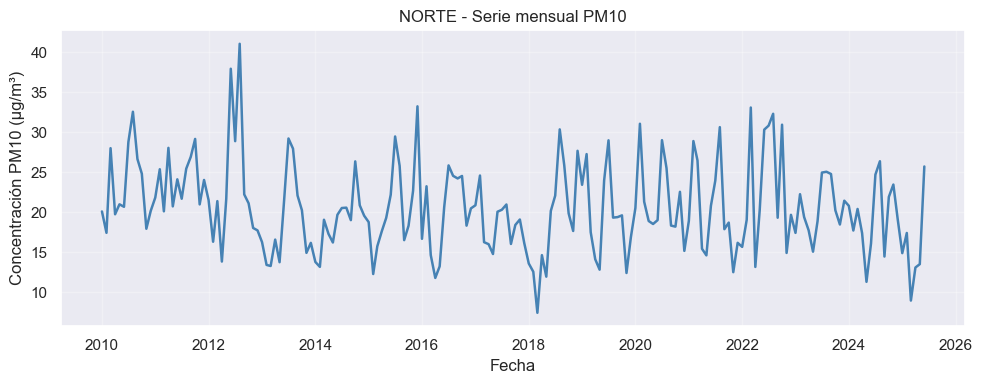


=== CENTRO ===


C:\Users\rosal\AppData\Local\Temp\ipykernel_18564\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)


📁 Guardado gráfico en: 07_Figs\01_graficos_series_mensuales_MAG10\serie_mensual_CENTRO.png


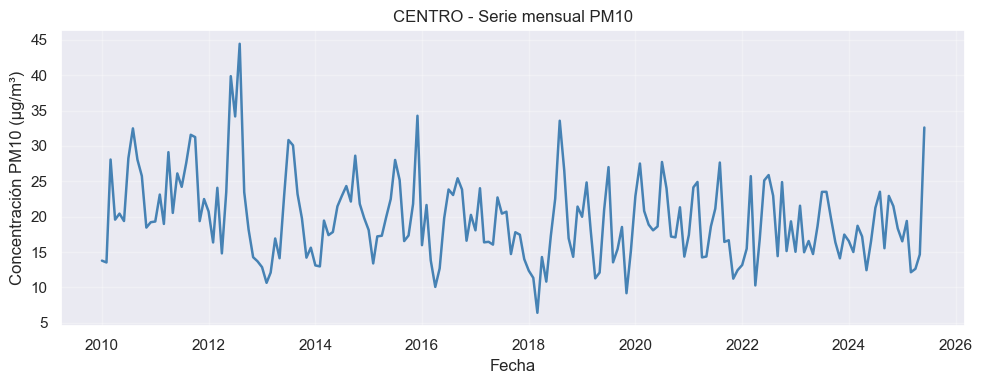


=== SUR ===


C:\Users\rosal\AppData\Local\Temp\ipykernel_18564\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)


📁 Guardado gráfico en: 07_Figs\01_graficos_series_mensuales_MAG10\serie_mensual_SUR.png


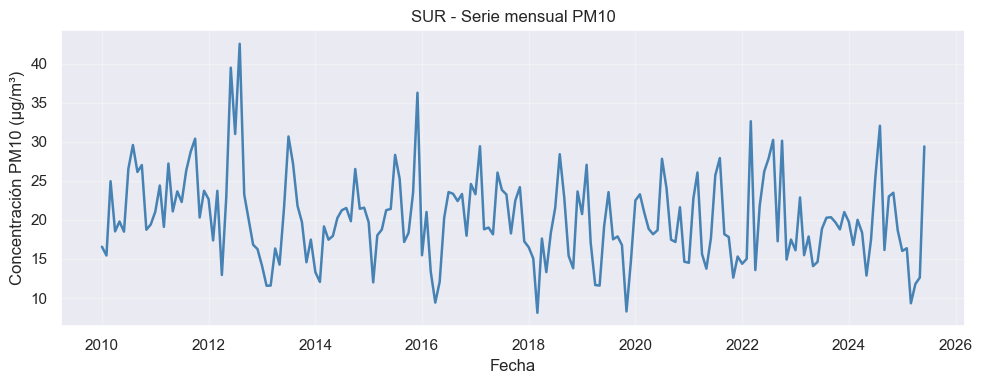

In [46]:
CARPETA_BASE = "07_Figs"
SUBCARPETA = "01_graficos_series_mensuales_MAG10"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)

# Crea la carpeta general y la subcarpeta si no existen
os.makedirs(CARPETA_SALIDA, exist_ok=True)

MAPA_MES = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4,
    "Mayo": 5, "Junio": 6, "Julio": 7, "Agosto": 8,
    "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

dfs_zonas = {
    "NORTE":  df_10_norte,
    "CENTRO": df_10_centro,
    "SUR":    df_10_sur
}

series_zonas = {}

for zona, df in dfs_zonas.items():
    print(f"\n=== {zona} ===")

    # 1. Agregación mensual
    df_mensual = agrupar_mensual(df)

    # 2. Serie temporal mensual limpia
    serie = preparar_serie_mensual(df_mensual)
    series_zonas[zona] = serie

    # 3. Definir nombre del archivo PNG
    nombre_png = os.path.join(CARPETA_SALIDA, f"serie_mensual_{zona}.png")

    # 4. Graficar y guardar sin mostrar
    plot_serie(serie, f"{zona} - Serie mensual PM10", nombre_salida=nombre_png, mostrar=True)

**TENDENCIA**

- Las tres series (NORTE, CENTRO y SUR) no muestran una tendencia clara a largo plazo. 
- Por tanto, d podrá ser igual a 0 o 1.

**ESTACIONALIDAD**

- A simple vista, NO se aprecia un patrón regular que se repita exactamente cada año.
- Las oscilaciones parecen más irregulares, con picos distribuidos en verano como vimos en el EDA.
- Esto sugiere una estacionalidad débil o no estructurada.
- Lo veremos más claramente en la gráfica ACF.  

#### 2) DIFERENCIAR (d) HASTA SERIE ESTACIONARIA

Para cada zona (NORTE, CENTRO, SUR):
- Aplicar el test de Dickey–Fuller aumentado (ADF) sobre la serie original.
- Si no es estacionaria (p > 0.05), diferenciar una vez y volver a comprobar.
- Repetir hasta alcanzar estacionariedad o un máximo de 2 diferencias. Más de 2, podría introducir ruido y generar sobreajuste.
- Guardar los gráficos: 1) Serie original, 2) Serie diferenciada (una o dos veces)

In [47]:
# -------------------------------------------------
# Configuración de carpetas
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "02_diferenciacion_ARIMA_MAG10"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# -------------------------------------------------
# Bucle principal por zona
# -------------------------------------------------
resultados_d = []

for zona, serie in series_zonas.items():
    print(f"\n=== {zona} ===")

    carpeta_zona = os.path.join(CARPETA_SALIDA, zona)
    os.makedirs(carpeta_zona, exist_ok=True)

    # Paso 1: test ADF en serie original
    p0 = test_adf(serie, f"{zona} original")
    plot_serie_diferenciada(serie, f"{zona} - Serie original", os.path.join(carpeta_zona, "serie_original.png"))

    d_opt = 0 # Inicializo iteración
    serie_dif = serie.copy()

    # Paso 2: diferenciar si no estacionaria
    while p0 > 0.05 and d_opt < 2:
        d_opt += 1 # Aumento en +1 la iteración
        serie_dif = diferencia_serie(serie, d=d_opt)
        p0 = test_adf(serie_dif, f"{zona} Δ{d_opt}")
        plot_serie_diferenciada(serie_dif, f"{zona} - Serie diferenciada Δ{d_opt}", 
                                os.path.join(carpeta_zona, f"serie_diferenciada_d{d_opt}.png"))

    # Guardar resultado
    estacionaria = "Sí" if p0 <= 0.05 else "No"
    resultados_d.append({
        "Zona": zona,
        "d_optimo": d_opt,
        "p_final": round(p0, 4),
        "Estacionaria": estacionaria
    })

# -------------------------------------------------
# Resumen final
# -------------------------------------------------
df_est = pd.DataFrame(resultados_d)
print("\n>>> RESULTADOS DIFERENCIACIÓN <<<")
print(df_est.to_string(index=False))


=== NORTE ===
ADF NORTE original: estadístico=-2.537, p-valor=0.1067
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG10\NORTE\serie_original.png
ADF NORTE Δ1: estadístico=-6.070, p-valor=0.0000
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG10\NORTE\serie_diferenciada_d1.png

=== CENTRO ===
ADF CENTRO original: estadístico=-2.389, p-valor=0.1449
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG10\CENTRO\serie_original.png
ADF CENTRO Δ1: estadístico=-5.971, p-valor=0.0000
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG10\CENTRO\serie_diferenciada_d1.png

=== SUR ===
ADF SUR original: estadístico=-3.025, p-valor=0.0326
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG10\SUR\serie_original.png

>>> RESULTADOS DIFERENCIACIÓN <<<
  Zona  d_optimo  p_final Estacionaria
 NORTE         1   0.0000           Sí
CENTRO         1   0.0000           Sí
   SUR         0   0.0326           Sí


Con lo cual se concluye que:

- Para las zonas NORTE y CENTRO, solo hace falta una diferenciación.
- Para la zona SUR, NO hace falta una NINGUNA diferenciación. Se considera estacionaria la serie original.

#### 3) EVALUAR GRÁFICOS ACF y PACF → AYUDAN A ELEGIR p y q

In [48]:
# -------------------------------------------------
# Config carpeta salida para esta fase
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "03_acf_pacf_ARIMA_MAG10"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# -------------------------------------------------
# Calculo zona por zona
# -------------------------------------------------
resumen_modelado = []

# Pasamos resultados_d (lista de dicts) a dict indexado por zona para acceso rápido
d_por_zona = {fila["Zona"]: fila["d_optimo"] for fila in resultados_d}

for zona, serie_original in series_zonas.items():
    print(f"\n=== {zona} ===")

    # 1) d óptimo encontrado en la fase anterior
    d_opt = d_por_zona[zona]

    # 2) construyo la serie estacionaria aplicando esa d
    serie_estacionaria = aplicar_diferenciacion(serie_original, d_opt)

    # 3) guardo ACF y PACF en disco
    guardar_acf_pacf(serie_estacionaria, zona, CARPETA_SALIDA, lags=49) # lag = 49 (equivalente a 4 años)

    # 4) registro info útil para elegir p y q
    resumen_modelado.append({
        "Zona": zona,
        "d": d_opt,
        "n_obs_estacionaria": len(serie_estacionaria)
    })

# 5) resumen en dataframe
df_resumen_modelado = pd.DataFrame(resumen_modelado)
print("\n>>> RESUMEN PARA ESTIMACIÓN ARIMA <<<")
print(df_resumen_modelado.to_string(index=False))


=== NORTE ===
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG10\NORTE\acf.png
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG10\NORTE\pacf.png

=== CENTRO ===
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG10\CENTRO\acf.png
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG10\CENTRO\pacf.png

=== SUR ===
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG10\SUR\acf.png
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG10\SUR\pacf.png

>>> RESUMEN PARA ESTIMACIÓN ARIMA <<<
  Zona  d  n_obs_estacionaria
 NORTE  1                 185
CENTRO  1                 185
   SUR  0                 186


<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

**INTERPRETACIÓN**

*NORTE*
- ACF: cae a 0 rápidamente después del lag 1.
- PACF: primer lag algo negativo, el resto dentro de la banda.
- Corte rápido en la ACF ⇒ posible componente MA(1).
- Decaimiento suave en la PACF ⇒ componente AR pequeña o nula.
- Candidato principal: ARIMA(0,1,1) --> posible alternativa: ARIMA(1,1,1) para comparar AIC

*CENTRO*
- ACF: muy similar al norte, sin correlaciones persistentes.
- PACF: valores pequeños, no sobresale ningún lag.
- Tanto ACF como PACF se “apagan” rápidamente → la serie diferenciada parece ruido blanco leve.
- Pero como ACF y PACF muestran algún pequeño pico inicial, probar modelos sencillos tiene sentido.
- Candidatos: ARIMA(0,1,1) y ARIMA(1,1,0)

*SUR*
- ACF: primer lag significativo positivo (r₁ ≈ 0.25), luego cae.
- PACF: también con un pico en lag 1, y luego dentro del intervalo.
- AR(1) (dependencia solo con el periodo anterior).
- Candidatos: ARIMA(1,0,0), ARIMA(1,0,1) y ARIMA (0,0,1)

#### 4) COMPARAR ARIMAS CON AIC

In [49]:
# -------------------------------------------------
# Definición de candidatos por zona
# -------------------------------------------------
candidatos_por_zona = {
    "NORTE":  [(0,1,1), (1,1,1)],
    "CENTRO": [(0,1,1), (1,1,0)],
    "SUR":    [(1,0,0), (1,0,1), (0,0,1)]
}


# -------------------------------------------------
# Bucle principal
# -------------------------------------------------
resultados_finales = []

for zona, serie in series_zonas.items():
    print(f"\n======================")
    print(f"ZONA {zona}")
    print(f"======================")

    # 1️⃣ División temporal
    train, test = train_test_split_temporal(serie, fecha_corte='2024-06-30')

    if len(test) == 0:
        print("No hay datos de test tras la fecha de corte. Se omite evaluación.")
        continue

    # 2️⃣ Evaluación de modelos candidatos
    mejor_aic = np.inf
    mejor_order = None
    mejor_ajuste = None

    for order in candidatos_por_zona[zona]:
        print(f"\nProbando ARIMA{order}...")
        aic_val, ajuste = ajustar_y_aic(train, order)

        if np.isfinite(aic_val):
            print(f"   AIC = {aic_val:.2f}")
        else:
            print("   Modelo no válido")

        if aic_val < mejor_aic:
            mejor_aic = aic_val
            mejor_order = order
            mejor_ajuste = ajuste

    # 3️⃣ Predicción en test con el mejor modelo
    if mejor_ajuste is not None:
        pred_test = mejor_ajuste.forecast(steps=len(test))
        rmse_test = evaluar_modelo(f"ARIMA{mejor_order} ({zona})", test, pred_test)
    else:
        rmse_test = np.nan

    # 4️⃣ Guardar resultados
    resultados_finales.append({
        "Zona": zona,
        "Mejor_(p,d,q)": mejor_order,
        "AIC": round(mejor_aic, 2),
        "RMSE_test": round(rmse_test, 3),
        "n_train": len(train),
        "n_test": len(test)
    })

    # Guardar info de desempeño del mejor ARIMA por zona
    tabla_rmse_modelos.append({
        "modelo": "ARIMA",
        "zona": zona,
        "order": mejor_order,
        "seasonal_order": None,
        "AIC": mejor_aic,
        "RMSE_test": rmse_test
    })


# -------------------------------------------------
# 5️⃣ Tabla resumen final
# -------------------------------------------------
df_resultados_arima = pd.DataFrame(resultados_finales)
print("\n>>> RESULTADOS ARIMA (Selección por AIC y validación en test) <<<")
print(df_resultados_arima.to_string(index=False))




ZONA NORTE

Probando ARIMA(0, 1, 1)...
   AIC = 1089.34

Probando ARIMA(1, 1, 1)...


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

   AIC = 1065.49
ARIMA(1, 1, 1) (NORTE) → RMSE: 6.049

ZONA CENTRO

Probando ARIMA(0, 1, 1)...
   AIC = 1104.08

Probando ARIMA(1, 1, 0)...
   AIC = 1108.01
ARIMA(0, 1, 1) (CENTRO) → RMSE: 6.525

ZONA SUR

Probando ARIMA(1, 0, 0)...


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

   AIC = 1069.22

Probando ARIMA(1, 0, 1)...
   AIC = 1071.01

Probando ARIMA(0, 0, 1)...
   AIC = 1075.04


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

ARIMA(1, 0, 0) (SUR) → RMSE: 7.006

>>> RESULTADOS ARIMA (Selección por AIC y validación en test) <<<
  Zona Mejor_(p,d,q)     AIC  RMSE_test  n_train  n_test
 NORTE     (1, 1, 1) 1065.49      6.049      174      12
CENTRO     (0, 1, 1) 1104.08      6.525      174      12
   SUR     (1, 0, 0) 1069.22      7.006      174      12


**MODELOS ELEGIDOS**

- NORTE: ARIMA (1, 1, 1)
- CENTRO: ARIMA (0, 1, 1)
- SUR: ARIMA (1, 0, 0)


#### 5) ENTRENAR MODELO FINAL Y GENERAR PREDICCIONES

In [50]:
# -------------------------------------------------
# Configuración de carpetas de salida
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "04_predicciones_finales_ARIMA_MAG10"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)


=== ZONA NORTE ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1) (NORTE) → RMSE: 6.049
📁 Guardado gráfico: 07_Figs\04_predicciones_finales_ARIMA_MAG10\predicciones_NORTE.png


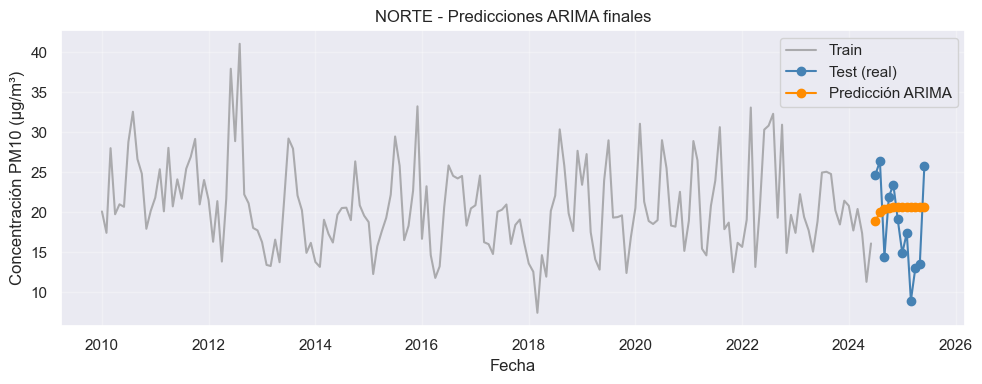


=== ZONA CENTRO ===
ARIMA(0, 1, 1) (CENTRO) → RMSE: 6.525


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


📁 Guardado gráfico: 07_Figs\04_predicciones_finales_ARIMA_MAG10\predicciones_CENTRO.png


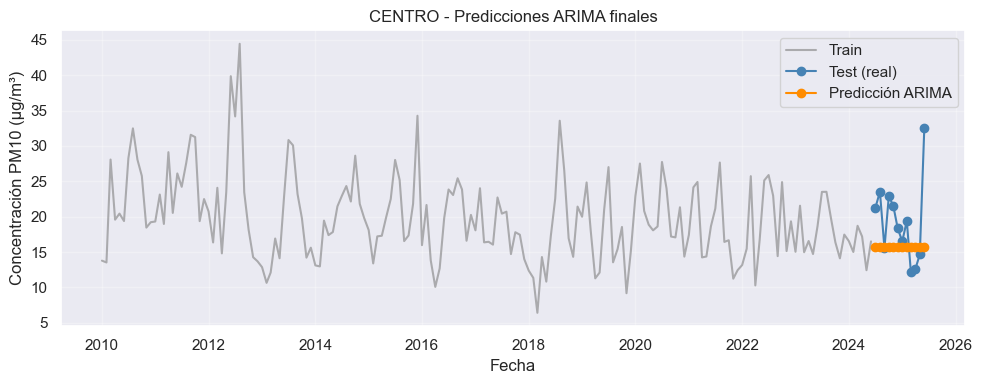


=== ZONA SUR ===
ARIMA(1, 0, 0) (SUR) → RMSE: 7.006


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


📁 Guardado gráfico: 07_Figs\04_predicciones_finales_ARIMA_MAG10\predicciones_SUR.png


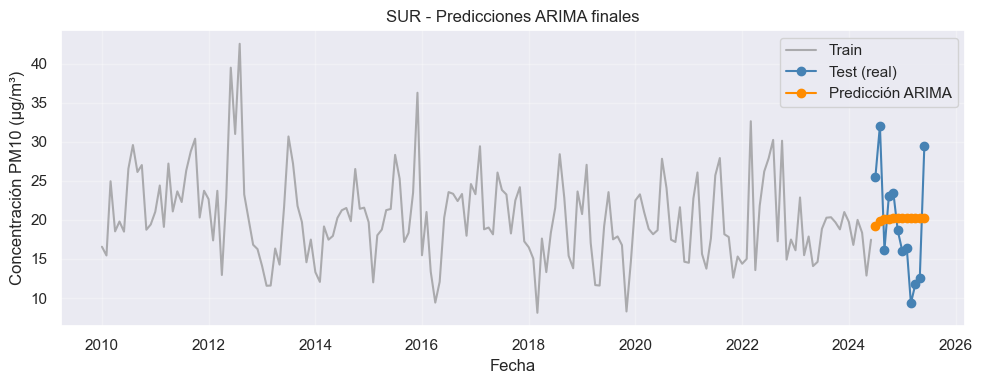


>>> RESULTADOS FINALES ARIMA <<<
  Zona ARIMA_(p,d,q)     AIC  RMSE_test  n_train  n_test
 NORTE     (1, 1, 1) 1065.49      6.049      174      12
CENTRO     (0, 1, 1) 1104.08      6.525      174      12
   SUR     (1, 0, 0) 1069.22      7.006      174      12


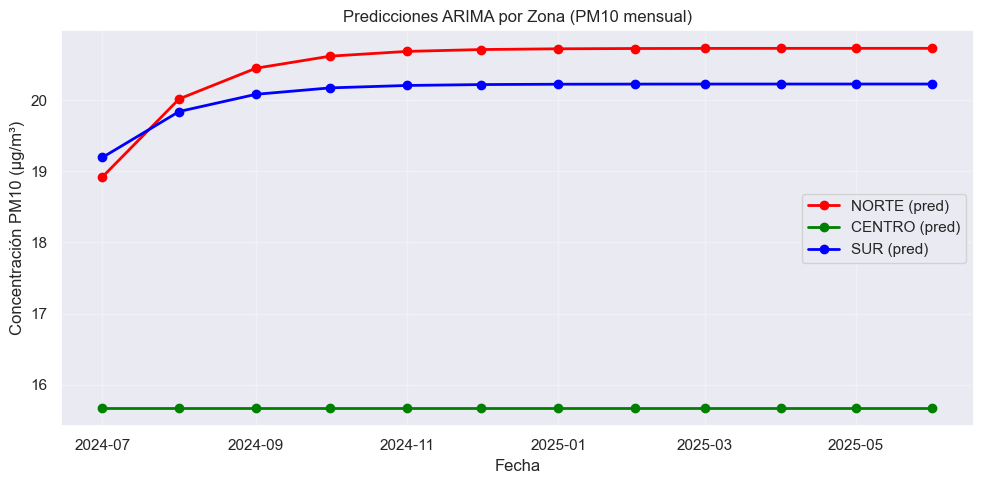


📁 Guardado gráfico combinado: 07_Figs\04_predicciones_finales_ARIMA_MAG10\predicciones_conjuntas_zonas.png


In [51]:
# -------------------------------------------------
# MODELOS FINALES (según selección previa)
# -------------------------------------------------
modelos_finales = {
    "NORTE":  (1,1,1),
    "CENTRO": (0,1,1),
    "SUR":    (1,0,0)
}

# -------------------------------------------------
# ENTRENAMIENTO Y PREDICCIONES POR ZONA
# -------------------------------------------------
resultados_pred = []
predicciones_zonas = {}

for zona, serie in series_zonas.items():
    print(f"\n=== ZONA {zona} ===")

    order = modelos_finales[zona]
    train, test = train_test_split_temporal(serie, fecha_corte="2024-06-30")

    # Entrenamiento del modelo
    modelo = ARIMA(train, order=order)
    ajuste = modelo.fit()

    # Predicción sobre el conjunto de test
    pred_test = ajuste.forecast(steps=len(test))

    # Evaluación (usando tu función)
    rmse_test = evaluar_modelo(f"ARIMA{order} ({zona})", test, pred_test)
    aic_modelo = ajuste.aic

    # Guardar y mostrar gráfico individual
    nombre_png = os.path.join(CARPETA_SALIDA, f"predicciones_{zona}.png")
    plot_predicciones(zona, train, test, pred_test, nombre_png, mostrar=True)

    # Guardar dataframe de predicciones
    predicciones_zonas[zona] = pd.DataFrame({
        "real": test.values,
        "pred": pred_test.values
    }, index=test.index)

    # Registrar resultados
    resultados_pred.append({
        "Zona": zona,
        "ARIMA_(p,d,q)": order,
        "AIC": round(aic_modelo, 2),
        "RMSE_test": round(rmse_test, 3),
        "n_train": len(train),
        "n_test": len(test)
    })

# -------------------------------------------------
# TABLA RESUMEN FINAL
# -------------------------------------------------
df_pred = pd.DataFrame(resultados_pred)
print("\n>>> RESULTADOS FINALES ARIMA <<<")
print(df_pred.to_string(index=False))

# -------------------------------------------------
# GRÁFICO CONJUNTO: PREDICCIONES DE LAS 3 ZONAS
# -------------------------------------------------
plt.figure(figsize=(10,5))

colores = {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}

for zona, df_pred in predicciones_zonas.items():
    plt.plot(df_pred.index, df_pred["pred"], marker="o", linewidth=2,
             color=colores.get(zona, None), label=f"{zona} (pred)")

plt.title("Predicciones ARIMA por Zona (PM10 mensual)")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM10 (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ruta_figura = os.path.join(CARPETA_SALIDA, "predicciones_conjuntas_zonas.png")
plt.savefig(ruta_figura, dpi=150)
plt.show()
plt.close()

print(f"\n📁 Guardado gráfico combinado: {ruta_figura}")

#### 6) PREDICCIÓN HASTA DICIEMBRE 2030 Y 2032


=== ZONA NORTE ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


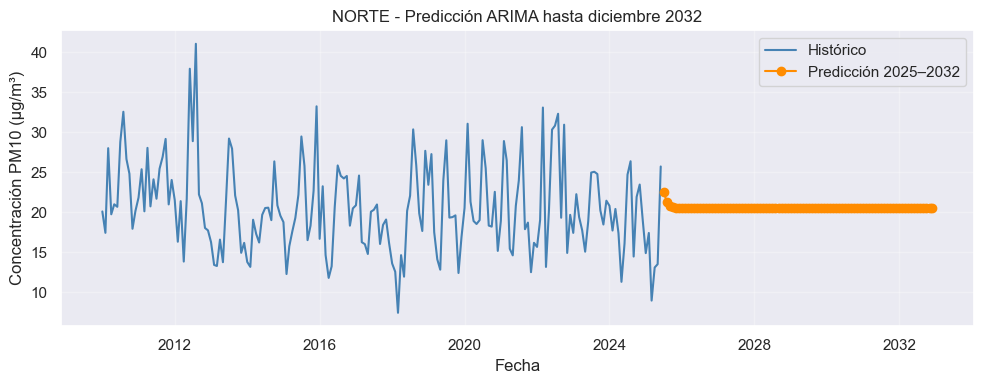

📁 Guardado gráfico: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG10\prediccion_2032_NORTE.png

=== ZONA CENTRO ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


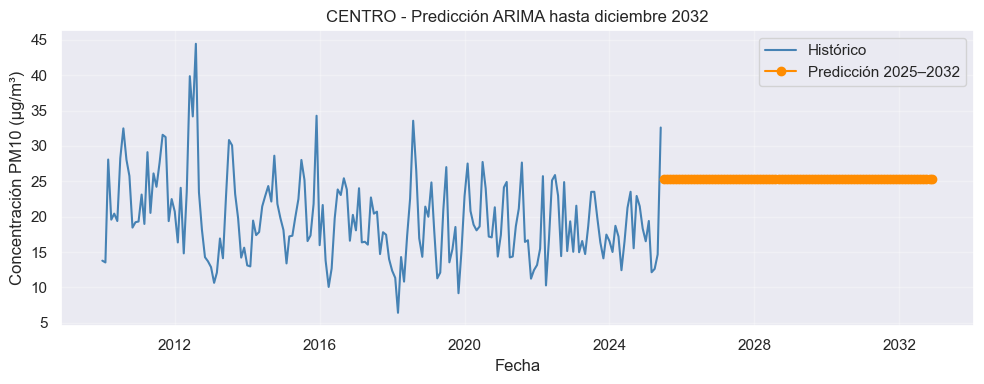

📁 Guardado gráfico: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG10\prediccion_2032_CENTRO.png

=== ZONA SUR ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


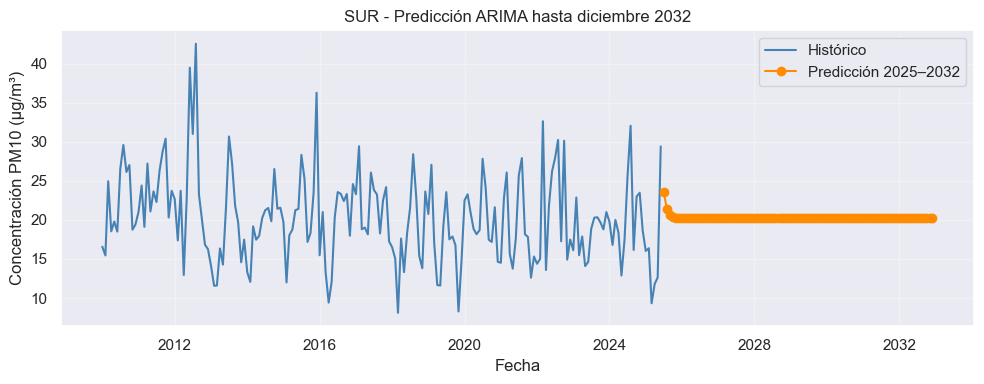

📁 Guardado gráfico: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG10\prediccion_2032_SUR.png


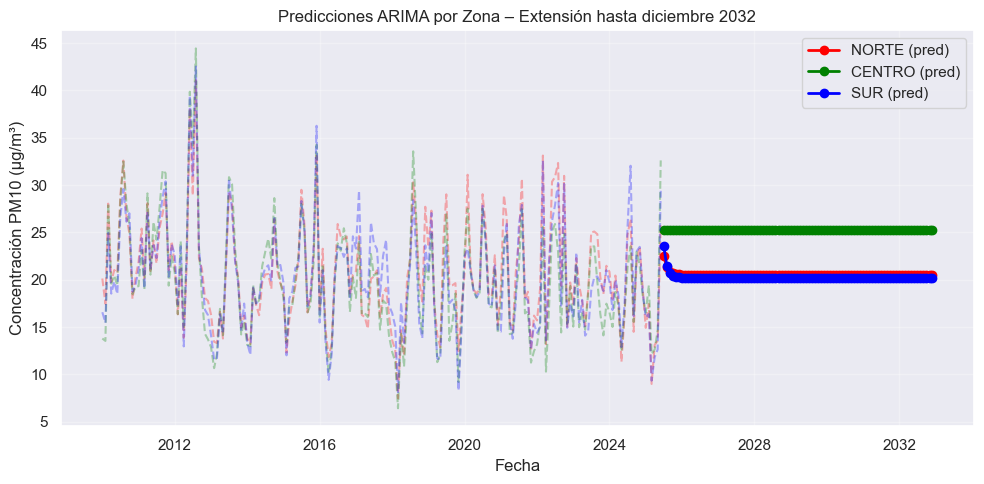


📁 Guardado gráfico combinado: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG10\predicciones_conjuntas_2032.png

📁 Guardado CSV con predicciones completas: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG10\predicciones_PM10_hasta_2032.csv

>>> ÚLTIMAS PREDICCIONES (diciembre 2032) <<<
 PM10_pred_NORTE  PM10_pred_CENTRO  PM10_pred_SUR
          20.543            25.276          20.22

>>> PREDICCIONES ANUALES (enero–diciembre 2030) <<<
            PM10_pred_NORTE  PM10_pred_CENTRO  PM10_pred_SUR
2030-01-01           20.543            25.276          20.22
2030-02-01           20.543            25.276          20.22
2030-03-01           20.543            25.276          20.22
2030-04-01           20.543            25.276          20.22
2030-05-01           20.543            25.276          20.22
2030-06-01           20.543            25.276          20.22
2030-07-01           20.543            25.276          20.22
2030-08-01           20.543            25.276          20.22
2030-09-01     

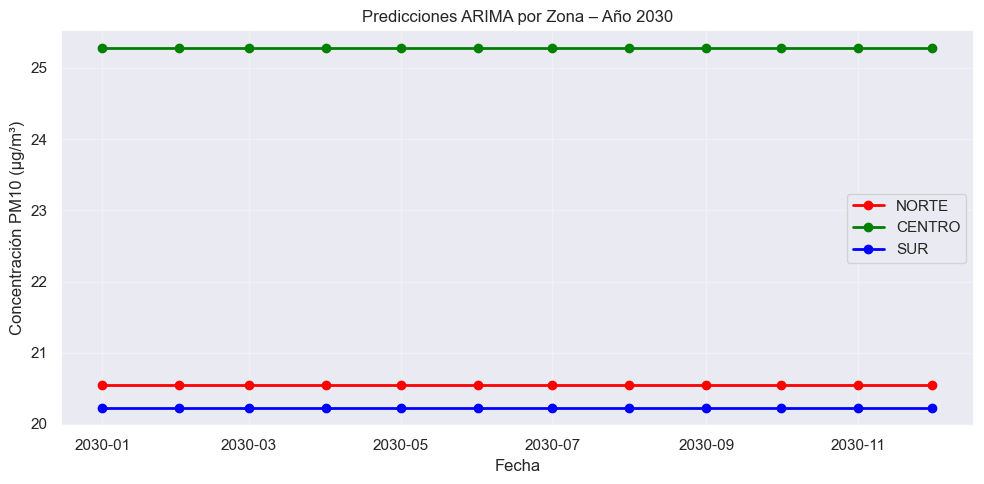


📁 Guardado gráfico 2030: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG10\predicciones_conjuntas_2030.png


In [52]:
# -------------------------------------------------
# Configuración de carpeta de salida
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "05_predicciones_largo_plazo_ARIMA_MAG10"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# -------------------------------------------------
# Modelos finales por zona (ya validados)
# -------------------------------------------------
modelos_finales = {
    "NORTE":  (1,1,1),
    "CENTRO": (0,1,1),
    "SUR":    (1,0,0)
}

# -------------------------------------------------
# Horizonte de predicción
# -------------------------------------------------
fecha_final_pred = "2032-12-31"

# -------------------------------------------------
# Bucle de predicción por zona
# -------------------------------------------------
predicciones_largo_plazo = {}

for zona, serie in series_zonas.items():
    print(f"\n=== ZONA {zona} ===")

    order = modelos_finales[zona]

    # Entrenamiento con toda la serie disponible
    modelo = ARIMA(serie, order=order)
    ajuste = modelo.fit()

    # Número de meses a predecir
    ultimo_mes = serie.index.max()
    horizonte = pd.date_range(start=ultimo_mes + pd.offsets.MonthBegin(1),
                              end=fecha_final_pred, freq="MS")
    n_steps = len(horizonte)

    # Predicción a largo plazo
    pred = ajuste.forecast(steps=n_steps)
    pred.index = horizonte

    # Guardamos los resultados
    predicciones_largo_plazo[zona] = pred

    # -------------------------------------------------
    # Gráfico por zona
    # -------------------------------------------------
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, label="Histórico", color="steelblue")
    plt.plot(pred.index, pred.values, label="Predicción 2025–2032", color="darkorange", marker="o")
    plt.title(f"{zona} - Predicción ARIMA hasta diciembre 2032")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración PM10 (µg/m³)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    ruta_png = os.path.join(CARPETA_SALIDA, f"prediccion_2032_{zona}.png")
    plt.savefig(ruta_png, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico: {ruta_png}")

# -------------------------------------------------
# Gráfico combinado (todas las zonas)
# -------------------------------------------------
plt.figure(figsize=(10,5))
colores = {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}

for zona, pred in predicciones_largo_plazo.items():
    plt.plot(pred.index, pred.values, color=colores[zona], linewidth=2, marker="o", label=f"{zona} (pred)")
    plt.plot(series_zonas[zona].index, series_zonas[zona].values, color=colores[zona], alpha=0.3, linestyle="--")

plt.title("Predicciones ARIMA por Zona – Extensión hasta diciembre 2032")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM10 (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ruta_figura = os.path.join(CARPETA_SALIDA, "predicciones_conjuntas_2032.png")
plt.savefig(ruta_figura, dpi=150)
plt.show()
plt.close()

print(f"\n📁 Guardado gráfico combinado: {ruta_figura}")

# -------------------------------------------------
# Tabla resumen de predicciones finales
# -------------------------------------------------
df_pred_2032 = pd.concat(predicciones_largo_plazo, axis=1)
df_pred_2032.columns = [f"PM10_pred_{zona}" for zona in df_pred_2032.columns]

# Guardar CSV con todas las predicciones
csv_path = os.path.join(CARPETA_SALIDA, "predicciones_PM10_hasta_2032.csv")
df_pred_2032.to_csv(csv_path)
print(f"\n📁 Guardado CSV con predicciones completas: {csv_path}")

print("\n>>> ÚLTIMAS PREDICCIONES (diciembre 2032) <<<")
print(df_pred_2032.tail(1).round(3).to_string(index=False))

# -------------------------------------------------
# PREDICCIONES DEL AÑO 2030
# -------------------------------------------------
# Filtrar las filas correspondientes a 2030
df_pred_2030 = df_pred_2032[df_pred_2032.index.year == 2030]

print("\n>>> PREDICCIONES ANUALES (enero–diciembre 2030) <<<")
print(df_pred_2030.round(3).to_string())

# Guardar CSV con predicciones 2030
csv_2030_path = os.path.join(CARPETA_SALIDA, "predicciones_PM10_2030.csv")
df_pred_2030.to_csv(csv_2030_path)
print(f"\n📁 Guardado CSV con predicciones de 2030: {csv_2030_path}")

# -------------------------------------------------
# Promedio anual de 2030 por zona
# -------------------------------------------------
promedios_2030 = df_pred_2030.mean().round(3)
print("\n>>> PROMEDIO ANUAL PREVISTO PARA 2030 (µg/m³) <<<")
print(promedios_2030)

# Volcado de predicciones ARIMA 2030 en tabla global
for zona in ["NORTE", "CENTRO", "SUR"]:
    # Para cada zona tenemos la serie mensual 2030: df_pred_2030[f"PM10_pred_{zona}"]
    serie_zona_2030 = df_pred_2030[f"PM10_pred_{zona}"]

    for fecha, valor_predicho in serie_zona_2030.items():
        tabla_predicciones_2030.append({
            "modelo": "ARIMA",
            "zona": zona,
            "fecha": fecha,                   # índice tipo Timestamp
            "anio": fecha.year,               # 2030
            "mes": fecha.month,               # 1..12
            "pred_2030": valor_predicho,      # µg/m³
            "promedio_anual_2030": promedios_2030[f"PM10_pred_{zona}"]
        })

# -------------------------------------------------
# Gráfico conjunto de las tres zonas – año 2030
# -------------------------------------------------
plt.figure(figsize=(10,5))
for zona, color in {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}.items():
    plt.plot(df_pred_2030.index, df_pred_2030[f"PM10_pred_{zona}"], marker="o",
             linewidth=2, color=color, label=zona)

plt.title("Predicciones ARIMA por Zona – Año 2030")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM10 (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ruta_figura_2030 = os.path.join(CARPETA_SALIDA, "predicciones_conjuntas_2030.png")
plt.savefig(ruta_figura_2030, dpi=150)
plt.show()
plt.close()

print(f"\n📁 Guardado gráfico 2030: {ruta_figura_2030}")

#### 7) RESUMEN METODOLÓGICO

1.	Se representa la serie temporal de concentración de partículas y se inspecciona visualmente la presencia de tendencia y patrones repetitivos (estacionalidad).
2.	Se aplica diferenciación sucesiva y se contrasta con el test ADF hasta obtener una serie estacionaria. Ese número de diferenciaciones se toma como el parámetro d del modelo ARIMA(p,d,q).
3.	Sobre la serie estacionaria se analizan las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF). Los cortes significativos en PACF sugieren candidatos para p, y en ACF para q.
4.	Con esos candidatos se ajustan distintos modelos ARIMA(p,d,q) sobre el conjunto de entrenamiento y se selecciona el modelo con menor AIC, ya que el AIC penaliza la complejidad del modelo y favorece especificaciones parsimoniosas.
5.	El modelo ARIMA seleccionado se entrena con los datos históricos (train) y se utiliza para predecir el tramo de prueba (test).
6.	El rendimiento predictivo se evalúa con métricas fuera de muestra como RMSE.
7.  En base a los modelos óptimos obtenidos, se extraen los gráficos de predicción hasta 2030 y 2032.

#### 8) CONCLUSION

Los gráficos de predicción a largo plazo son planos, sin apenas estacionalidad ni tendencia visible a partir de 2025. Esto es un síntoma clásico de que los modelos ARIMA que elegimos están sobreajustados al ruido a corto plazo o que la diferenciación eliminó completamente la estructura temporal.

Es, por ello, por lo que vamos a aolizar modelos SARIMA que permite oscilaciones en el horizonte largo.

### MODELO SARIMA (Seasonal ARIMA)

El modelo SARIMA (Seasonal AutoRegressive Integrated Moving Average) es una extensión del modelo ARIMA diseñada específicamente para manejar datos de series temporales que presentan patrones estacionales. Su notación completa es:

*SARIMA(p,d,q)(P,D,Q,s)*

- 𝑝, 𝑑, 𝑞 --> Componentes no estacionales. Permite captar tendencias a corto plazo.
- P, D, Q --> componentes estacionales. Permite captar patrones estacionales.
- s --> Periodicidad de la estacionalidad (12 para datos mensuales).

Para la parte estacional (P, D, Q) tomaré siguientes valores para las tres zonas y observaré si existe o no mejoras sobre el ARIMA:

- “D = 1”: diferenciación anual: Ya que la serie tiene un patrón repetitivo anual. Diferenciar a lag=12 elimina la componente estacional fija y deja solo la variabilidad interanual.
- “P = 1”: Ya que los valores depende de valores pasados en el mismo mes del año anterior
- “Q = 1”: Ide justificación que P. Corrige errores de predicción estacionales.

De modo que:



=== ZONA NORTE ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


NORTE (test) → RMSE: 4.360


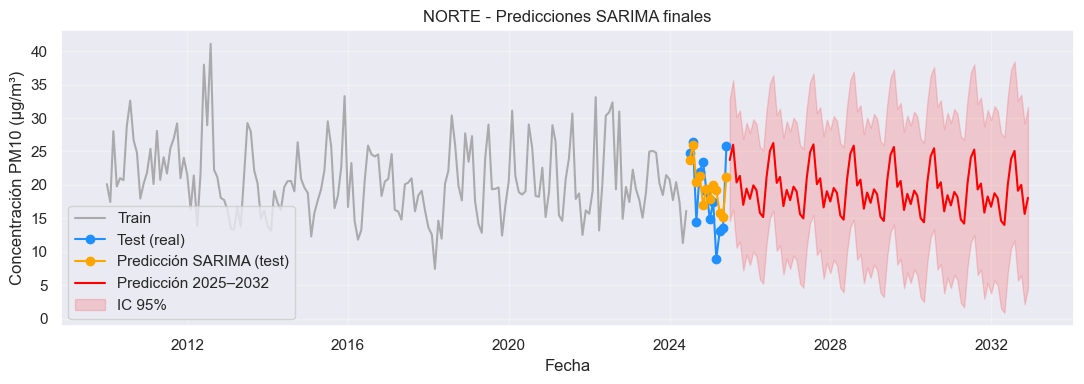

📁 Guardado gráfico: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG10\SARIMA_predicciones_NORTE.png

=== ZONA CENTRO ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


CENTRO (test) → RMSE: 5.137


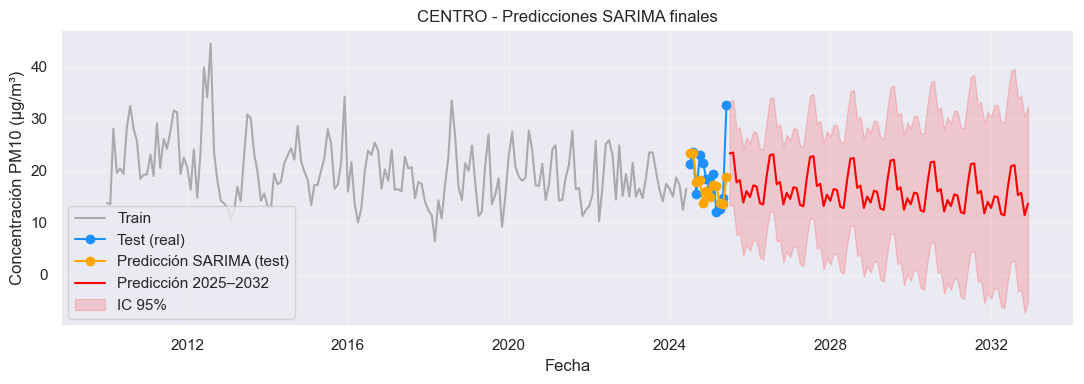

📁 Guardado gráfico: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG10\SARIMA_predicciones_CENTRO.png

=== ZONA SUR ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SUR (test) → RMSE: 5.207


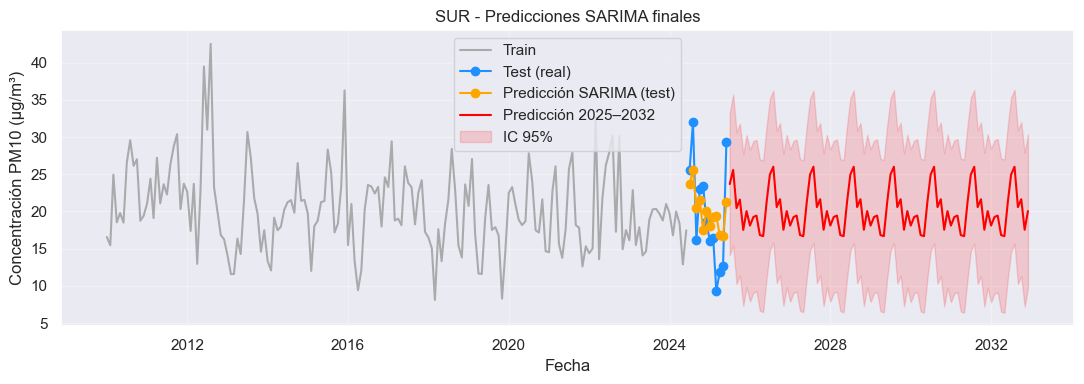

📁 Guardado gráfico: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG10\SARIMA_predicciones_SUR.png

📁 Guardado CSV: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG10\SARIMA_predicciones_PM10_hasta_2032.csv

>>> PREDICCIÓN DICIEMBRE 2032 (SARIMA) <<<
 PM10_pred_NORTE  PM10_pred_CENTRO  PM10_pred_SUR
          18.087            13.648          20.05

📁 Guardado CSV 2030: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG10\SARIMA_predicciones_PM10_2030.csv

>>> PROMEDIOS ANUALES 2030 (SARIMA) <<<
PM10_pred_NORTE     19.073
PM10_pred_CENTRO    15.768
PM10_pred_SUR       20.197
dtype: float64


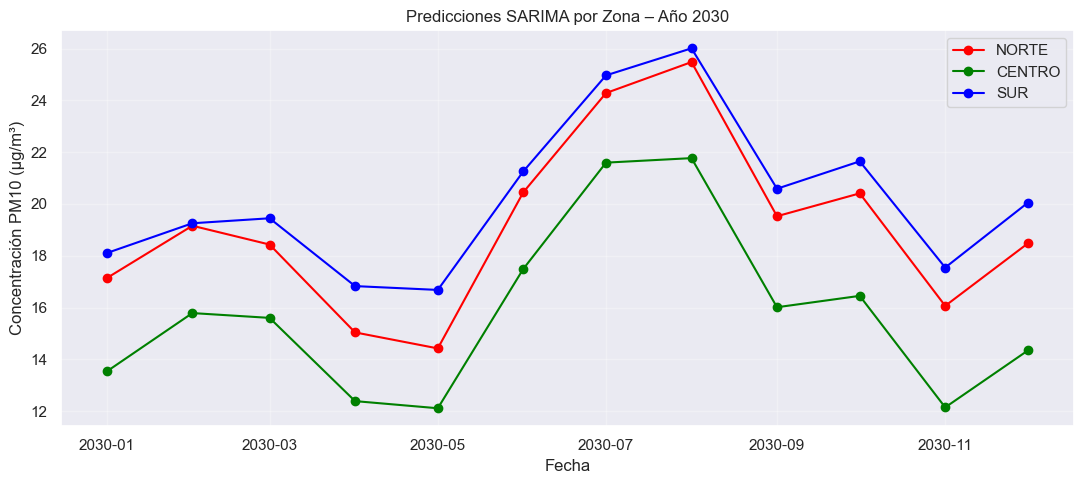

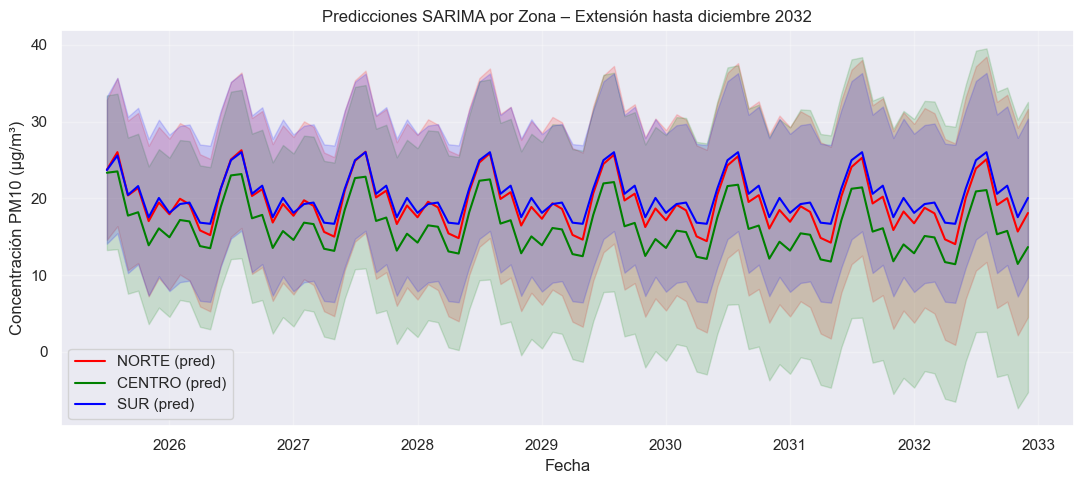


>>> RESUMEN MODELOS SARIMA (AIC y RMSE) <<<
  Zona     order seasonal_order    AIC  RMSE_test  n_obs  RMSE_test_ARIMA
 NORTE (1, 1, 1)  (1, 1, 1, 12) 891.94      4.360    186            6.049
CENTRO (0, 1, 1)  (1, 1, 1, 12) 915.12      5.137    186            6.525
   SUR (1, 0, 0)  (1, 1, 1, 12) 916.32      5.207    186            7.006


In [53]:

# =================================================
# 1. CONFIGURACIÓN DE CARPETAS
# =================================================
CARPETA_BASE = "07_Figs"
SUBCARPETA = "06_predicciones_largo_plazo_SARIMA_MAG10"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# ==========================================================
# 3️⃣ Definir modelos SARIMA por zona
# ==========================================================
modelos_sarima = {
    "NORTE":  {"order": (1,1,1), "seasonal_order": (1,1,1,12)},
    "CENTRO": {"order": (0,1,1), "seasonal_order": (1,1,1,12)},
    "SUR":    {"order": (1,0,0), "seasonal_order": (1,1,1,12)}
}

# ==========================================================
# 4️⃣ Horizonte de predicción
# ==========================================================
fecha_final_pred = "2032-12-31"
fecha_corte = "2024-06-30"  # corte temporal para evaluar RMSE

# ==========================================================
# 5️⃣ Bucle por zona: entrenar, evaluar, predecir largo plazo
# ==========================================================
predicciones_largo_plazo = {}
resultados_info = []

for zona, serie in series_zonas.items():
    print(f"\n=== ZONA {zona} ===")

    # Dividir train/test
    train = serie.loc[:fecha_corte]
    test = serie.loc[fecha_corte:]

    order = modelos_sarima[zona]["order"]
    seasonal_order = modelos_sarima[zona]["seasonal_order"]

    # --------------------------
    # Ajustar SARIMA
    # --------------------------
    modelo = SARIMAX(
        train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    ajuste = modelo.fit(disp=False)

    # --------------------------
    # Predicción sobre test
    # --------------------------
    pred_test = ajuste.get_forecast(steps=len(test))
    pred_mean = pred_test.predicted_mean
    rmse = evaluar_modelo(f"{zona} (test)", test, pred_mean)

    # Guardar RMSE SARIMA por zona
  # Guardar RMSE SARIMA por zona
    tabla_rmse_modelos.append({
        "modelo": "SARIMA",
        "zona": zona,
        "order": order,
        "seasonal_order": seasonal_order,
        "AIC": round(ajuste.aic, 2),
        "RMSE_test": rmse
    })

    # --------------------------
    # Predicción a largo plazo (2025–2032)
    # --------------------------
    ultimo_mes = serie.index.max()
    horizonte = pd.date_range(
        start=ultimo_mes + pd.offsets.MonthBegin(1),
        end=fecha_final_pred,
        freq="MS"
    )
    n_steps = len(horizonte)
    forecast_res = ajuste.get_forecast(steps=n_steps)

    pred_media = forecast_res.predicted_mean
    ic = forecast_res.conf_int(alpha=0.05)
    pred_media.index = horizonte
    ic.index = horizonte
    ic.columns = ["ic_inf", "ic_sup"]

    # Guardar resultados
    df_pred = pd.DataFrame({
        "pred": pred_media,
        "ic_inf": ic["ic_inf"],
        "ic_sup": ic["ic_sup"]
    })
    predicciones_largo_plazo[zona] = df_pred

    # --------------------------
    # Información de modelo
    # --------------------------
    resultados_info.append({
        "Zona": zona,
        "order": order,
        "seasonal_order": seasonal_order,
        "AIC": round(ajuste.aic, 2),
        "RMSE_test": round(rmse, 3),
        "n_obs": len(serie)
    })

    # --------------------------
    # Gráfico por zona
    # --------------------------
    plt.figure(figsize=(11,4))
    plt.plot(train.index, train.values, color="gray", alpha=0.6, label="Train")
    plt.plot(test.index, test.values, color="dodgerblue", marker="o", label="Test (real)")
    plt.plot(pred_mean.index, pred_mean.values, color="orange", marker="o", label="Predicción SARIMA (test)")

    plt.plot(df_pred.index, df_pred["pred"], color="red", linewidth=1.5, label="Predicción 2025–2032")
    plt.fill_between(df_pred.index, df_pred["ic_inf"], df_pred["ic_sup"], color="red", alpha=0.15, label="IC 95%")

    plt.title(f"{zona} - Predicciones SARIMA finales")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración PM10 (µg/m³)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    ruta_png = os.path.join(CARPETA_SALIDA, f"SARIMA_predicciones_{zona}.png")
    plt.savefig(ruta_png, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico: {ruta_png}")

# ==========================================================
# 6️⃣ Resumen de predicciones largo plazo
# ==========================================================
df_pred_all = pd.concat(
    {zona: predicciones_largo_plazo[zona]["pred"] for zona in predicciones_largo_plazo},
    axis=1
)
df_pred_all.columns = [f"PM10_pred_{zona}" for zona in df_pred_all.columns]

# Guardar CSV
csv_todo = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_PM10_hasta_2032.csv")
df_pred_all.to_csv(csv_todo)
print(f"\n📁 Guardado CSV: {csv_todo}")

# Última fila (dic 2032)
print("\n>>> PREDICCIÓN DICIEMBRE 2032 (SARIMA) <<<")
print(df_pred_all.tail(1).round(3).to_string(index=False))

# ==========================================================
# 7️⃣ Predicciones 2030 + Promedio anual
# ==========================================================
df_pred_2030 = df_pred_all[df_pred_all.index.year == 2030]
promedios_2030 = df_pred_2030.mean().round(3)

# Volcado de predicciones SARIMA 2030 en tabla global
for zona in ["NORTE", "CENTRO", "SUR"]:
    serie_zona_2030 = df_pred_2030[f"PM10_pred_{zona}"]

    for fecha, valor_predicho in serie_zona_2030.items():
        tabla_predicciones_2030.append({
            "modelo": "SARIMA",
            "zona": zona,
            "fecha": fecha,
            "anio": fecha.year,
            "mes": fecha.month,
            "pred_2030": valor_predicho,
            "promedio_anual_2030": promedios_2030[f"PM10_pred_{zona}"]
        })

csv_2030 = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_PM10_2030.csv")
df_pred_2030.to_csv(csv_2030)
print(f"\n📁 Guardado CSV 2030: {csv_2030}")

print("\n>>> PROMEDIOS ANUALES 2030 (SARIMA) <<<")
print(promedios_2030)

# ==========================================================
# 8️⃣ Gráfico conjunto 2030
# ==========================================================
plt.figure(figsize=(11,5))
colores = {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}

for zona, color in colores.items():
    plt.plot(df_pred_2030.index, df_pred_2030[f"PM10_pred_{zona}"], color=color, marker="o", label=zona)

plt.title("Predicciones SARIMA por Zona – Año 2030")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM10 (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

ruta_fig_2030 = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_conjuntas_2030.png")
plt.savefig(ruta_fig_2030, dpi=150)
plt.show()

# ==========================================================
# 9️⃣ Gráfico conjunto 2032 (predicciones largas)
# ==========================================================
plt.figure(figsize=(11,5))
for zona, color in colores.items():
    df_z = predicciones_largo_plazo[zona]
    plt.plot(df_z.index, df_z["pred"], color=color, label=f"{zona} (pred)")
    plt.fill_between(df_z.index, df_z["ic_inf"], df_z["ic_sup"], color=color, alpha=0.15)

plt.title("Predicciones SARIMA por Zona – Extensión hasta diciembre 2032")
plt.xlabel("Fecha")
plt.ylabel("Concentración PM10 (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

ruta_fig_2032 = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_conjuntas_2032.png")
plt.savefig(ruta_fig_2032, dpi=150)
plt.show()

# ==========================================================
# 🔟 Tabla resumen modelos (AIC, RMSE, etc.)
# ==========================================================

df_info = pd.DataFrame(resultados_info)
df_info ["RMSE_test_ARIMA"]=df_resultados_arima ["RMSE_test"]
print("\n>>> RESUMEN MODELOS SARIMA (AIC y RMSE) <<<")
print(df_info.to_string(index=False))

**CONCLUSIÓN:** Se comprueba que la predicción SARIMA mejora a la ARIMA, ya que el RMSE_test es más bajo

### MODELOS MACHINE LEARNING (CASTBOOST, LightGBM y XGBOOST)

Los modelos aplicados anteriormente (ARIMA/SARIMA) son modelos clásicos que aprenden la dinámica temporal interna de la serie directamente (usa rezagos, diferencias, estacionalidad). Sin embargo, en estos modelos no hemos considerado ninguna otra variable exógena, hemos hecho el análisis univariante sin más.

Los modelos de Machine Learning como CatBoost, LightGBM y XGBoost se basan en el algoritmo de Gradient Boosting y se caracterizan por lo siguiente:

- Son modelos supervisados de regresión tabular. Es decir: Son modelos que aprende a predecir una variable numérica continua a partir de datos estructurados en forma de tabla, usando un conjunto de datos donde ya se conoce el valor objetivo y contra lo que compararemos una vez el modelo haya porcedido a la predicción.
- Se debe construir el dataset: cada fila = un mes, con variables explicativas, y objetivo.
- No entienden por sí mismos la secuencia temporal. Se las tenemos que dar tú mediante: 1) lags (valores anteriores), 2) medias móviles, 3) mes del año, 4) tendencia temporal, 5) variables exógenas

**DIFERENCIAS ENTRE CASTBOOST, LightGBM y XGBOOST**

- *CatBoost*: Ideal cuando tienes muchas variables categóricas. Evita el preprocesamiento manual y es muy estable con pocos datos.
- *LightGBM*: Perfecto para grandes volúmenes de datos. Usa una estrategia de crecimiento por hojas (leaf-wise) que acelera el entrenamiento y mejora la precisión, aunque puede sobreajustar si no se regula.
- *XGBoost*: El más veterano y versátil. Rendimiento sólido y facilidad de ajuste.


#### 1) DEFINIR OBJETIVO

En este apartado sólo vamos a definir la parte de los datos que luego vamos a predecir.

In [54]:
objetivos_por_zona = {}

for zona, serie in series_zonas.items():
    # Aseguramos nombre claro
    serie_objetivo = serie.copy()
    serie_objetivo.name = "PM10_objetivo"

    # Aseguramos que el índice sea DatetimeIndex mensual ordenado
    serie_objetivo = serie_objetivo.sort_index()
    if not isinstance(serie_objetivo.index, pd.DatetimeIndex):
        raise ValueError(f"La serie de {zona} no tiene un DatetimeIndex. Revisa preparar_serie_mensual().")

    # Guardamos para futuros pasos
    objetivos_por_zona[zona] = serie_objetivo

    # Mostramos un pequeño resumen para inspección
    print(f"\n=== {zona} ===")
    print("Primeras filas:")
    print(serie_objetivo.head())
    print("Últimas filas:")
    print(serie_objetivo.tail())
    print(f"Rango temporal: {serie_objetivo.index.min().date()} -> {serie_objetivo.index.max().date()}")
    print(f"Nº de observaciones mensuales: {len(serie_objetivo)}")



=== NORTE ===
Primeras filas:
fecha
2010-01-01    20.129032
2010-02-01    17.458333
2010-03-01    28.037634
2010-04-01    19.777778
2010-05-01    21.021505
Name: PM10_objetivo, dtype: float64
Últimas filas:
fecha
2025-02-01    17.440476
2025-03-01     8.989247
2025-04-01    13.124026
2025-05-01    13.543011
2025-06-01    25.750000
Name: PM10_objetivo, dtype: float64
Rango temporal: 2010-01-01 -> 2025-06-01
Nº de observaciones mensuales: 186

=== CENTRO ===
Primeras filas:
fecha
2010-01-01    13.790323
2010-02-01    13.535714
2010-03-01    28.080645
2010-04-01    19.583333
2010-05-01    20.435484
Name: PM10_objetivo, dtype: float64
Últimas filas:
fecha
2025-02-01    19.398810
2025-03-01    12.150538
2025-04-01    12.631985
2025-05-01    14.666667
2025-06-01    32.605556
Name: PM10_objetivo, dtype: float64
Rango temporal: 2010-01-01 -> 2025-06-01
Nº de observaciones mensuales: 186

=== SUR ===
Primeras filas:
fecha
2010-01-01    16.569892
2010-02-01    15.452381
2010-03-01    24.946237


#### 2) CONSTRUCCIÓN DATASETS ENTRENAMIENTO/TEST/VALIDACIÓN

In [55]:
# ================================================================
# 0️⃣ Definición de variables relevantes (ya identificadas)
# ================================================================
variables_interes = [
    "ZONA_ESTACION",
    "TEMPERATURA_MAX (°C)", "TEMPERATURA_MIN (°C)", "TEMPERATURA_MED (°C)",
    "month", "dow",
    "PRESION_MED (hPa)",
    "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)",
    "VIENTO_DIR_100 (°)", "NIEVE (cm)",
    "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)",
    "VIENTO_MED_10 (km/h)", "VIENTO_DIR_10 (°)"
]

# ================================================================
# 1️⃣ Filtrar cada dataframe por las variables de interés + objetivo + fecha
# ================================================================
dfs_filtrados = {}

for zona, df in {
    "NORTE":  df_10_norte,
    "CENTRO": df_10_centro,
    "SUR":    df_10_sur
}.items():
    
    # Asegurar que todas las variables existen en el DataFrame original
    columnas_presentes = [col for col in variables_interes if col in df.columns]
    
    # ⚠️ Añadimos explícitamente la columna de fecha y la de objetivo
    columnas_finales = ["DIA/MES/ANO"] + columnas_presentes + ["MEDICION_ugm3"]
    
    # Selección
    df_sel = df[columnas_finales].copy()
    dfs_filtrados[zona] = df_sel

    print(f"✅ {zona}: seleccionadas {len(columnas_finales)} columnas ({len(df_sel)} filas)")

# ================================================================
# 2️⃣ Agregar mensualmente y preparar las series
# ================================================================
series_zonas_filtradas = {}
df_mensuales = {}

for zona, df_sel in dfs_filtrados.items():
    # Convertir a mensual (ya tienes definida la función agrupar_mensual)
    df_mensual = agrupar_mensual(df_sel)
    df_mensuales[zona] = df_mensual

    # Crear la serie objetivo mensual (PM10)
    serie = preparar_serie_mensual(df_mensual)
    series_zonas_filtradas[zona] = serie

    print(f"📆 {zona}: serie mensual con {len(serie)} observaciones")

✅ NORTE: seleccionadas 18 columnas (5660 filas)
✅ CENTRO: seleccionadas 18 columnas (5660 filas)
✅ SUR: seleccionadas 18 columnas (5660 filas)
📆 NORTE: serie mensual con 186 observaciones
📆 CENTRO: serie mensual con 186 observaciones
📆 SUR: serie mensual con 186 observaciones


C:\Users\rosal\AppData\Local\Temp\ipykernel_18564\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)
C:\Users\rosal\AppData\Local\Temp\ipykernel_18564\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)
C:\Users\rosal\AppData\Local\Temp\ipykernel_18564\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warn

In [56]:
display (df_mensuales["NORTE"].head())

year month  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
0  2010     1              8.300674              2.246803   
1  2010     2              9.791077              2.360006   
2  2010     3             13.348739              3.834867   
3  2010     4             19.092911              7.813911   
4  2010     5             21.406803              9.214868   

   TEMPERATURA_MED (°C)  PRESION_MED (hPa)  VIENTO_MAX_100 (km/h)  \
0              5.201117        1016.239386              23.647792   
1              5.964054        1009.038979              26.963421   
2              8.542018        1017.773782              24.037271   
3             13.493216        1016.500822              18.764531   
4             15.726601        1014.977818              22.873719   

   VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  VIENTO_DIR_100 (°)  \
0               8.178825              15.876356          198.033332   
1              10.449815              17.915136          180.164913   
2               8.410951              16.551365          162.194312   
3               5.250311              11.648427          163.453831   
4               7.084341              14.889930          212.431117   

   NIEVE (cm)  VIENTO_MAX_10 (km/h)  VIENTO_MIN_10 (km/h)  \
0    0.270968             14.340400              4.180482   
1    0.310000             16.358562              5.767762   
2    0.106129             15.296000              4.599551   
3    0.000000             11.323457              3.393302   
4    0.000000             14.734358              3.921244   

   VIENTO_MED_10 (km/h)  VIENTO_DIR_10 (°)  MEDICION_ugm3  
0              8.994496         189.496251      20.129032  
1             10.475022         177.580082      17.458333  
2              9.952272         181.653800      28.037634  
3              7.213985         157.378782      19.777778  
4              9.211280         216.816734      21.021505

In [57]:
# Definimos qué columnas exógenas queremos usar como features
columnas_exogenas_para_ML = [
    "TEMPERATURA_MAX (°C)", "TEMPERATURA_MIN (°C)", "TEMPERATURA_MED (°C)",
    "PRESION_MED (hPa)",
    "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)",
    "VIENTO_DIR_100 (°)", "NIEVE (cm)",
    "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)",
    "VIENTO_MED_10 (km/h)", "VIENTO_DIR_10 (°)"
]

Xtr_zona = {}
ytr_zona = {}
Xte_zona = {}
yte_zona = {}
df_ml_zona = {}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== Preparando datos ML para {zona} ===")
    df_mensual_zona = df_mensuales[zona]

    X_train, y_train, X_test, y_test, df_ml = preparar_datos_ml(
        df_mensual_zona,
        fecha_corte="2024-06-30",
        lags=[1,2,3,12],
        usar_columnas_exogenas=columnas_exogenas_para_ML
    )

    Xtr_zona[zona] = X_train
    ytr_zona[zona] = y_train
    Xte_zona[zona] = X_test
    yte_zona[zona] = y_test
    df_ml_zona[zona] = df_ml

    display(df_ml.head(20))  # inspección rápida



=== Preparando datos ML para NORTE ===
📆 Corte temporal 2024-06-30: train=162 / test=12


year month  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
fecha                                                                
2011-01-01  2011     1              9.496481              2.277125   
2011-02-01  2011     2             13.810006              1.705720   
2011-03-01  2011     3             14.234545              5.007448   
2011-04-01  2011     4             21.499577              9.771911   
2011-05-01  2011     5             23.980674             12.213255   
2011-06-01  2011     6             28.702244             15.055577   
2011-07-01  2011     7             31.494868             16.974545   
2011-08-01  2011     8             32.294868             18.175513   
2011-09-01  2011     9             29.145577             14.059244   
2011-10-01  2011    10             23.656803              9.247126   
2011-11-01  2011    11             14.542577              7.218910   
2011-12-01  2011    12             11.658738              1.448416   
2012-01-01  2012     1             11.529061             -0.504487   
2012-02-01  2012     2             11.970474             -1.802975   
2012-03-01  2012     3             18.041642              2.938093   
2012-04-01  2012     4             15.528244              6.195911   
2012-05-01  2012     5             25.143900             11.470674   
2012-06-01  2012     6             30.303244             16.249244   
2012-07-01  2012     7             32.805191             16.921642   
2012-08-01  2012     8             33.197449             17.684545   

            TEMPERATURA_MED (°C)  PRESION_MED (hPa)  VIENTO_MAX_100 (km/h)  \
fecha                                                                        
2011-01-01              5.495190        1020.064390              19.518586   
2011-02-01              7.356256        1021.274245              21.721436   
2011-03-01              9.454518        1018.846462              21.138403   
2011-04-01             15.633633        1015.271382              20.787128   
2011-05-01             18.259344        1017.173528              19.845443   
2011-06-01             22.238396        1015.933192              21.818357   
2011-07-01             24.635419        1013.183320              25.171246   
2011-08-01             25.422475        1014.010205              22.824008   
2011-09-01             21.786064        1017.167352              18.710810   
2011-10-01             16.193712        1019.334924              22.099152   
2011-11-01             10.517646        1017.716953              20.695121   
2011-12-01              5.693402        1027.714645              19.097476   
2012-01-01              4.543591        1027.351060              17.795046   
2012-02-01              4.559353        1025.356753              24.568927   
2012-03-01             10.557421        1024.289924              20.805441   
2012-04-01             10.879258        1010.258210              25.993544   
2012-05-01             18.689747        1015.462732              22.577838   
2012-06-01             23.755300        1014.548039              24.445965   
2012-07-01             25.400566        1014.569721              24.278549   
2012-08-01             25.930271        1015.143015              23.203044   

            VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  VIENTO_DIR_100 (°)  \
fecha                                                                          
2011-01-01               7.561990              13.237334          146.387482   
2011-02-01               6.262976              13.790073          236.946728   
2011-03-01               8.087428              14.700080          137.814619   
2011-04-01               5.542075              12.481270          126.757314   
2011-05-01               4.017814              11.604026          128.814812   
2011-06-01               3.968837              12.333384          175.354774   
2011-07-01               4.210139              14.565564          186.161358   
2011-08-01               4.904170 


=== Preparando datos ML para CENTRO ===
📆 Corte temporal 2024-06-30: train=162 / test=12


year month  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
fecha                                                                
2011-01-01  2011     1              9.496481              2.277125   
2011-02-01  2011     2             13.810006              1.705720   
2011-03-01  2011     3             14.234545              5.007448   
2011-04-01  2011     4             21.499577              9.771911   
2011-05-01  2011     5             23.980674             12.213255   
2011-06-01  2011     6             28.702244             15.055577   
2011-07-01  2011     7             31.494868             16.974545   
2011-08-01  2011     8             32.294868             18.175513   
2011-09-01  2011     9             29.145577             14.059244   
2011-10-01  2011    10             23.656803              9.247126   
2011-11-01  2011    11             14.542577              7.218910   
2011-12-01  2011    12             11.658738              1.448416   
2012-01-01  2012     1             11.529061             -0.504487   
2012-02-01  2012     2             11.970474             -1.802975   
2012-03-01  2012     3             18.041642              2.938093   
2012-04-01  2012     4             15.528244              6.195911   
2012-05-01  2012     5             25.143900             11.470674   
2012-06-01  2012     6             30.303244             16.249244   
2012-07-01  2012     7             32.805191             16.921642   
2012-08-01  2012     8             33.197449             17.684545   

            TEMPERATURA_MED (°C)  PRESION_MED (hPa)  VIENTO_MAX_100 (km/h)  \
fecha                                                                        
2011-01-01              5.495190        1020.064390              19.518586   
2011-02-01              7.356256        1021.274245              21.721436   
2011-03-01              9.454518        1018.846462              21.138403   
2011-04-01             15.633633        1015.271382              20.787128   
2011-05-01             18.259344        1017.173528              19.845443   
2011-06-01             22.238396        1015.933192              21.818357   
2011-07-01             24.635419        1013.183320              25.171246   
2011-08-01             25.422475        1014.010205              22.824008   
2011-09-01             21.786064        1017.167352              18.710810   
2011-10-01             16.193712        1019.334924              22.099152   
2011-11-01             10.517646        1017.716953              20.695121   
2011-12-01              5.693402        1027.714645              19.097476   
2012-01-01              4.543591        1027.351060              17.795046   
2012-02-01              4.559353        1025.356753              24.568927   
2012-03-01             10.557421        1024.289924              20.805441   
2012-04-01             10.879258        1010.258210              25.993544   
2012-05-01             18.689747        1015.462732              22.577838   
2012-06-01             23.755300        1014.548039              24.445965   
2012-07-01             25.400566        1014.569721              24.278549   
2012-08-01             25.930271        1015.143015              23.203044   

            VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  VIENTO_DIR_100 (°)  \
fecha                                                                          
2011-01-01               7.561990              13.237334          146.387482   
2011-02-01               6.262976              13.790073          236.946728   
2011-03-01               8.087428              14.700080          137.814619   
2011-04-01               5.542075              12.481270          126.757314   
2011-05-01               4.017814              11.604026          128.814812   
2011-06-01               3.968837              12.333384          175.354774   
2011-07-01               4.210139              14.565564          186.161358   
2011-08-01               4.904170 


=== Preparando datos ML para SUR ===
📆 Corte temporal 2024-06-30: train=162 / test=12


year month  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
fecha                                                                
2011-01-01  2011     1              9.496481              2.277125   
2011-02-01  2011     2             13.810006              1.705720   
2011-03-01  2011     3             14.234545              5.007448   
2011-04-01  2011     4             21.499577              9.771911   
2011-05-01  2011     5             23.980674             12.213255   
2011-06-01  2011     6             28.702244             15.055577   
2011-07-01  2011     7             31.494868             16.974545   
2011-08-01  2011     8             32.294868             18.175513   
2011-09-01  2011     9             29.145577             14.059244   
2011-10-01  2011    10             23.656803              9.247126   
2011-11-01  2011    11             14.542577              7.218910   
2011-12-01  2011    12             11.658738              1.448416   
2012-01-01  2012     1             11.529061             -0.504487   
2012-02-01  2012     2             11.970474             -1.802975   
2012-03-01  2012     3             18.041642              2.938093   
2012-04-01  2012     4             15.528244              6.195911   
2012-05-01  2012     5             25.143900             11.470674   
2012-06-01  2012     6             30.303244             16.249244   
2012-07-01  2012     7             32.805191             16.921642   
2012-08-01  2012     8             33.197449             17.684545   

            TEMPERATURA_MED (°C)  PRESION_MED (hPa)  VIENTO_MAX_100 (km/h)  \
fecha                                                                        
2011-01-01              5.495190        1020.064390              19.518586   
2011-02-01              7.356256        1021.274245              21.721436   
2011-03-01              9.454518        1018.846462              21.138403   
2011-04-01             15.633633        1015.271382              20.787128   
2011-05-01             18.259344        1017.173528              19.845443   
2011-06-01             22.238396        1015.933192              21.818357   
2011-07-01             24.635419        1013.183320              25.171246   
2011-08-01             25.422475        1014.010205              22.824008   
2011-09-01             21.786064        1017.167352              18.710810   
2011-10-01             16.193712        1019.334924              22.099152   
2011-11-01             10.517646        1017.716953              20.695121   
2011-12-01              5.693402        1027.714645              19.097476   
2012-01-01              4.543591        1027.351060              17.795046   
2012-02-01              4.559353        1025.356753              24.568927   
2012-03-01             10.557421        1024.289924              20.805441   
2012-04-01             10.879258        1010.258210              25.993544   
2012-05-01             18.689747        1015.462732              22.577838   
2012-06-01             23.755300        1014.548039              24.445965   
2012-07-01             25.400566        1014.569721              24.278549   
2012-08-01             25.930271        1015.143015              23.203044   

            VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  VIENTO_DIR_100 (°)  \
fecha                                                                          
2011-01-01               7.561990              13.237334          146.387482   
2011-02-01               6.262976              13.790073          236.946728   
2011-03-01               8.087428              14.700080          137.814619   
2011-04-01               5.542075              12.481270          126.757314   
2011-05-01               4.017814              11.604026          128.814812   
2011-06-01               3.968837              12.333384          175.354774   
2011-07-01               4.210139              14.565564          186.161358   
2011-08-01               4.904170 

#### 3) ENTRENAMIENTO MODELOS


=== ZONA NORTE ===
Entrenando modelo CatBoost ...
NORTE - CatBoost → RMSE: 4.292


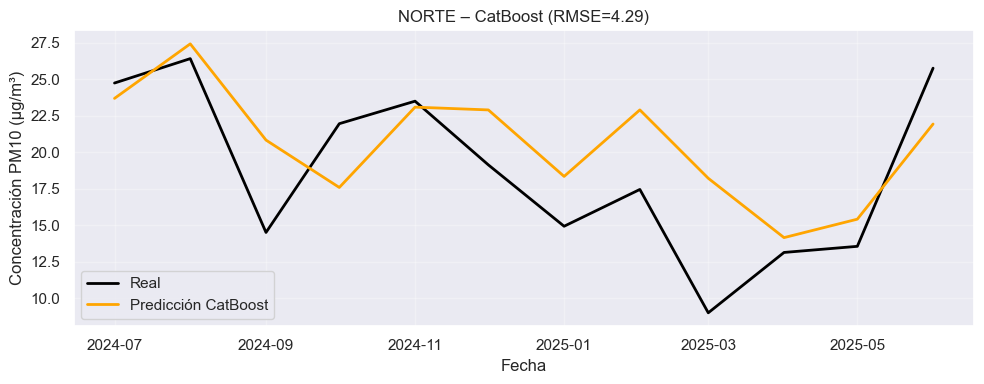

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG10\NORTE_CatBoost_predicciones_test.png
Entrenando modelo LightGBM ...
NORTE - LightGBM → RMSE: 4.453


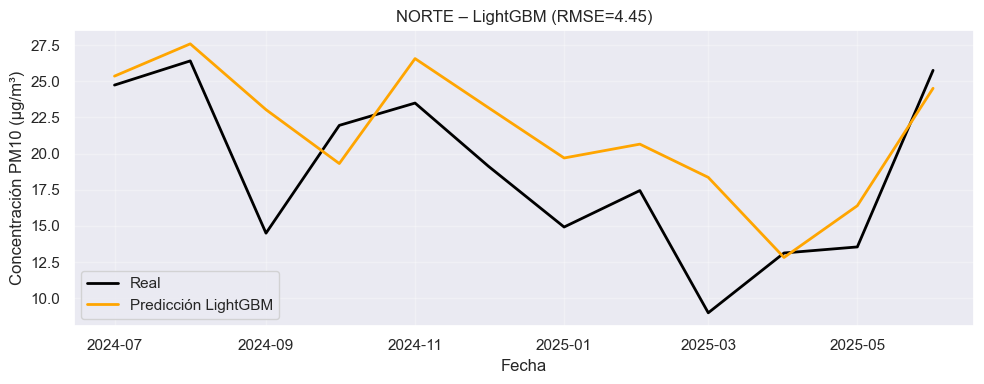

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG10\NORTE_LightGBM_predicciones_test.png
Entrenando modelo XGBoost ...
NORTE - XGBoost → RMSE: 4.638


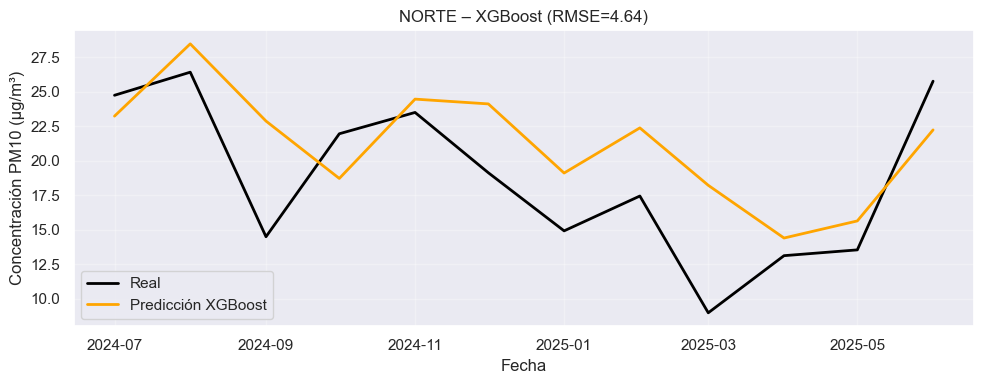

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG10\NORTE_XGBoost_predicciones_test.png

=== ZONA CENTRO ===
Entrenando modelo CatBoost ...
CENTRO - CatBoost → RMSE: 3.755


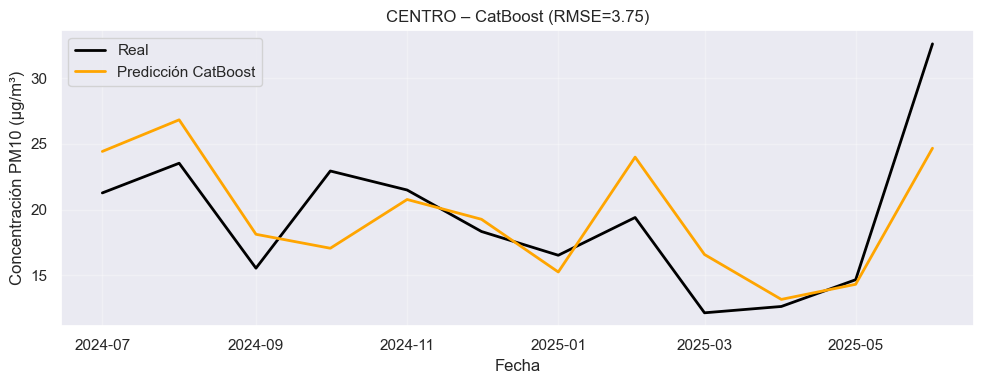

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG10\CENTRO_CatBoost_predicciones_test.png
Entrenando modelo LightGBM ...
CENTRO - LightGBM → RMSE: 3.881


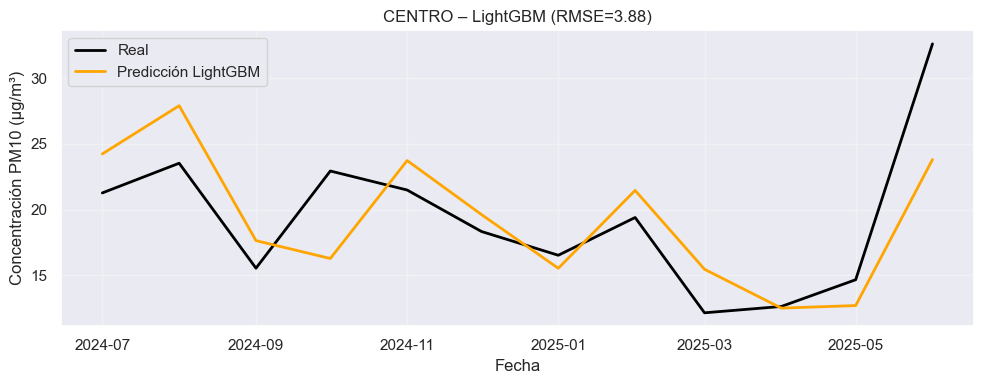

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG10\CENTRO_LightGBM_predicciones_test.png
Entrenando modelo XGBoost ...
CENTRO - XGBoost → RMSE: 3.996


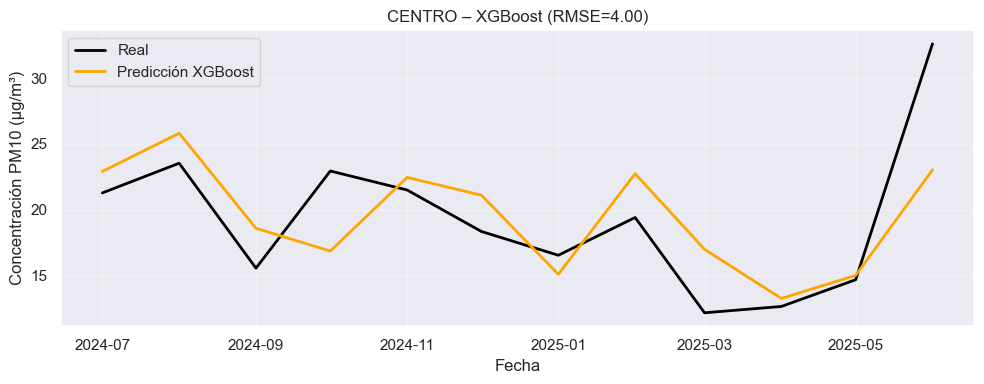

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG10\CENTRO_XGBoost_predicciones_test.png

=== ZONA SUR ===
Entrenando modelo CatBoost ...
SUR - CatBoost → RMSE: 4.562


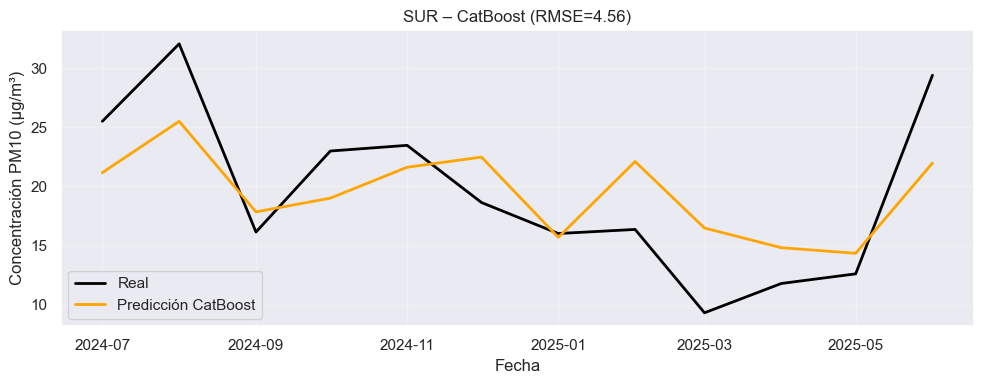

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG10\SUR_CatBoost_predicciones_test.png
Entrenando modelo LightGBM ...
SUR - LightGBM → RMSE: 4.885


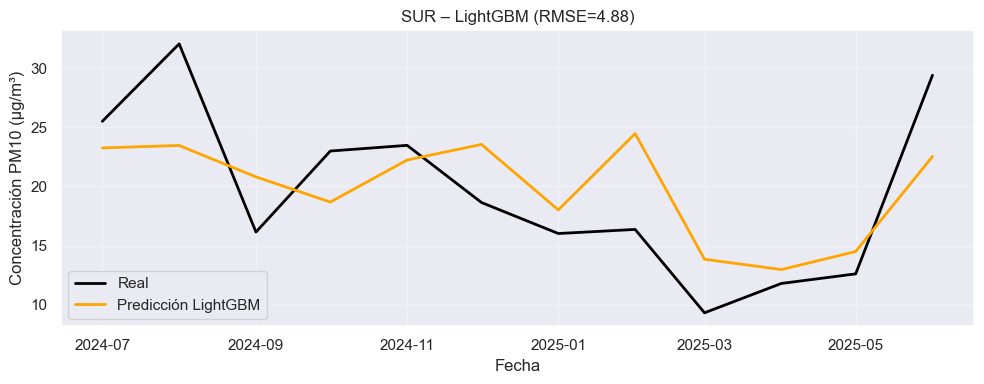

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG10\SUR_LightGBM_predicciones_test.png
Entrenando modelo XGBoost ...
SUR - XGBoost → RMSE: 4.336


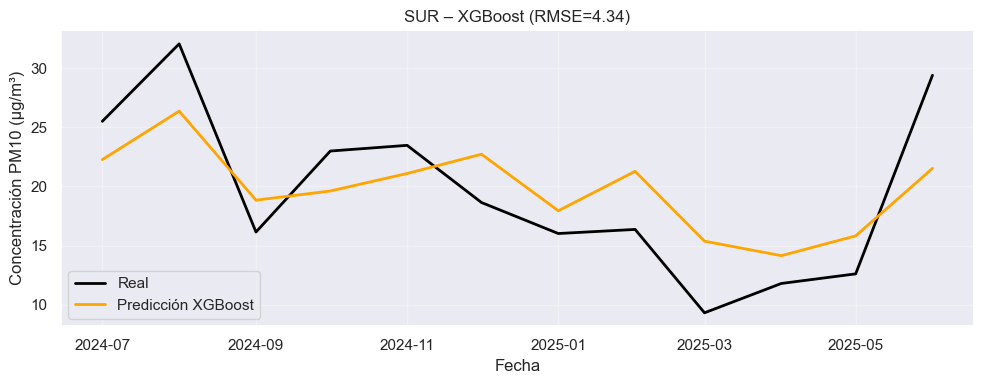

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG10\SUR_XGBoost_predicciones_test.png

>>> RESULTADOS COMPARATIVOS (RMSE test) <<<
  Zona   Modelo  RMSE_test  n_train  n_test
CENTRO CatBoost      3.755      162      12
CENTRO LightGBM      3.881      162      12
CENTRO  XGBoost      3.996      162      12
 NORTE CatBoost      4.292      162      12
 NORTE LightGBM      4.453      162      12
 NORTE  XGBoost      4.638      162      12
   SUR  XGBoost      4.336      162      12
   SUR CatBoost      4.562      162      12
   SUR LightGBM      4.885      162      12

📁 Guardado CSV resumen: 07_Figs\07_predicciones_modelos_ML_MAG10\RMSE_modelos_ML_comparativa.csv


In [58]:
# ------------------------------------------------------------
# Carpeta de salida
# ------------------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "07_predicciones_modelos_ML_MAG10"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# ------------------------------------------------------------
# Configuración de los modelos
# ------------------------------------------------------------
MODELOS = {
    "CatBoost": CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function="RMSE",
        verbose=False,          # ← SILENCIA CatBoost
        random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1              # ← SILENCIA LightGBM
    ),
    "XGBoost": XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        verbosity=0             # ← SILENCIA XGBoost
    )
}

# ------------------------------------------------------------
# Entrenar y evaluar para cada zona
# ------------------------------------------------------------

resultados_ml = []
predicciones_ml = {}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== ZONA {zona} ===")
    
    X_train = Xtr_zona[zona]
    y_train = ytr_zona[zona]
    X_test  = Xte_zona[zona]
    y_test  = yte_zona[zona]

    predicciones_ml[zona] = {}

    for nombre, modelo in MODELOS.items():
        print(f"Entrenando modelo {nombre} ...")

        # Entrenamiento
        modelo.fit(X_train, y_train)

        # Predicción sobre test
        y_pred = modelo.predict(X_test)
        
        # Evaluación usando tu función
        rmse_val = evaluar_modelo(f"{zona} - {nombre}", y_test, y_pred)

        # Guardar resultados
        resultados_ml.append({
            "Zona": zona,
            "Modelo": nombre,
            "RMSE_test": round(rmse_val, 3),
            "n_train": len(X_train),
            "n_test": len(X_test)
        })

        # Guardar predicciones para análisis o gráfico posterior
        df_pred = pd.DataFrame({
            "real": y_test.values,
            "pred": y_pred
        }, index=y_test.index)
        predicciones_ml[zona][nombre] = df_pred

        # Gráfico comparativo
        plt.figure(figsize=(10,4))
        plt.plot(y_test.index, y_test, label="Real", color="black", linewidth=2)
        plt.plot(y_test.index, y_pred, label=f"Predicción {nombre}", color="orange", linewidth=2)
        plt.title(f"{zona} – {nombre} (RMSE={rmse_val:.2f})")
        plt.xlabel("Fecha")
        plt.ylabel("Concentración PM10 (µg/m³)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()

        ruta_fig = os.path.join(CARPETA_SALIDA, f"{zona}_{nombre}_predicciones_test.png")
        plt.savefig(ruta_fig, dpi=150)
        plt.show()
        plt.close()

        print(f"📁 Guardado gráfico: {ruta_fig}")

# ------------------------------------------------------------
# Crear tabla resumen
# ------------------------------------------------------------
df_resultados_ml = pd.DataFrame(resultados_ml)
df_resultados_ml = df_resultados_ml.sort_values(["Zona", "RMSE_test"]).reset_index(drop=True)

print("\n>>> RESULTADOS COMPARATIVOS (RMSE test) <<<")
print(df_resultados_ml.to_string(index=False))

# ------------------------------------------------------------
# Guardar CSV resumen
# ------------------------------------------------------------
csv_resultados = os.path.join(CARPETA_SALIDA, "RMSE_modelos_ML_comparativa.csv")
df_resultados_ml.to_csv(csv_resultados, index=False)
print(f"\n📁 Guardado CSV resumen: {csv_resultados}")

Guardamos los resultados de los RMSE en la tabla resumen:

In [59]:
# Renombramos columnas de df_resultados_ml para que encajen con df_rmse
df_resultados_ml = df_resultados_ml.rename(
    columns={"Zona": "zona", "Modelo": "modelo"}
)[["modelo", "zona", "RMSE_test"]]

#### 4) PREDICCIÓN HASTA 2032. EVALUACIÓN PREDICCIÓN 2030

##### 4.1. MEJOR MODELO POR ZONA

Guardamos modelos ya entrenados

In [60]:
modelos_entrenados = {  # zona -> {modelo_nombre -> objeto_modelo_entrenado}
    "NORTE": {},
    "CENTRO": {},
    "SUR": {}
}

for zona in ["NORTE", "CENTRO", "SUR"]:
    ...
    for nombre, modelo in MODELOS.items():
        ...
        modelo.fit(X_train, y_train)

        # Guardar el modelo entrenado
        modelos_entrenados[zona][nombre] = modelo

Se elije el mejor modelo en función del valor de los RMSE calculados

In [61]:
mejores_modelos_ml = (
    df_resultados_ml
    .sort_values(["zona", "RMSE_test"])
    .groupby("zona")
    .first()
    .reset_index()
)

print("\n>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<")
print(mejores_modelos_ml.to_string(index=False))


>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<
  zona   modelo  RMSE_test
CENTRO CatBoost      3.755
 NORTE CatBoost      4.292
   SUR  XGBoost      4.336


In [62]:
mejor_modelo_por_zona = {}
mejor_modelo_nombre = {}

for zona in df_resultados_ml["zona"].unique():
    fila_best = (
        df_resultados_ml[df_resultados_ml["zona"] == zona]
        .sort_values("RMSE_test")
        .iloc[0]
    )
    nombre_mejor = fila_best["modelo"]
    mejor_modelo_nombre[zona] = nombre_mejor
    mejor_modelo_por_zona[zona] = modelos_entrenados[zona][nombre_mejor]

print("\n>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<")
for zona in mejor_modelo_por_zona:
    modelo = mejor_modelo_nombre[zona]
    print(f"🟢 {zona:<8} → {modelo}")


>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<
🟢 CENTRO   → CatBoost
🟢 NORTE    → CatBoost
🟢 SUR      → XGBoost


##### 4.2. FORECAST ITERATIVO HASTA 2032

Dado que no se dispone de proyecciones mensuales de variables meteorológicas hasta 2032, se optó por mantener el componente exógeno del modelo ML mediante la climatología media mensual histórica. Es decir, para cada variable exógena se calculó la media de todos los valores observados para cada mes (enero–diciembre) y se usó esa media como valores para las condiciones típicas del mes en el horizonte de predicción


=== FORECAST ML HASTA 2032 PARA NORTE ===


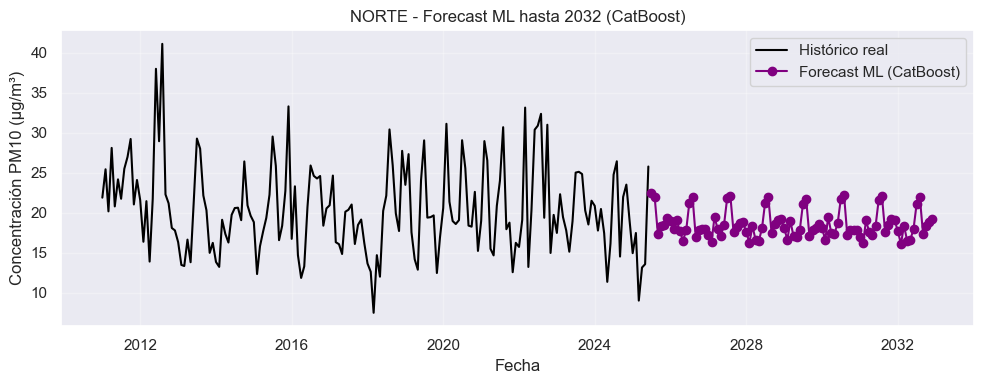

📁 Guardado gráfico forecast: 07_Figs\07_predicciones_modelos_ML_MAG10\NORTE_forecast_ML_hasta_2032_CatBoost.png

=== FORECAST ML HASTA 2032 PARA CENTRO ===


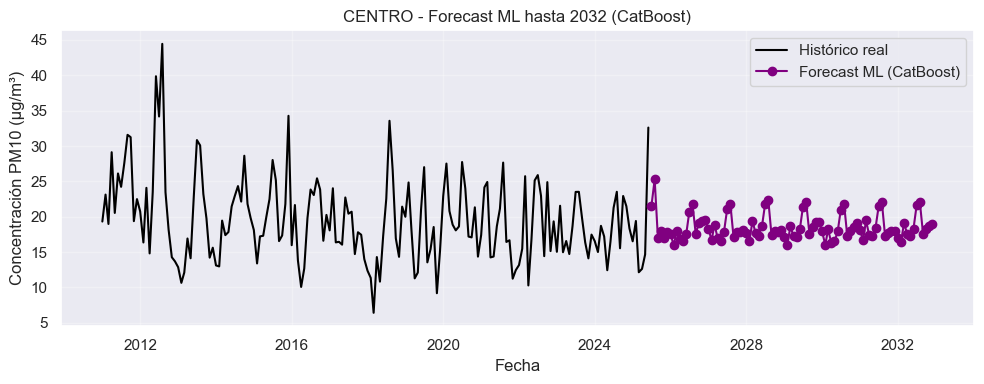

📁 Guardado gráfico forecast: 07_Figs\07_predicciones_modelos_ML_MAG10\CENTRO_forecast_ML_hasta_2032_CatBoost.png

=== FORECAST ML HASTA 2032 PARA SUR ===


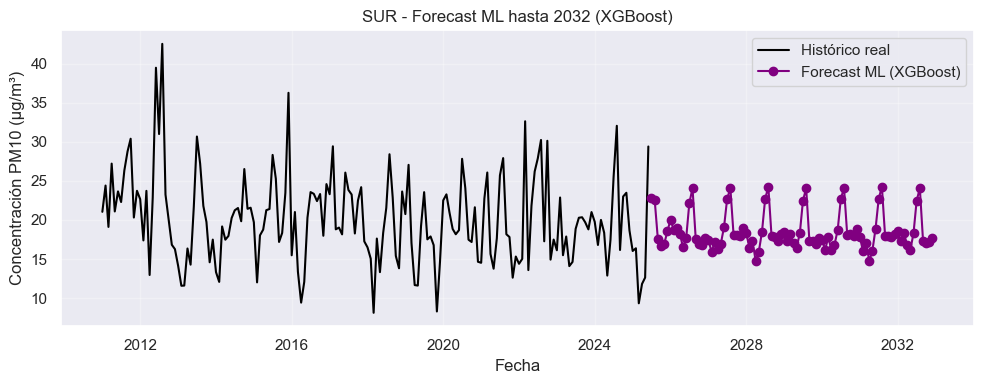

📁 Guardado gráfico forecast: 07_Figs\07_predicciones_modelos_ML_MAG10\SUR_forecast_ML_hasta_2032_XGBoost.png

>>> PROMEDIOS ANUALES PREVISTOS 2030 (MODELOS ML) <<<
  modelo   zona  promedio_anual_2030
CatBoost  NORTE               18.504
CatBoost CENTRO               18.219
 XGBoost    SUR               18.583


In [63]:
# ============================================================
# FORECAST ML HASTA 2032 (USANDO MODELO GANADOR POR ZONA)
# Y PROMEDIOS ANUALES 2030
# ============================================================

# Lista de columnas exógenas que se usaron en el entrenamiento ML
columnas_exogenas_para_ML = [
    "TEMPERATURA_MAX (°C)", "TEMPERATURA_MIN (°C)", "TEMPERATURA_MED (°C)",
    "PRESION_MED (hPa)",
    "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)",
    "VIENTO_DIR_100 (°)", "NIEVE (cm)",
    "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)",
    "VIENTO_MED_10 (km/h)", "VIENTO_DIR_10 (°)"
]

predicciones_futuras_ml = {}
promedios_2030_ml = []

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== FORECAST ML HASTA 2032 PARA {zona} ===")

    # 1. Recuperar el mejor modelo ya entrenado para esta zona
    mejor_modelo = mejor_modelo_por_zona[zona]
    nombre_mejor_modelo = mejor_modelo_nombre[zona]

    # 2. Histórico ML de la zona (devuelto por preparar_datos_ml)
    #    Este df_ml_zona[zona] debe tener índice datetime mensual
    #    y columnas: target, mes, anio, t_index, lags, rollings, exógenas...
    df_hist = df_ml_zona[zona].copy().sort_index()

    # 3. Columnas de entrada exactas esperadas por el modelo
    #    (el orden tiene que ser idéntico al entrenamiento)
    feature_cols = Xtr_zona[zona].columns.tolist()

    # 4. Forecast iterativo hasta dic 2032 usando climatología mensual de exógenas
    df_forecast = forecast_autoregresivo_hasta_2032(
        df_ml_hist=df_hist,
        modelo_entrenado=mejor_modelo,
        feature_cols=feature_cols,
        fecha_fin_forecast="2032-12-31",
        lags=[1,2,3,12],
        usar_columnas_exogenas=columnas_exogenas_para_ML
    )

    # Guardamos predicción larga para esa zona
    predicciones_futuras_ml[zona] = {
        "modelo": nombre_mejor_modelo,
        "forecast": df_forecast
    }

    # 5. Calcular el promedio del año 2030 para esa zona
    df_2030 = df_forecast[df_forecast.index.year == 2030]
    promedio_2030 = df_2030["pred"].mean()

    promedios_2030_ml.append({
        "modelo": nombre_mejor_modelo,
        "zona": zona,
        "promedio_anual_2030": promedio_2030
    })

    # 6. Graficar histórico + predicción futura
    plt.figure(figsize=(10,4))
    plt.plot(df_hist.index, df_hist["target"], color="black", linewidth=1.5, label="Histórico real")
    plt.plot(df_forecast.index, df_forecast["pred"], color="purple", marker="o",
             linewidth=1.5, label=f"Forecast ML ({nombre_mejor_modelo})")

    plt.title(f"{zona} - Forecast ML hasta 2032 ({nombre_mejor_modelo})")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración PM10 (µg/m³)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    ruta_fig_forecast = os.path.join(
        CARPETA_SALIDA,
        f"{zona}_forecast_ML_hasta_2032_{nombre_mejor_modelo}.png"
    )
    plt.savefig(ruta_fig_forecast, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico forecast: {ruta_fig_forecast}")

# ------------------------------------------------------------
# Convertimos la lista de promedios a DataFrame limpio
# ------------------------------------------------------------
df_promedios_2030_ml = pd.DataFrame(promedios_2030_ml)
df_promedios_2030_ml["promedio_anual_2030"] = df_promedios_2030_ml["promedio_anual_2030"].round(3)

print("\n>>> PROMEDIOS ANUALES PREVISTOS 2030 (MODELOS ML) <<<")
print(df_promedios_2030_ml.to_string(index=False))


### MODELOS DEEP LEARNING (LSTM y CNN)

Ahora vamos a entrenar dos arquitecturas por zona con modelos depp learning:

- LSTM (red recurrente que captura dependencias temporales largas)
- CNN1D causal (convoluciones sobre la serie temporal que detectan patrones locales/estacionales)
  * 1D = Unidimensional: los datos tienen una sola dimensión relevante para el modelo. En series temporales, esta dimensión es el tiempo.

1. Vamos a usar las mismas variables tabulares que ya tenemos de los modelos ML (lags, rolling, mes, exógenas climatológicas…), pero ahora tenemos que transformarlas en secuencias.
2. Evaluamos en el mismo conjunto test temporal (corte 2024-06-30).
3. Metemos sus RMSE en la tabla de comparación.
4. Preparamos (después) el forecast autoregresivo hasta 2032 con el mejor modelo por zona igual que hicimos con ML.
5. Metemos la predicción de 2030 en la tabls de comparación.

####  1) PREPARAR DATOS SECUENCIALES 

In [64]:
columnas_input_dl = [
    "target",
    "mes", "t_index",
    "roll3_mean", "roll6_mean", "roll12_mean",
    "TEMPERATURA_MAX (°C)", "TEMPERATURA_MIN (°C)", "TEMPERATURA_MED (°C)",
    "PRESION_MED (hPa)",
    "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)",
    "VIENTO_DIR_100 (°)", "NIEVE (cm)",
    "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)",
    "VIENTO_MED_10 (km/h)", "VIENTO_DIR_10 (°)"
]

In [65]:
CARPETA_BASE = "07_Figs"
SUBCARPETA = "08_deep_learning_MAG10"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

####  2) ENTRENAR LSTM Y CNN1D PARA CADA ZONA

Tras una primera ejecución del modelo, observo un claro sobreajuste, por lo qur trato de mitigarlo:

**2.1. Añado EaarlyStopping:** Permite que el modelo se pare cuando deja de mejorar en validación.

**2.2. Añado Dropout en la LSTM:** El Dropout apaga aleatoriamente neuronas durante el entrenamiento para obligar al modelo a generalizar.

**2.3. Simplifico la CNN1D:** Le quito filtros a las distintas capas


=== ZONA NORTE (Deep Learning) ===
DL | Corte 2024-06-30 | train=150 muestras | test=12 muestras
   Shapes -> X_train (150, 12, 20), y_train (150,), X_test (12, 12, 20), y_test (12,)
LSTM shapes: y_test_dl (12,), y_pred_lstm (12,)
LSTM NORTE → RMSE: 5.598
CNN1D shapes: y_test_dl (12,), y_pred_cnn (12,)
CNN1D NORTE → RMSE: 5.736


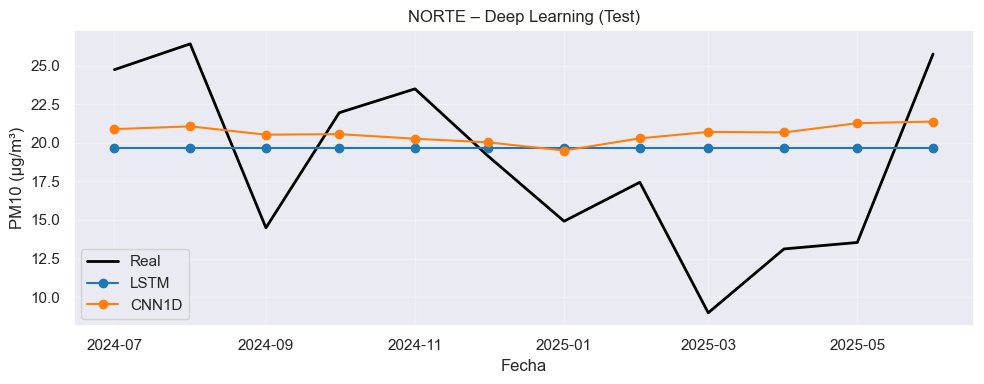

📁 Guardado gráfico: 07_Figs\08_deep_learning_MAG10\NORTE_DL_test_comparacion.png

=== ZONA CENTRO (Deep Learning) ===
DL | Corte 2024-06-30 | train=150 muestras | test=12 muestras
   Shapes -> X_train (150, 12, 20), y_train (150,), X_test (12, 12, 20), y_test (12,)
LSTM shapes: y_test_dl (12,), y_pred_lstm (12,)
LSTM CENTRO → RMSE: 5.845
CNN1D shapes: y_test_dl (12,), y_pred_cnn (12,)
CNN1D CENTRO → RMSE: 22.226


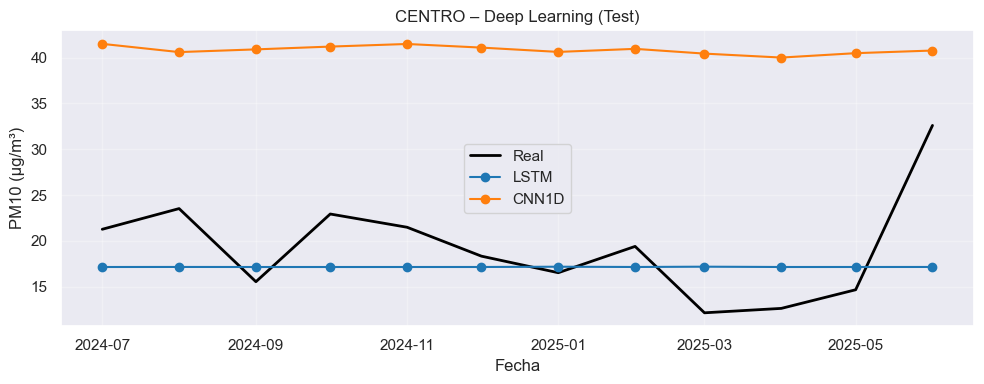

📁 Guardado gráfico: 07_Figs\08_deep_learning_MAG10\CENTRO_DL_test_comparacion.png

=== ZONA SUR (Deep Learning) ===
DL | Corte 2024-06-30 | train=150 muestras | test=12 muestras
   Shapes -> X_train (150, 12, 20), y_train (150,), X_test (12, 12, 20), y_test (12,)
LSTM shapes: y_test_dl (12,), y_pred_lstm (12,)
LSTM SUR → RMSE: 18.584
CNN1D shapes: y_test_dl (12,), y_pred_cnn (12,)
CNN1D SUR → RMSE: 7.493


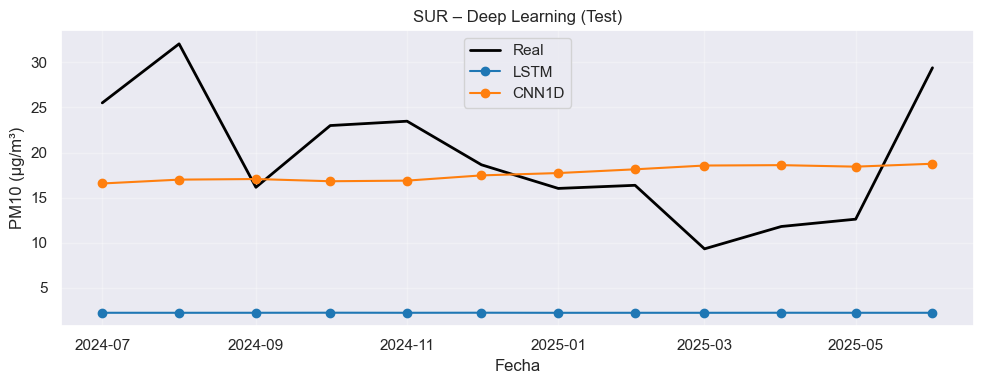

📁 Guardado gráfico: 07_Figs\08_deep_learning_MAG10\SUR_DL_test_comparacion.png

>>> RESULTADOS DEEP LEARNING (RMSE en test) <<<
  zona modelo  RMSE_test  n_train  n_test
 NORTE   LSTM      5.598      150      12
 NORTE  CNN1D      5.736      150      12
CENTRO   LSTM      5.845      150      12
CENTRO  CNN1D     22.226      150      12
   SUR   LSTM     18.584      150      12
   SUR  CNN1D      7.493      150      12


In [66]:
# Semilla global reproducible
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

callback_es = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

resultados_dl = []
predicciones_dl_test = {}
modelos_dl_entrenados = {"NORTE": {}, "CENTRO": {}, "SUR": {}}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== ZONA {zona} (Deep Learning) ===")

    df_ml = df_ml_zona[zona].copy().sort_index()
    cols_presentes = [c for c in columnas_input_dl if c in df_ml.columns]

    X_train_dl, y_train_dl, X_test_dl, y_test_dl, fechas_test_dl = construir_secuencias_dl(
        df_ml,
        fecha_corte="2024-06-30",
        window_size=12,
        columnas_input=cols_presentes,
        columna_objetivo="target"
    )

    n_steps  = X_train_dl.shape[1]
    n_feats  = X_train_dl.shape[2]

    # split interno train/val cronológico
    X_sub, y_sub, X_val, y_val = split_train_val(X_train_dl, y_train_dl, val_ratio=0.15)

    # --------- LSTM ---------
    lstm_model = build_lstm_model(n_steps, n_feats)
    lstm_model.fit(
        X_sub, y_sub,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=8,
        verbose=0,
        callbacks=[callback_es]
    )

    y_pred_lstm = lstm_model.predict(X_test_dl, verbose=0).flatten()
    print(f"LSTM shapes: y_test_dl {y_test_dl.shape}, y_pred_lstm {y_pred_lstm.shape}")
    rmse_lstm = evaluar_modelo(f"LSTM {zona}", y_test_dl, y_pred_lstm)

    resultados_dl.append({
        "zona": zona,
        "modelo": "LSTM",
        "RMSE_test": rmse_lstm,
        "n_train": X_train_dl.shape[0],
        "n_test": X_test_dl.shape[0]
    })

    predicciones_dl_test[(zona, "LSTM")] = pd.DataFrame({
        "real": y_test_dl,
        "pred": y_pred_lstm
    }, index=fechas_test_dl)

    modelos_dl_entrenados[zona]["LSTM"] = {
        "model": lstm_model,
        "cols_input": cols_presentes,
        "window_size": 12
    }

    # --------- CNN1D ---------
    cnn_model = build_cnn1d_model(n_steps, n_feats)
    cnn_model.fit(
        X_sub, y_sub,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=8,
        verbose=0,
        callbacks=[callback_es]
    )

    y_pred_cnn = cnn_model.predict(X_test_dl, verbose=0).flatten()
    print(f"CNN1D shapes: y_test_dl {y_test_dl.shape}, y_pred_cnn {y_pred_cnn.shape}")
    rmse_cnn = evaluar_modelo(f"CNN1D {zona}", y_test_dl, y_pred_cnn)

    resultados_dl.append({
        "zona": zona,
        "modelo": "CNN1D",
        "RMSE_test": rmse_cnn,
        "n_train": X_train_dl.shape[0],
        "n_test": X_test_dl.shape[0]
    })

    predicciones_dl_test[(zona, "CNN1D")] = pd.DataFrame({
        "real": y_test_dl,
        "pred": y_pred_cnn
    }, index=fechas_test_dl)

    modelos_dl_entrenados[zona]["CNN1D"] = {
        "model": cnn_model,
        "cols_input": cols_presentes,
        "window_size": 12
    }

    # --------- gráfico y guardado ---------
    plt.figure(figsize=(10,4))
    plt.plot(fechas_test_dl, y_test_dl, color="black", linewidth=2, label="Real")
    plt.plot(fechas_test_dl, y_pred_lstm, color="tab:blue", marker="o", label="LSTM")
    plt.plot(fechas_test_dl, y_pred_cnn, color="tab:orange", marker="o", label="CNN1D")
    plt.title(f"{zona} – Deep Learning (Test)")
    plt.ylabel("PM10 (µg/m³)")
    plt.xlabel("Fecha")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    ruta_png = os.path.join(CARPETA_SALIDA, f"{zona}_DL_test_comparacion.png")
    plt.savefig(ruta_png, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico: {ruta_png}")

# resumen final
df_resultados_dl = pd.DataFrame(resultados_dl)
print("\n>>> RESULTADOS DEEP LEARNING (RMSE en test) <<<")
print(df_resultados_dl.round(3).to_string(index=False))

In [67]:
df_resultados_dl_std = df_resultados_dl.rename(
    columns={"modelo": "modelo", "zona": "zona", "RMSE_test": "RMSE_test"}
)[["modelo", "zona", "RMSE_test", "n_train", "n_test"]]

####  3) PREDICCIÓN HASTA 2032. EVALUACIÓN PREDICCIÓN 2030

In [68]:
for zona in ["NORTE", "CENTRO", "SUR"]:
    df_ml_zona[zona].columns = [c.strip() for c in df_ml_zona[zona].columns]
    df_ml_zona[zona] = df_ml_zona[zona][~df_ml_zona[zona].index.duplicated(keep="first")]
    df_ml_zona[zona].sort_index(inplace=True)


=== FORECAST DL HASTA 2032 PARA NORTE ===
   ➤ Mejor modelo DL en NORTE: LSTM
   📁 Guardado forecast CSV: 07_Figs\08_deep_learning_MAG10\forecast_DL_NORTE_LSTM_hasta_2032.csv


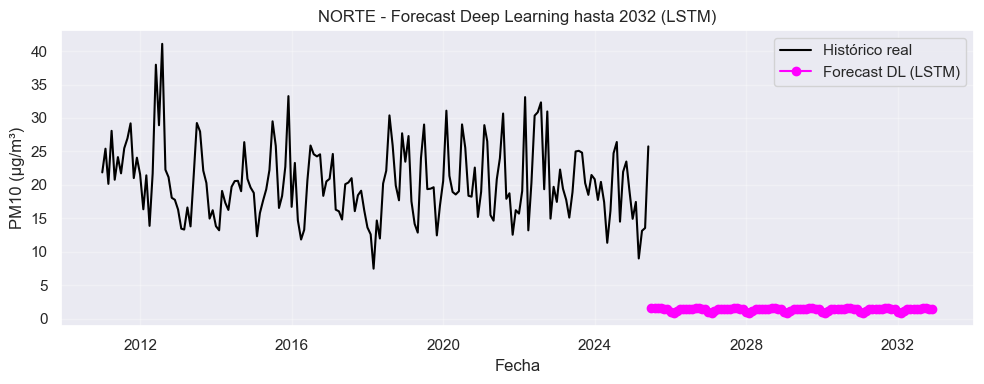

   📁 Guardado gráfico forecast: 07_Figs\08_deep_learning_MAG10\NORTE_forecast_DL_hasta_2032_LSTM.png

=== FORECAST DL HASTA 2032 PARA CENTRO ===
   ➤ Mejor modelo DL en CENTRO: LSTM
   📁 Guardado forecast CSV: 07_Figs\08_deep_learning_MAG10\forecast_DL_CENTRO_LSTM_hasta_2032.csv


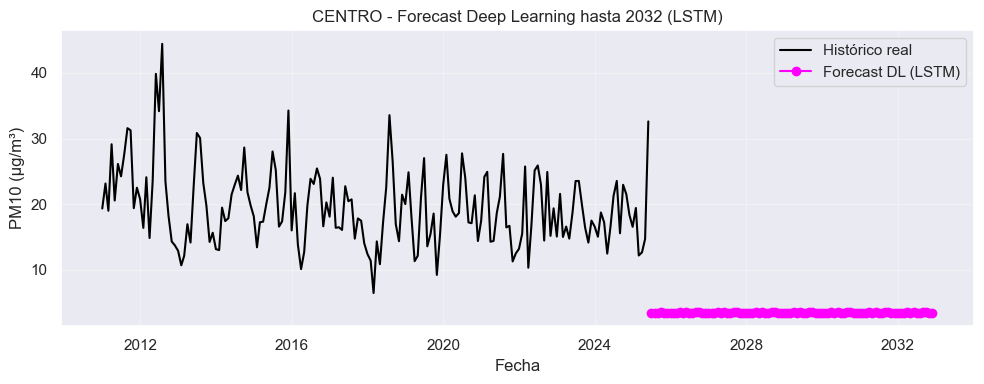

   📁 Guardado gráfico forecast: 07_Figs\08_deep_learning_MAG10\CENTRO_forecast_DL_hasta_2032_LSTM.png

=== FORECAST DL HASTA 2032 PARA SUR ===
   ➤ Mejor modelo DL en SUR: CNN1D
   📁 Guardado forecast CSV: 07_Figs\08_deep_learning_MAG10\forecast_DL_SUR_CNN1D_hasta_2032.csv


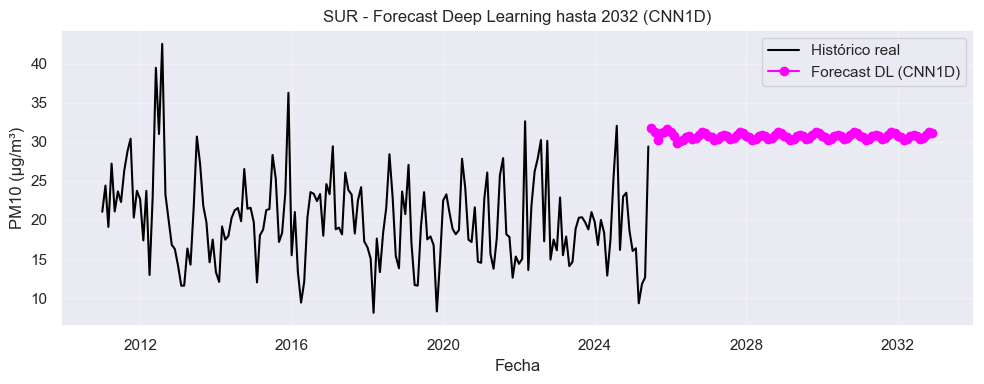

   📁 Guardado gráfico forecast: 07_Figs\08_deep_learning_MAG10\SUR_forecast_DL_hasta_2032_CNN1D.png

>>> PROMEDIOS ANUALES PREVISTOS 2030 (Deep Learning - mejor modelo por zona) <<<
modelo   zona  promedio_anual_2030
  LSTM  NORTE                1.347
  LSTM CENTRO                3.448
 CNN1D    SUR               30.691


In [69]:
promedios_2030_dl = []
predicciones_futuras_dl = {}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== FORECAST DL HASTA 2032 PARA {zona} ===")

    df_hist_zona = df_ml_zona[zona].copy().sort_index()

    # mejor modelo DL (menor RMSE_test)
    fila_best_dl = (
        df_resultados_dl[df_resultados_dl["zona"] == zona]
        .sort_values("RMSE_test")
        .iloc[0]
    )
    nombre_mejor_dl = fila_best_dl["modelo"]
    print(f"   ➤ Mejor modelo DL en {zona}: {nombre_mejor_dl}")

    info_mejor = modelos_dl_entrenados[zona][nombre_mejor_dl]
    modelo_dl         = info_mejor["model"]
    cols_input_mejor  = info_mejor["cols_input"]      # lista original de entrenamiento (19 cols)
    window_size_mejor = info_mejor["window_size"]     # 12

    df_forecast_dl = forecast_dl_hasta_2032(
        df_ml_hist=df_hist_zona,
        modelo_dl=modelo_dl,
        columnas_input_entrenamiento=cols_input_mejor,
        window_size=window_size_mejor,
        fecha_fin_forecast="2032-12-31"
    )

    predicciones_futuras_dl[zona] = {
        "modelo": nombre_mejor_dl,
        "forecast": df_forecast_dl
    }

    # promedio anual 2030
    df_2030_dl = df_forecast_dl[df_forecast_dl.index.year == 2030]
    promedio_2030_dl = df_2030_dl["pred"].mean()

    promedios_2030_dl.append({
        "modelo": nombre_mejor_dl,
        "zona": zona,
        "promedio_anual_2030": promedio_2030_dl
    })

    # guardar CSV forecast completo
    ruta_csv_forecast = os.path.join(
        CARPETA_SALIDA,
        f"forecast_DL_{zona}_{nombre_mejor_dl}_hasta_2032.csv"
    )
    df_forecast_dl.round(3).to_csv(ruta_csv_forecast)
    print(f"   📁 Guardado forecast CSV: {ruta_csv_forecast}")

    # gráfico histórico + forecast hasta 2032
    plt.figure(figsize=(10,4))
    plt.plot(df_hist_zona.index, df_hist_zona["target"], color="black", linewidth=1.5, label="Histórico real")
    plt.plot(df_forecast_dl.index, df_forecast_dl["pred"], color="magenta", marker="o",
             linewidth=1.5, label=f"Forecast DL ({nombre_mejor_dl})")
    plt.title(f"{zona} - Forecast Deep Learning hasta 2032 ({nombre_mejor_dl})")
    plt.xlabel("Fecha")
    plt.ylabel("PM10 (µg/m³)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    ruta_png_forecast = os.path.join(
        CARPETA_SALIDA,
        f"{zona}_forecast_DL_hasta_2032_{nombre_mejor_dl}.png"
    )
    plt.savefig(ruta_png_forecast, dpi=150)
    plt.show()
    plt.close()

    print(f"   📁 Guardado gráfico forecast: {ruta_png_forecast}")

# resumen comparativo 2030 (DL)
df_promedios_2030_dl = pd.DataFrame(promedios_2030_dl)
df_promedios_2030_dl["promedio_anual_2030"] = df_promedios_2030_dl["promedio_anual_2030"].round(3)

print("\n>>> PROMEDIOS ANUALES PREVISTOS 2030 (Deep Learning - mejor modelo por zona) <<<")
print(df_promedios_2030_dl.to_string(index=False))


### CUADRO COMPARATIVA MODELOS I

In [70]:
# ==========================================================
# 1️⃣ Convertir listas a DataFrames
# ==========================================================
df_rmse = pd.DataFrame(tabla_rmse_modelos)
df_pred_2030 = pd.DataFrame(tabla_predicciones_2030)

# Unir RMSEs de ARIMA/SARIMA + ML + deep learning
df_rmse = pd.concat([df_rmse, df_resultados_ml], ignore_index=True)
df_rmse = pd.concat(
    [df_rmse, df_resultados_dl_std],
    ignore_index=True
)

# Unir predicción 2030 de ARIMA/SARIMA + ML + deep learning
df_pred_2030 = pd.concat([df_pred_2030, df_promedios_2030_ml], ignore_index=True)
df_pred_2030 = pd.concat([df_pred_2030, df_promedios_2030_dl], ignore_index=True)

# ==========================================================
# 2️⃣ Agrupar predicciones 2030 (modelo + zona)
# ==========================================================
df_pred_2030_resumen = (
    df_pred_2030
    .drop(columns=["pred_2030"], errors="ignore")       # eliminar columna de predicción individual
    .groupby(["modelo", "zona"], as_index=False)        # agrupar por modelo y zona
    .agg({"promedio_anual_2030": "mean"})               # mantener promedio
    .sort_values(by=["zona", "promedio_anual_2030"], ascending=[True, True])
)

# ==========================================================
# 3️⃣ Ordenar tabla RMSE por zona
# ==========================================================
df_rmse = (
    df_rmse
    .sort_values(by=["zona", "RMSE_test"], ascending=[True, True])
    .drop(columns=["order", "seasonal_order", "AIC","n_train", "n_test"], errors="ignore")
)

# ==========================================================
# 4️⃣ Mostrar resultados
# ==========================================================
print("\n>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<")
print(df_rmse.round(3).to_string(index=False))

print("\n>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada) <<<")
print(df_pred_2030_resumen.round(3).to_string(index=False))

# ==========================================================
# 5️⃣ Filtrar solo los modelos con menor RMSE por zona
# ==========================================================
mejores_modelos_por_zona = (
    df_rmse
    .sort_values(["zona", "RMSE_test"], ascending=[True, True])
    .groupby("zona", as_index=False)
    .first()[["zona", "modelo", "RMSE_test"]]
)

print("\n>>> MODELOS CON MENOR RMSE POR ZONA <<<")
print(mejores_modelos_por_zona.round(3).to_string(index=False))

# ==========================================================
# 6️⃣ Filtrar predicciones 2030 solo de esos modelos
# ==========================================================
df_pred_mejores_2030 = pd.merge(
    mejores_modelos_por_zona[["zona", "modelo"]],
    df_pred_2030_resumen,
    on=["zona", "modelo"],
    how="left"
)

print("\n>>> PREDICCIONES 2030 DE LOS MEJORES MODELOS (por zona) <<<")
print(df_pred_mejores_2030.round(3).to_string(index=False))



>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<
  modelo   zona  RMSE_test
CatBoost CENTRO      3.755
LightGBM CENTRO      3.881
 XGBoost CENTRO      3.996
  SARIMA CENTRO      5.137
    LSTM CENTRO      5.845
   ARIMA CENTRO      6.525
   CNN1D CENTRO     22.226
CatBoost  NORTE      4.292
  SARIMA  NORTE      4.360
LightGBM  NORTE      4.453
 XGBoost  NORTE      4.638
    LSTM  NORTE      5.598
   CNN1D  NORTE      5.736
   ARIMA  NORTE      6.049
 XGBoost    SUR      4.336
CatBoost    SUR      4.562
LightGBM    SUR      4.885
  SARIMA    SUR      5.207
   ARIMA    SUR      7.006
   CNN1D    SUR      7.493
    LSTM    SUR     18.584

>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada) <<<
  modelo   zona  promedio_anual_2030
    LSTM CENTRO                3.448
  SARIMA CENTRO               15.768
CatBoost CENTRO               18.219
   ARIMA CENTRO               25.276
    LSTM  NORTE                1.347
CatBoost  NORTE               18.504
  SARIMA  NORTE               19.073
   ARI

### PREDICCIÓN CONSIDERANDO EL TRÁFICO

#### PREPARACIÓN DATOS

Ahora vamos a ejecutar los siguientes modelos, pero incluyendo la variable relativa al tráfico ("TOTAL_HOR_EXT"). Dado que esta variable no contiene valores coherentes antes de 2019, friltramos el dataframe, de modo que me quede con:

- Valores posteriores a 2019.
- Instancias con MAGNITUD = 10 (PM10)
- Las variables interesantes de antes + "TOTAL_HOR_EXT"
- Sobre este dataframe aplicaré los modelos:
  * CatBoost para las 3 zonas.
  * Adicionalmente, XGBoost para la zona SUR

In [71]:
df_traf = pd.read_parquet("05_DATASET_FINAL.parquet")

In [72]:
df_traf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186780 entries, 0 to 186779
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DIA/MES/ANO               186780 non-null  datetime64[ns]
 1   MAGNITUD                  186780 non-null  category      
 2   ZONA_ESTACION             186780 non-null  category      
 3   MEDICION_ugm3             186780 non-null  float64       
 4   TEMPERATURA_MAX (°C)      186780 non-null  float64       
 5   TEMPERATURA_MIN (°C)      186780 non-null  float64       
 6   TEMPERATURA_MED (°C)      186780 non-null  float64       
 7   PRECIPITACIONES (mm)      186780 non-null  float64       
 8   HUMEDAD_MAX (%)           186780 non-null  float64       
 9   HUMEDAD_MIN (%)           186780 non-null  float64       
 10  HUMEDAD_MED (%)           186780 non-null  float64       
 11  NIEVE (cm)                186780 non-null  float64       
 12  VI

In [73]:
df_traf.head()

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
0  2010-01-01        1        CENTRO       8.666667              8.833577   
1  2010-01-01        9           SUR       8.000000              8.833577   
2  2010-01-01        9         NORTE       8.000000              8.833577   
3  2010-01-01        9        CENTRO       6.000000              8.833577   
4  2010-01-01        8           SUR      21.666667              8.833577   

   TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
0              4.033577              5.879828                   0.1   
1              4.033577              5.879828                   0.1   
2              4.033577              5.879828                   0.1   
3              4.033577              5.879828                   0.1   
4              4.033577              5.879828                   0.1   

   HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  NUBES (%)  HORAS_SOL (min)  \
0         81.77903        63.816715  ...  55.933334        227.16466   
1         81.77903        63.816715  ...  55.933334        227.16466   
2         81.77903        63.816715  ...  55.933334        227.16466   
3         81.77903        63.816715  ...  55.933334        227.16466   
4         81.77903        63.816715  ...  55.933334        227.16466   

   RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  PRESION_MIN (hPa)  \
0                   1329.0             1017.5             1007.3   
1                   1329.0             1017.5             1007.3   
2                   1329.0             1017.5             1007.3   
3                   1329.0             1017.5             1007.3   
4                   1329.0             1017.5             1007.3   

   PRESION_MED (hPa)   TOTAL_HOR_EXT  Superficie_incendiada_HA  dow  month  
0         1011.06665       2196158.0                       0.0    4      1  
1         1011.06665  2012742.333333                       0.0    4      1  
2         1011.06665       1489878.0                       0.0    4      1  
3         1011.06665       2196158.0                       0.0    4      1  
4         1011.06665  2012742.333333                       0.0    4      1  

[5 rows x 30 columns]

In [74]:
# 1) Fecha a datetime una sola vez
df_traf["DIA/MES/ANO"] = pd.to_datetime(df_traf["DIA/MES/ANO"], errors="coerce")
if df_traf["DIA/MES/ANO"].isna().any():
    df_traf["DIA/MES/ANO"] = pd.to_datetime(df_traf["DIA/MES/ANO"], errors="coerce", dayfirst=True)

# 2) Crear columna year
df_traf["year"] = df_traf["DIA/MES/ANO"].dt.year

# 3) Filtrar MAGNITUD = 10 y year >= 2019
df_traf_2019_pm10 = df_traf[(df_traf["MAGNITUD"] == "10") & (df_traf["year"] >= 2019)].copy()

# 4) Diccionario por zona (no sobrescribas el DataFrame)
dfs_traf_2019_pm10 = {
    zona: sub_df.copy()
    for zona, sub_df in df_traf_2019_pm10.groupby("ZONA_ESTACION")
}

# Chequeo rápido
print(len(df_traf_2019_pm10), "filas desde 2019 (PM10).")
print("Zonas:", list(dfs_traf_2019_pm10.keys()))



7119 filas desde 2019 (PM10).
Zonas: ['CENTRO', 'NORTE', 'SUR']


C:\Users\rosal\AppData\Local\Temp\ipykernel_18564\804243919.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for zona, sub_df in df_traf_2019_pm10.groupby("ZONA_ESTACION")


In [75]:
df_ejemplo = dfs_traf_2019_pm10["NORTE"]
df_ejemplo.head(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  \
108493  2019-01-01       10         NORTE      30.000000   
108529  2019-01-02       10         NORTE      34.000000   
108559  2019-01-03       10         NORTE      22.666667   
108592  2019-01-04       10         NORTE      34.666667   
108625  2019-01-05       10         NORTE      34.666667   

        TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  \
108493             14.093577             -3.186423              3.386910   
108529             13.403577             -3.296423              3.027327   
108559             12.413577             -0.656423              4.486494   
108592             13.353578             -2.856423              3.270660   
108625             14.073577             -4.556423              2.530660   

        PRECIPITACIONES (mm)  HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  \
108493                   0.0         92.17930        36.185154  ...   
108529                   0.0         91.89168        35.215717  ...   
108559                   0.0         77.43969        33.838745  ...   
108592                   0.0         87.16396        36.146990  ...   
108625                   0.0         91.95199        36.551476  ...   

        HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
108493        563.75000                   2617.0             1032.9   
108529        555.46155                   2618.0             1031.8   
108559        433.56850                   2516.0             1030.4   
108592        566.23334                   2688.0             1032.5   
108625        567.05000                   2697.0             1035.3   

        PRESION_MIN (hPa)  PRESION_MED (hPa)  TOTAL_HOR_EXT  \
108493             1030.0          1031.2207  253170.666667   
108529             1026.8          1029.3458  253326.333333   
108559             1027.4          1028.8250       253947.0   
108592             1029.6          1030.7583       250629.0   
108625             1031.4          1033.1334       215091.0   

        Superficie_incendiada_HA  dow  month  year  
108493                      0.00    1      1  2019  
108529                      2.61    2      1  2019  
108559                      0.00    3      1  2019  
108592                     42.60    4      1  2019  
108625                      0.00    5      1  2019  

[5 rows x 31 columns]

In [76]:
# --- Filtrado de columnas por variables de interés ---
variables_interes = [
    "ZONA_ESTACION",
    "TEMPERATURA_MAX (°C)", "TEMPERATURA_MIN (°C)", "TEMPERATURA_MED (°C)",
    "month", "dow",
    "PRESION_MED (hPa)",
    "VIENTO_MAX_100 (km/h)", "VIENTO_MIN_100 (km/h)", "VIENTO_MED_100 (km/h)",
    "VIENTO_DIR_100 (°)", "NIEVE (cm)",
    "VIENTO_MAX_10 (km/h)", "VIENTO_MIN_10 (km/h)",
    "VIENTO_MED_10 (km/h)", "VIENTO_DIR_10 (°)", "TOTAL_HOR_EXT"
]

# Creamos un nuevo diccionario con solo las columnas seleccionadas
dfs_mag_zona_traf_sel = {
    zona: sub_df[variables_interes].copy()
    for zona, sub_df in dfs_traf_2019_pm10.items()
    if all(col in sub_df.columns for col in variables_interes)
}

# --- Resumen ---
print(f"Sub–dataframes creados: {len(dfs_mag_zona_traf_sel)}")
for zona, df_sub in dfs_mag_zona_traf_sel.items():
    print(f"{zona}: {df_sub.shape[0]} filas, {df_sub.shape[1]} columnas")


Sub–dataframes creados: 3
CENTRO: 2373 filas, 17 columnas
NORTE: 2373 filas, 17 columnas
SUR: 2373 filas, 17 columnas


In [77]:
df_ejemplo = dfs_mag_zona_traf_sel["NORTE"]
df_ejemplo.head(5)

ZONA_ESTACION  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
108493         NORTE             14.093577             -3.186423   
108529         NORTE             13.403577             -3.296423   
108559         NORTE             12.413577             -0.656423   
108592         NORTE             13.353578             -2.856423   
108625         NORTE             14.073577             -4.556423   

        TEMPERATURA_MED (°C)  month  dow  PRESION_MED (hPa)  \
108493              3.386910      1    1          1031.2207   
108529              3.027327      1    2          1029.3458   
108559              4.486494      1    3          1028.8250   
108592              3.270660      1    4          1030.7583   
108625              2.530660      1    5          1033.1334   

        VIENTO_MAX_100 (km/h)  VIENTO_MIN_100 (km/h)  VIENTO_MED_100 (km/h)  \
108493               9.746631               1.297998               4.828871   
108529              20.767975               2.902413               9.415603   
108559              23.177400               3.319036              11.556825   
108592               8.669949               0.509117               5.060158   
108625              13.207634               2.545584               6.483671   

        VIENTO_DIR_100 (°)  NIEVE (cm)  VIENTO_MAX_10 (km/h)  \
108493           17.612580         0.0              8.209263   
108529            4.406021         0.0              9.028754   
108559           50.234270         0.0              9.028754   
108592           15.080795         0.0              7.787991   
108625          341.625180         0.0              7.172949   

        VIENTO_MIN_10 (km/h)  VIENTO_MED_10 (km/h)  VIENTO_DIR_10 (°)  \
108493              1.138420              3.871547         328.109200   
108529              1.138420              5.512785         348.094900   
108559              2.276840              5.765665          28.022064   
108592              0.509117              3.758786         330.077880   
108625              1.609969              4.469867         325.355100   

        TOTAL_HOR_EXT  
108493  253170.666667  
108529  253326.333333  
108559       253947.0  
108592       250629.0  
108625       215091.0

In [78]:
# 1️⃣ Preparar diccionario de dataframes (ya MAG=10, desde 2019)
dfs_traf_2019_pm10_sel = {
    z: sub[[c for c in variables_interes + ["DIA/MES/ANO", "MEDICION_ugm3"] if c in sub.columns]].copy()
    for z, sub in dfs_traf_2019_pm10.items()
}

# 2️⃣ Crear datasets ML por zona
resultados_ml = preparar_para_modelos_por_zona(
    dfs_por_zona=dfs_traf_2019_pm10_sel,
    variables_interes=variables_interes,
    fecha_corte="2024-06-30",
    lags=[1,2,3,12]
)

# NORTE
Xtr_norte = resultados_ml["NORTE"]["X_train"]
ytr_norte = resultados_ml["NORTE"]["y_train"]
Xte_norte = resultados_ml["NORTE"]["X_test"]
yte_norte = resultados_ml["NORTE"]["y_test"]

# CENTRO
Xtr_centro = resultados_ml["CENTRO"]["X_train"]
ytr_centro = resultados_ml["CENTRO"]["y_train"]
Xte_centro = resultados_ml["CENTRO"]["X_test"]
yte_centro = resultados_ml["CENTRO"]["y_test"]

# SUR
Xtr_sur = resultados_ml["SUR"]["X_train"]
ytr_sur = resultados_ml["SUR"]["y_train"]
Xte_sur = resultados_ml["SUR"]["X_test"]
yte_sur = resultados_ml["SUR"]["y_test"]

for zona, datos in resultados_ml.items():
    Xtr, ytr = datos["X_train"], datos["y_train"]
    Xte, yte = datos["X_test"], datos["y_test"]
    print(f"{zona}: {Xtr.shape} train / {Xte.shape} test")


📆 Corte temporal 2024-06-30: train=54 / test=12
📆 Corte temporal 2024-06-30: train=54 / test=12
📆 Corte temporal 2024-06-30: train=54 / test=12

📊 Resumen por zona:
- CENTRO: train=54 | test=12 | exógenas=15
- NORTE: train=54 | test=12 | exógenas=15
- SUR: train=54 | test=12 | exógenas=15
CENTRO: (54, 25) train / (12, 25) test
NORTE: (54, 25) train / (12, 25) test
SUR: (54, 25) train / (12, 25) test


#### ENTRENAMIENTO MODELOS

In [79]:
cat_models_traf = {}
resultados_rmse_traf = []

# ==========================================================
# 🟩 CatBoost_TRAF – para las tres zonas
# ==========================================================
for zona, datos in resultados_ml.items():
    Xtr, ytr = datos["X_train"], datos["y_train"]
    Xte, yte = datos["X_test"], datos["y_test"]

    cat = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function="RMSE",
        verbose=False,          # ← SILENCIA CatBoost
        random_state=42
    )

    cat.fit(Xtr, ytr, eval_set=(Xte, yte), verbose=False)
    pred_cat = cat.predict(Xte)
    rmse_cat = evaluar_modelo(f"CatBoost_TRAF [{zona}]", yte, pred_cat)

    cat_models_traf[zona] = cat
    resultados_rmse_traf.append({
        "modelo": "CatBoost_TRAF",
        "zona": zona,
        "RMSE_test": rmse_cat
    })

# ==========================================================
# 🟦 XGBoost_TRAF – solo para la zona SUR
# ==========================================================
if "SUR" in resultados_ml:
    Xtr, ytr = resultados_ml["SUR"]["X_train"], resultados_ml["SUR"]["y_train"]
    Xte, yte = resultados_ml["SUR"]["X_test"],  resultados_ml["SUR"]["y_test"]

    Xtr_enc, Xte_enc = Xtr.copy(), Xte.copy()  # ya numéricas en mensual

    xgb = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        verbosity=0             # ← SILENCIA XGBoost
    )
    
    xgb.fit(Xtr_enc, ytr, eval_set=[(Xte_enc, yte)], verbose=False)
    pred_xgb = xgb.predict(Xte_enc)
    rmse_xgb = evaluar_modelo("XGBoost_TRAF [SUR]", yte, pred_xgb)

    resultados_rmse_traf.append({
        "modelo": "XGBoost_TRAF",
        "zona": "SUR",
        "RMSE_test": rmse_xgb
    })
    xgb_model_traf_sur = xgb
else:
    print("⚠️ No se encontró la zona 'SUR' en resultados_ml; omito XGBoost_TRAF.")

# ==========================================================
# 📊 Cuadro resumen de resultados
# ==========================================================
df_resultados_traf = pd.DataFrame(resultados_rmse_traf).sort_values(["modelo", "zona"])
print("\nResumen RMSE – Modelos con variable de tráfico:\n")
print(df_resultados_traf)

# Si ya tienes otro df_resultados previo, puedes combinar así:
# df_resultados_total = pd.concat([df_resultados, df_resultados_traf], ignore_index=True)


CatBoost_TRAF [CENTRO] → RMSE: 4.410
CatBoost_TRAF [NORTE] → RMSE: 5.412
CatBoost_TRAF [SUR] → RMSE: 5.621
XGBoost_TRAF [SUR] → RMSE: 5.973

Resumen RMSE – Modelos con variable de tráfico:

          modelo    zona  RMSE_test
0  CatBoost_TRAF  CENTRO   4.410214
1  CatBoost_TRAF   NORTE   5.412053
2  CatBoost_TRAF     SUR   5.620665
3   XGBoost_TRAF     SUR   5.973124


#### REPRESENTACION GRÁFICA

📁 Guardado gráfico: 07_Figs\09_predicciones_tráfico_MAG10\CatBoost_TRAF_SUR.png


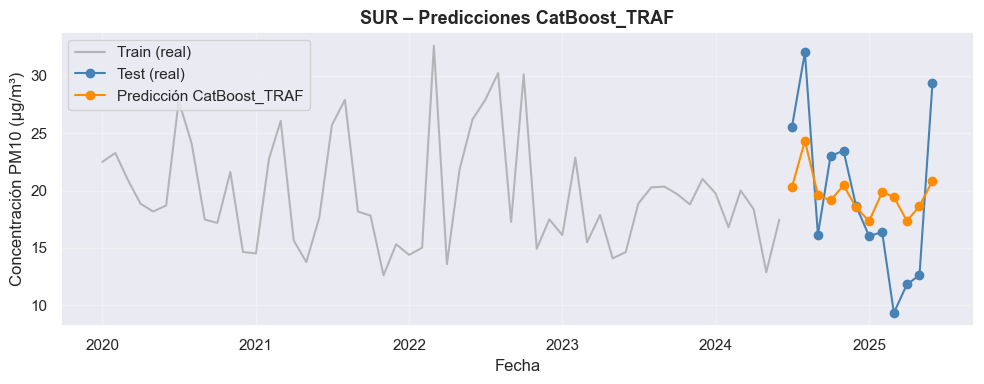

📁 Guardado gráfico: 07_Figs\09_predicciones_tráfico_MAG10\XGBoost_TRAF_SUR.png


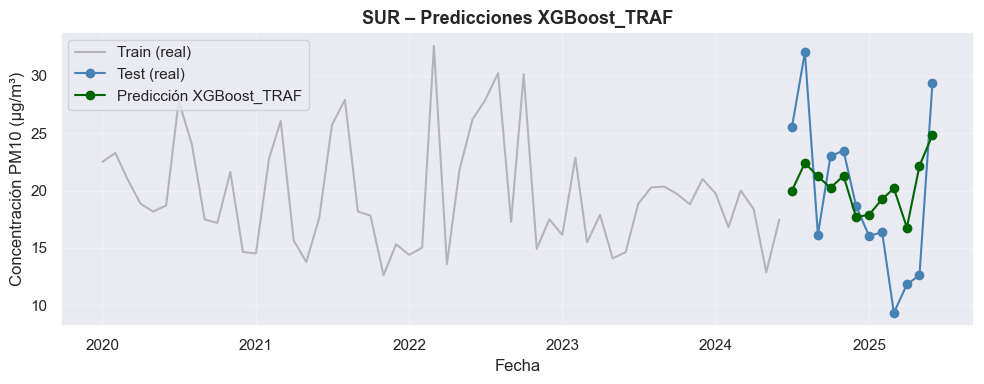

📁 Guardado gráfico: 07_Figs\09_predicciones_tráfico_MAG10\CatBoost_TRAF_NORTE.png


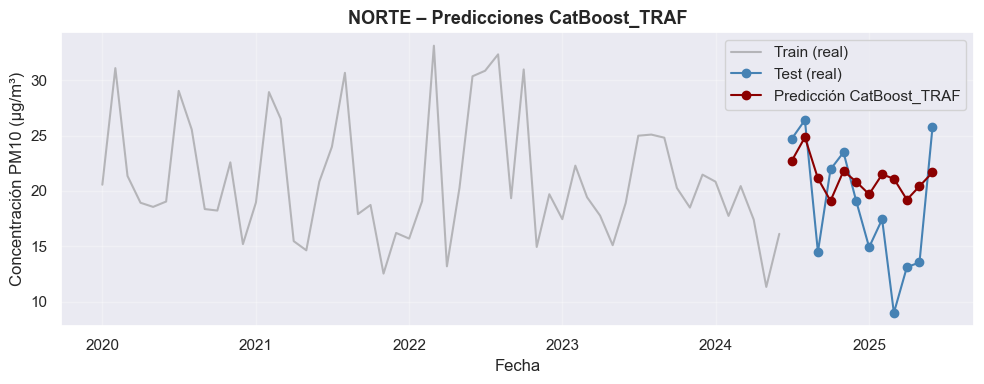

📁 Guardado gráfico: 07_Figs\09_predicciones_tráfico_MAG10\CatBoost_TRAF_CENTRO.png


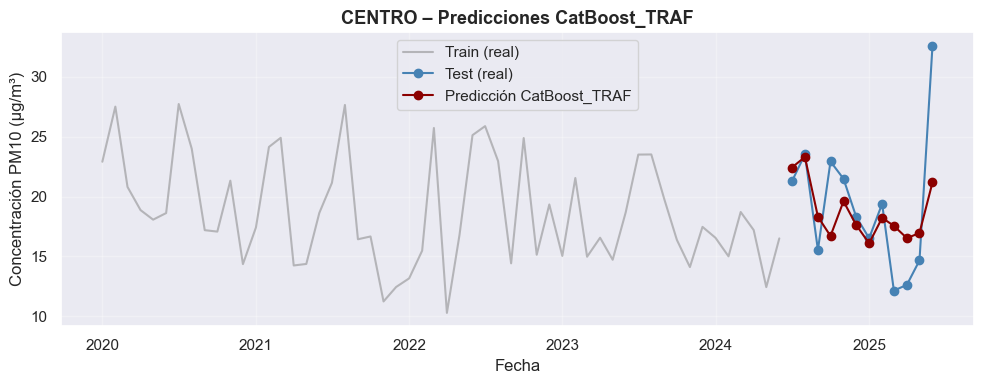

In [80]:
# CatBoost_TRAF – Zona SUR

CARPETA_BASE = "07_Figs"
SUBCARPETA = "09_predicciones_tráfico_MAG10"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

y_train = resultados_ml["SUR"]["y_train"]
y_test  = resultados_ml["SUR"]["y_test"]
y_pred  = cat_models_traf["SUR"].predict(resultados_ml["SUR"]["X_test"])

plot_predicciones_traf(
    zona="SUR",
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred,
    modelo="CatBoost_TRAF",
    ruta_salida=CARPETA_SALIDA,
    color_pred="darkorange"
)

# XGBoost_TRAF – Zona SUR

y_train = resultados_ml["SUR"]["y_train"]
y_test  = resultados_ml["SUR"]["y_test"]
y_pred  = xgb_model_traf_sur.predict(resultados_ml["SUR"]["X_test"])

plot_predicciones_traf(
    zona="SUR",
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred,
    modelo="XGBoost_TRAF",
    ruta_salida=CARPETA_SALIDA,
    color_pred="darkgreen"
)

# CatBoost_TRAF – NORTE y CENTRO

for zona in ["NORTE", "CENTRO"]:
    y_train = resultados_ml[zona]["y_train"]
    y_test  = resultados_ml[zona]["y_test"]
    y_pred  = cat_models_traf[zona].predict(resultados_ml[zona]["X_test"])

    plot_predicciones_traf(
        zona=zona,
        y_train=y_train,
        y_test=y_test,
        y_pred=y_pred,
        modelo="CatBoost_TRAF",
        ruta_salida=CARPETA_SALIDA,
        color_pred="darkred"
    )


#### CUADRO COMPARATIVA RSME MODELOS

In [81]:
# ==========================================================
# 1️⃣ Convertir listas a DataFrames
# ==========================================================
df_rmse = pd.DataFrame(tabla_rmse_modelos)

# Unir RMSEs de ARIMA/SARIMA + ML + deep learning + tráfico
df_rmse = pd.concat([df_rmse, df_resultados_ml,df_resultados_dl_std], ignore_index=True)
df_rmse = pd.concat(
    [df_rmse, df_resultados_traf],
    ignore_index=True
)

# ==========================================================
# 3️⃣ Ordenar tabla RMSE por zona
# ==========================================================
df_rmse = (
    df_rmse
    .sort_values(by=["zona", "RMSE_test"], ascending=[True, True])
    .drop(columns=["order", "seasonal_order", "AIC","n_train", "n_test"], errors="ignore")
)

# ==========================================================
# 4️⃣ Mostrar resultados
# ==========================================================
print("\n>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<")
print(df_rmse.round(3).to_string(index=False))



>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<
       modelo   zona  RMSE_test
     CatBoost CENTRO      3.755
     LightGBM CENTRO      3.881
      XGBoost CENTRO      3.996
CatBoost_TRAF CENTRO      4.410
       SARIMA CENTRO      5.137
         LSTM CENTRO      5.845
        ARIMA CENTRO      6.525
        CNN1D CENTRO     22.226
     CatBoost  NORTE      4.292
       SARIMA  NORTE      4.360
     LightGBM  NORTE      4.453
      XGBoost  NORTE      4.638
CatBoost_TRAF  NORTE      5.412
         LSTM  NORTE      5.598
        CNN1D  NORTE      5.736
        ARIMA  NORTE      6.049
      XGBoost    SUR      4.336
     CatBoost    SUR      4.562
     LightGBM    SUR      4.885
       SARIMA    SUR      5.207
CatBoost_TRAF    SUR      5.621
 XGBoost_TRAF    SUR      5.973
        ARIMA    SUR      7.006
        CNN1D    SUR      7.493
         LSTM    SUR     18.584


### CUADRO COMPARATIVA MODELOS II

In [82]:

# ==========================================================
# 4️⃣ Mostrar resultados
# ==========================================================
print("\n>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<")
print(df_rmse.round(3).to_string(index=False))

print("\n>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada) <<<")
print(df_pred_2030_resumen.round(3).to_string(index=False))

# ==========================================================
# 5️⃣ Filtrar solo los modelos con menor RMSE por zona
# ==========================================================
mejores_modelos_por_zona = (
    df_rmse
    .sort_values(["zona", "RMSE_test"], ascending=[True, True])
    .groupby("zona", as_index=False)
    .first()[["zona", "modelo", "RMSE_test"]]
)

print("\n>>> MODELOS CON MENOR RMSE POR ZONA <<<")
print(mejores_modelos_por_zona.round(3).to_string(index=False))

# ==========================================================
# 6️⃣ Filtrar predicciones 2030 solo de esos modelos
# ==========================================================
df_pred_mejores_2030 = pd.merge(
    mejores_modelos_por_zona[["zona", "modelo"]],
    df_pred_2030_resumen,
    on=["zona", "modelo"],
    how="left"
)

print("\n>>> PREDICCIONES 2030 DE LOS MEJORES MODELOS (por zona) <<<")
print(df_pred_mejores_2030.round(3).to_string(index=False))



>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<
       modelo   zona  RMSE_test
     CatBoost CENTRO      3.755
     LightGBM CENTRO      3.881
      XGBoost CENTRO      3.996
CatBoost_TRAF CENTRO      4.410
       SARIMA CENTRO      5.137
         LSTM CENTRO      5.845
        ARIMA CENTRO      6.525
        CNN1D CENTRO     22.226
     CatBoost  NORTE      4.292
       SARIMA  NORTE      4.360
     LightGBM  NORTE      4.453
      XGBoost  NORTE      4.638
CatBoost_TRAF  NORTE      5.412
         LSTM  NORTE      5.598
        CNN1D  NORTE      5.736
        ARIMA  NORTE      6.049
      XGBoost    SUR      4.336
     CatBoost    SUR      4.562
     LightGBM    SUR      4.885
       SARIMA    SUR      5.207
CatBoost_TRAF    SUR      5.621
 XGBoost_TRAF    SUR      5.973
        ARIMA    SUR      7.006
        CNN1D    SUR      7.493
         LSTM    SUR     18.584

>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada) <<<
  modelo   zona  promedio_anual_2030
    LSTM CENTRO            

## PREDICCIONES MEJORES RESULTADOS

σ(train) = 2.2215  (n=162)


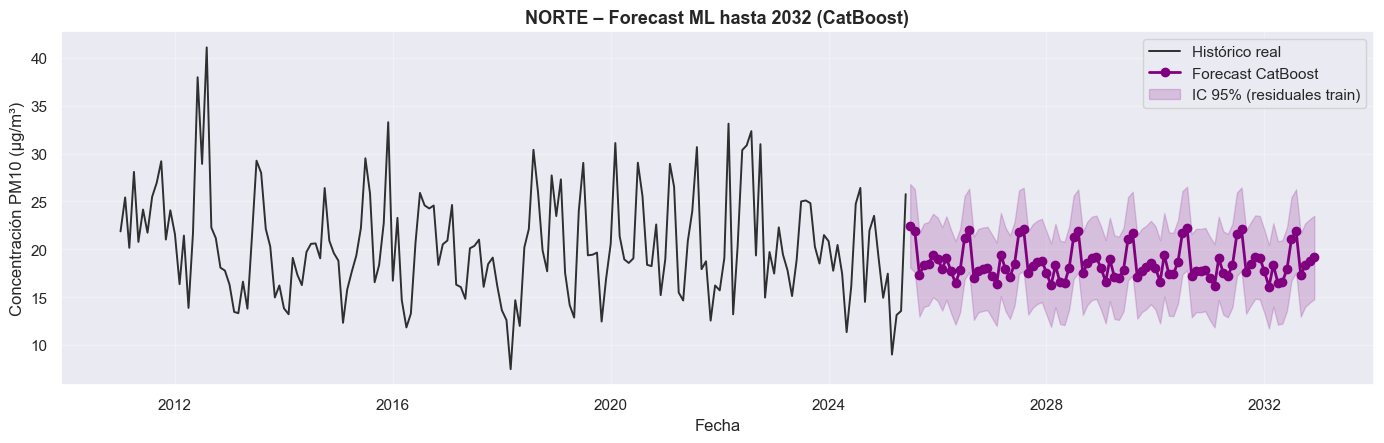

📁 Guardado: 07_Figs\10_MEJORES PREDICCIONES_MAG10\NORTE_ML_largo_CatBoost.png
σ(train) = 2.3133  (n=162)


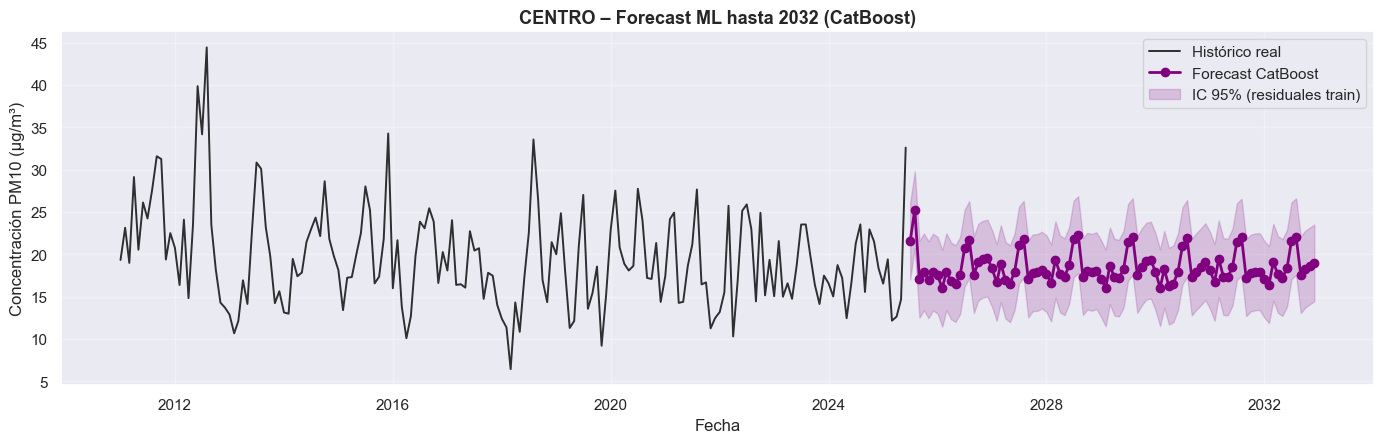

📁 Guardado: 07_Figs\10_MEJORES PREDICCIONES_MAG10\CENTRO_ML_largo_CatBoost.png
σ(train) = 0.0005  (n=162)


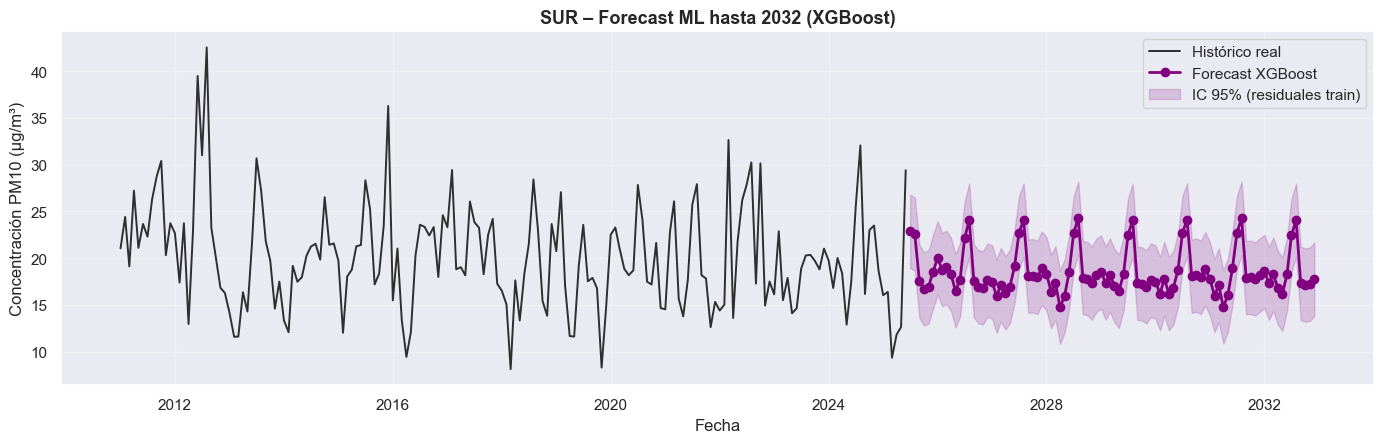

📁 Guardado: 07_Figs\10_MEJORES PREDICCIONES_MAG10\SUR_ML_largo_XGBoost.png


C:\Users\rosal\AppData\Local\Temp\ipykernel_18564\977521178.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  anual = df_m["pred"].resample("Y").mean()
C:\Users\rosal\AppData\Local\Temp\ipykernel_18564\977521178.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  anual = df_m["pred"].resample("Y").mean()
C:\Users\rosal\AppData\Local\Temp\ipykernel_18564\977521178.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  anual = df_m["pred"].resample("Y").mean()


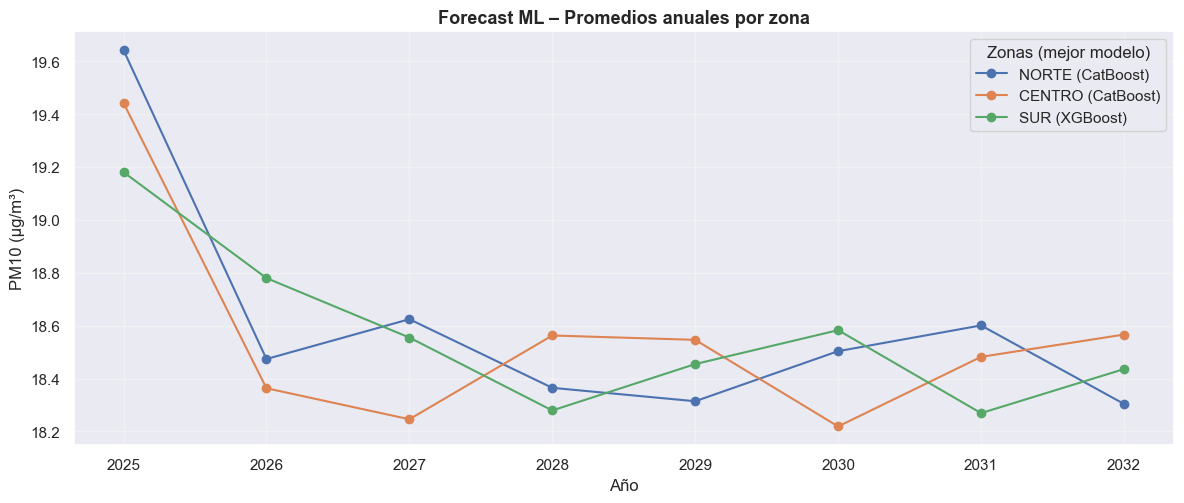

📁 Guardado: 07_Figs\10_MEJORES PREDICCIONES_MAG10\ML_comparativo_anual_zonas.png


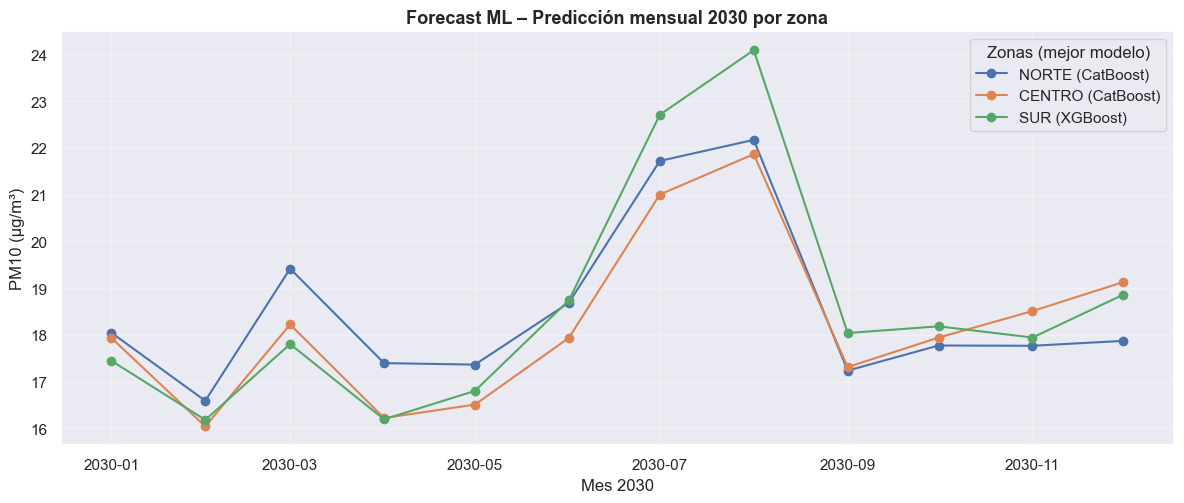

📁 Guardado: 07_Figs\10_MEJORES PREDICCIONES_MAG10\ML_2030_comparativo_mensual_zonas.png


In [83]:
CARPETA_BASE = "07_Figs"
SUBCARPETA = "10_MEJORES PREDICCIONES_MAG10"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# (1–3) 3 gráficos por zona con IC
for zona in ["NORTE", "CENTRO", "SUR"]:
    pack = predicciones_futuras_ml[zona]
    df_fore = pack["forecast"]
    nombre_modelo = pack["modelo"]

    modelo_entrenado = mejor_modelo_por_zona[zona]
    Xtr = Xtr_zona[zona]
    ytr = ytr_zona[zona]
    # Histórico con 'target' ya construido por preparar_datos_ml
    df_hist = df_ml_zona[zona].copy().sort_index()

    # Columnas exactas de entrenamiento por zona
    feature_cols = Xtr.columns.tolist()

    plot_largo_por_zona_ml(
    zona=zona,
    df_hist=df_hist,
    modelo_entrenado=modelo_entrenado,
    X_train=Xtr, y_train=ytr,
    df_forecast=df_fore,
    nombre_modelo=nombre_modelo,
    ruta_salida_dir=CARPETA_SALIDA,
    feature_cols=feature_cols,
    mostrar=True   # <-- para verlos en pantalla
)
    
# (4) Comparativo anual por zona (promedios anuales)
plot_comparativo_anual(predicciones_futuras_ml, CARPETA_SALIDA,mostrar=True)

# (5) Comparativo mensual 2030 por zona (líneas de las 3 zonas)
plot_comparativo_mensual_2030(predicciones_futuras_ml, CARPETA_SALIDA,mostrar=True)


In [84]:
# Extraer la serie predictora para la zona SUR
pack_sur = predicciones_futuras_ml["SUR"]

# Normalmente el forecast ya viene como DataFrame
df_pred_sur = pack_sur["forecast"]

# Asegurar que es DataFrame (por si fuera Series o ndarray)
df_pred_sur = pd.DataFrame(df_pred_sur)

# Mostrar las primeras filas
print(df_pred_sur.head())

                 pred
2025-07-01  22.844713
2025-08-01  22.579872
2025-09-01  17.507538
2025-10-01  16.715141
2025-11-01  16.908699


In [85]:
df_pred_sur = df_pred_sur.copy()
df_pred_sur.index = pd.to_datetime(df_pred_sur.index)

In [86]:
df_pm10_sur = df_pred_sur

In [87]:
df_pm10_sur

pred
2025-07-01  22.844713
2025-08-01  22.579872
2025-09-01  17.507538
2025-10-01  16.715141
2025-11-01  16.908699
...               ...
2032-08-01  24.062908
2032-09-01  17.284348
2032-10-01  17.110588
2032-11-01  17.197350
2032-12-01  17.740280

[90 rows x 1 columns]

In [88]:
df_pm10_sur.to_parquet("07.01_df_pm10_sur.parquet", engine="pyarrow", index=False)